In [1]:
# 라이브러리 import 및 설정

import pandas as pd
import numpy as np
import pyodbc
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import optuna
import json
from datetime import datetime

# matplotlib을 위한 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 import 완료")

라이브러리 import 완료


In [2]:
# DB 연결 및 데이터 로드

# 데이터베이스 설정
DB_CONFIG = {
    'driver': 'ODBC Driver 17 for SQL Server',
    'server': 'localhost',
    'database': 'real_data',
    'trusted_connection': 'yes'
}

# DB 연결
conn_str = (
    f"DRIVER={{{DB_CONFIG['driver']}}};"
    f"SERVER={DB_CONFIG['server']};"
    f"DATABASE={DB_CONFIG['database']};"
    f"Trusted_Connection={DB_CONFIG['trusted_connection']};"
)

conn = pyodbc.connect(conn_str)

query = "SELECT * FROM union_charge_divided_by_pattern"
df = pd.read_sql(query, conn)
conn.close()

print(f"데이터 로드 완료: {df.shape}")
print(f"\n컬럼 목록:")
print(df.columns.tolist())
df.head()

데이터 로드 완료: (8950, 91)

컬럼 목록:
['time', 'charge', 'charge_min', 'melting_min', 'oxidation_min', 'work_time', 'EAF_wattage', 'CaO_CFW', 'Dolomite_CFW', 'CaO_HP', 'FeMn_HP', 'FeSi_HP', 'SiMn_HP', 'Briquette_HP1', 'Briquette_HP2', 'melting_wattage', 'refining_wattage', 'wattage', 'lng_usage', 'coal_gsk', 'coal_stain', 'small_lump', 'Weight_Sum', 'tot_result1', 'consume_rate', 'tot_result4', 'scrap_domestic', 'scrap_turnings', 'scrap_heavy_a', 'scrap_heavy_b', 'scrap_container', 'scrap_h1', 'scrap_h2', 'scrap_russia', 'scrap_gs', 'master_speed_p3', 'master_location_p3', 'len_flow_p3', 'oxygen_bu_p3', 'oxygen_len_p3', 'master_speed_p5', 'master_location_p5', 'len_flow_p5', 'oxygen_bu_p5', 'oxygen_len_p5', 'master_speed_p8', 'master_location_p8', 'len_flow_p8', 'oxygen_bu_p8', 'oxygen_len_p8', 'scrap_bal_go', 'len_tilting_height_p3', 'len_tilting_width_p3', 'len_tilting_height_p5', 'len_tilting_width_p5', 'len_tilting_height_p8', 'len_tilting_width_p8', 'power_factor_p3', 'set_voltage_p3', 's

time   charge  charge_min  melting_min  oxidation_min  work_time  \
0  2022-01-02  2200008         2.0         30.0            5.0       43.0   
1  2022-01-03  2200031         2.0         30.0            6.0       44.0   
2  2022-01-03  2200036         2.0         30.0            5.0       43.0   
3  2022-01-04  2200074         2.0         28.0           12.0       48.0   
4  2022-01-06  2200097         2.0         30.0            8.0       46.0   

   EAF_wattage  CaO_CFW  Dolomite_CFW  CaO_HP  ...  precipitator_wind_p5  \
0       8800.0      NaN           NaN   595.0  ...             106811.97   
1      29900.0      NaN           NaN   597.0  ...              99562.53   
2      25900.0      NaN           NaN   593.0  ...              99884.62   
3      35800.0      NaN           NaN   598.0  ...              97155.71   
4      18100.0      NaN           NaN   596.0  ...             107286.12   

   precipitator_jig_p8  precipitator_gun_p8  precipitator_wind_p8  \
0               596.57              1859.70             104319.60   
1               550.80              1953.49             102490.38   
2               582.13              1862.99             103613.78   
3               635.90              1863.52             100912.30   
4               516.42              1768.69             107425.97   

   coal_stain_p3  coal_stain_p5  coal_stain_p8  coal_gsk_p3  coal_gsk_p5  \
0            0.0          231.0          448.0          0.0        138.0   
1            0.0          120.0          165.0          0.0        190.0   
2            0.0           96.0          222.0          0.0        120.0   
3            0.0          120.0          367.0         11.0         76.0   
4            0.0          181.0          331.0         26.0        194.0   

   coal_gsk_p8  
0        272.0  
1        191.0  
2        277.0  
3        325.0  
4        165.0  

[5 rows x 91 columns]

In [3]:
# time 컬럼 제거 (학습에 사용 안 함)
if 'time' in df.columns:
    df_processed = df.drop('time', axis=1)
else:
    df_processed = df.copy()

# 결측치(미투입)를 0으로 변환
df_processed = df_processed.fillna(0)

print(f"전처리 전: {df.shape}")
print(f"전처리 후: {df_processed.shape}")

# 결측치 현황 확인
null_counts = df_processed.isnull().sum().sort_values(ascending=False)
print(f"\n결측치 개수: {null_counts.sum()} (전부 0으로 채움 완료)")

전처리 전: (8950, 91)
전처리 후: (8950, 90)

결측치 개수: 0 (전부 0으로 채움 완료)


In [4]:
# 예측할 목표 변수 선택
TARGETS = ['refining_wattage_tmp']

# 사용할 특성만 직접 선택
SELECTED_FEATURES = [
    #시간
    #'time',
    # 'charge',
    # 'charge_min',
    # 'melting_min',
    # 'oxidation_min',
    # 'work_time',
    
    
    #부원료
    # 'CaO_CFW',
    # 'Dolomite_CFW',
    'CaO_HP',
    'FeMn_HP',
    'FeSi_HP',
    'SiMn_HP',
    'Briquette_HP1',
    'Briquette_HP2',
    'precipitator_jig_p3',
    'precipitator_jig_p5',
    'precipitator_jig_p8',
    'precipitator_gun_p3',
    'precipitator_gun_p5',
    'precipitator_gun_p8',
    'precipitator_wind_p3',
    'precipitator_wind_p5',
    'precipitator_wind_p8',
   



    #전력량
    #'melting_wattage',
    #'refining_wattage',
    #'wattage_tmp',
    # 'EAF_wattage',

    #마스터
    # 'master_speed_p3',
    'master_location_p3',
    # 'master_speed_p5',
    'master_location_p5',
    #'master_speed_p8',
    'master_location_p8',

    #랜스
    # 'len_tilting_height',
    # 'len_tilting_width',
    # 'len_flow_p3',
    # 'len_flow_p5',
    # 'len_flow_p8',
    'oxygen_len_p3',
    'oxygen_len_p5',
   'oxygen_len_p8',
    'len_tilting_height_p3',
    'len_tilting_width_p3',
    'len_tilting_height_p5',
    'len_tilting_width_p5',
   'len_tilting_height_p8',
    'len_tilting_width_p8',

    #버너
    'oxygen_bu_p3',
    'oxygen_bu_p5',
    'oxygen_bu_p8',
    
    #스크랩
    'Weight_Sum',
    # 'tot_result1',
    # 'tot_result4',
    'scrap_bal_go',
    'scrap_container',
    'scrap_domestic',
    'scrap_gs',
    'scrap_h1',
    'scrap_h2',
    'scrap_heavy_a',
    'scrap_heavy_b',
    'scrap_russia',
     'scrap_turnings',

    'lng_usage',
    #'coal_gsk',
    #'coal_stain',
    'small_lump',
    # 'power_factor',
    # 'real_voltage',
    # 'real_current',

    'coal_gsk_p3',
    'coal_gsk_p5',
    'coal_gsk_p8',
    'coal_stain_p3',
    'coal_stain_p5',
    'coal_stain_p8'
    
    ]


#target들 중 하나라도 null인 행 제거
df_model = df_processed.dropna(subset=TARGETS).copy()

# Keep a baseline copy (before outlier handling)
df_model_before_outlier = df_model.copy()

# Outlier handling settings
import pandas as pd

USE_OUTLIER_FILTER = True
OUTLIER_METHOD = 'iqr'          # 'iqr' or 'none'
OUTLIER_ACTION = 'clip'         # 'clip' or 'drop'
OUTLIER_IQR_MULTIPLIER = 1.5    # common: 1.5, stricter: 1.0
OUTLIER_MIN_VIOLATIONS = 1      # used only when OUTLIER_ACTION='drop'
OUTLIER_INCLUDE_TARGET = False
OUTLIER_COLUMNS = list(dict.fromkeys(SELECTED_FEATURES if not OUTLIER_INCLUDE_TARGET else (TARGETS + SELECTED_FEATURES)))

def build_iqr_summary(df, columns, iqr_multiplier=1.5):
    numeric_cols = [c for c in columns if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    if not numeric_cols:
        empty = pd.DataFrame()
        return empty, pd.DataFrame(index=df.index), [], []

    violation_df = pd.DataFrame(False, index=df.index, columns=numeric_cols)
    summary_rows = []
    skipped_cols = []

    for col in numeric_cols:
        s = df[col]
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1

        if pd.isna(iqr) or iqr == 0:
            skipped_cols.append(col)
            continue

        lower = q1 - iqr_multiplier * iqr
        upper = q3 + iqr_multiplier * iqr
        mask = (s < lower) | (s > upper)

        violation_df[col] = mask
        summary_rows.append({
            'feature': col,
            'q1': q1,
            'q3': q3,
            'iqr': iqr,
            'lower_bound': lower,
            'upper_bound': upper,
            'outlier_count': int(mask.sum()),
            'outlier_pct': float(mask.mean() * 100),
        })

    summary = pd.DataFrame(summary_rows)
    if not summary.empty:
        summary = summary.sort_values('outlier_count', ascending=False).reset_index(drop=True)

    return summary, violation_df, skipped_cols, numeric_cols

def remove_outliers_iqr(df, columns, iqr_multiplier=1.5, min_violations=1):
    summary, violation_df, skipped_cols, numeric_cols = build_iqr_summary(
        df=df,
        columns=columns,
        iqr_multiplier=iqr_multiplier,
    )
    if not numeric_cols:
        return df.copy(), summary, pd.Series(dtype='int64'), skipped_cols

    violation_count = violation_df.sum(axis=1)
    keep_mask = violation_count < min_violations
    filtered = df.loc[keep_mask].copy()
    return filtered, summary, violation_count, skipped_cols

def clip_outliers_iqr(df, columns, iqr_multiplier=1.5):
    clipped = df.copy()
    summary, violation_df, skipped_cols, numeric_cols = build_iqr_summary(
        df=df,
        columns=columns,
        iqr_multiplier=iqr_multiplier,
    )
    if not summary.empty:
        bounds = summary.set_index('feature')[['lower_bound', 'upper_bound']]
        for col in bounds.index:
            lower = bounds.at[col, 'lower_bound']
            upper = bounds.at[col, 'upper_bound']
            clipped[col] = clipped[col].clip(lower=lower, upper=upper)

    violation_count = violation_df.sum(axis=1) if not violation_df.empty else pd.Series(0, index=df.index)
    return clipped, summary, violation_count, skipped_cols

before_count = len(df_model)
outlier_summary = pd.DataFrame()
row_violation_count = pd.Series(dtype='int64')
skipped_outlier_cols = []

if USE_OUTLIER_FILTER and OUTLIER_METHOD == 'iqr':
    if OUTLIER_ACTION == 'drop':
        df_model, outlier_summary, row_violation_count, skipped_outlier_cols = remove_outliers_iqr(
            df=df_model,
            columns=OUTLIER_COLUMNS,
            iqr_multiplier=OUTLIER_IQR_MULTIPLIER,
            min_violations=OUTLIER_MIN_VIOLATIONS,
        )
    elif OUTLIER_ACTION == 'clip':
        df_model, outlier_summary, row_violation_count, skipped_outlier_cols = clip_outliers_iqr(
            df=df_model,
            columns=OUTLIER_COLUMNS,
            iqr_multiplier=OUTLIER_IQR_MULTIPLIER,
        )
    else:
        raise ValueError(f"Unsupported OUTLIER_ACTION: {OUTLIER_ACTION}")

after_count = len(df_model)
removed_count = before_count - after_count
removed_pct = (removed_count / before_count * 100) if before_count > 0 else 0.0

print('=' * 60)
print(f'Outlier handling enabled: {USE_OUTLIER_FILTER} (method={OUTLIER_METHOD}, action={OUTLIER_ACTION})')
print(f'Outlier columns: {len(OUTLIER_COLUMNS)} (include target={OUTLIER_INCLUDE_TARGET})')
print(f'Rows before handling: {before_count}')
print(f'Rows after handling:  {after_count}')

if OUTLIER_ACTION == 'drop':
    print(f'Rows removed: {removed_count} ({removed_pct:.2f}%)')
else:
    print('Rows removed: 0 (clip mode keeps all rows)')

if USE_OUTLIER_FILTER and OUTLIER_METHOD == 'iqr':
    print(f'IQR multiplier: {OUTLIER_IQR_MULTIPLIER}')
    if OUTLIER_ACTION == 'drop':
        print(f'Min violations (drop): {OUTLIER_MIN_VIOLATIONS}')
    if skipped_outlier_cols:
        print(f'Skipped columns (IQR=0 or invalid): {skipped_outlier_cols}')
    if not outlier_summary.empty:
        print('\n[Top 20 outlier counts by column]')
        display(outlier_summary.head(20).round(3))
print('=' * 60)

# X, y split
X = df_model[SELECTED_FEATURES]
y = df_model[TARGETS]

print("=" * 60)
print(f"타겟 변수: {TARGETS}")
print(f"데이터 개수: {len(X)}")
print(f"사용할 특성 개수: {len(SELECTED_FEATURES)}")
print("=" * 60)


print(f"\n【타겟 변수 통계】")
if len(TARGETS) == 1:
    print(y.describe())
else:
    print(y.describe())

print(f"\n【사용할 특성 ({len(SELECTED_FEATURES)}개)】")
for i, feat in enumerate(SELECTED_FEATURES, 1):
    null_count = X[feat].isnull().sum()
    null_pct = (null_count / len(X)) * 100
    print(f"{i:2d}. {feat:25s} (결측: {null_count:4d}건, {null_pct:5.1f}%)")






Outlier handling enabled: True (method=iqr, action=clip)
Outlier columns: 49 (include target=False)
Rows before handling: 8950
Rows after handling:  8950
Rows removed: 0 (clip mode keeps all rows)
IQR multiplier: 1.5
Skipped columns (IQR=0 or invalid): ['scrap_container', 'scrap_h1', 'scrap_h2', 'scrap_russia', 'coal_stain_p3']

[Top 20 outlier counts by column]


feature        q1        q3      iqr  lower_bound  \
0               FeSi_HP   247.000   251.000    4.000      241.000   
1               FeMn_HP   605.000   612.000    7.000      594.500   
2               SiMn_HP   601.000   702.000  101.000      449.500   
3                CaO_HP   596.000   695.000   99.000      447.500   
4            Weight_Sum   120.450   122.300    1.850      117.675   
5         scrap_heavy_a    30.000    40.000   10.000       15.000   
6           coal_gsk_p3     0.000    43.000   43.000      -64.500   
7         scrap_heavy_b    30.000    40.000   10.000       15.000   
8              scrap_gs    10.000    20.000   10.000       -5.000   
9          oxygen_bu_p8   118.392   204.468   86.075      -10.720   
10  precipitator_gun_p5  1890.500  2040.458  149.957     1665.564   
11          coal_gsk_p8   137.000   276.000  139.000      -71.500   
12          coal_gsk_p5    84.000   214.000  130.000     -111.000   
13       scrap_domestic    12.550    23.688   11.138       -4.156   
14  precipitator_gun_p8  1863.708  2016.408  152.700     1634.657   
15        coal_stain_p8   240.000   398.000  158.000        3.000   
16        oxygen_len_p3   569.000   638.750   69.750      464.375   
17        oxygen_len_p8   198.000   250.000   52.000      120.000   
18            lng_usage   139.000   182.000   43.000       74.500   
19        oxygen_len_p5   419.000   480.000   61.000      327.500   

    upper_bound  outlier_count  outlier_pct  
0       257.000            980       10.950  
1       622.500            749        8.369  
2       853.500            709        7.922  
3       843.500            501        5.598  
4       125.075            501        5.598  
5        55.000            499        5.575  
6       107.500            432        4.827  
7        55.000            398        4.447  
8        35.000            299        3.341  
9       333.580            238        2.659  
10     2265.394            231        2.581  
11      484.500            228        2.547  
12      409.000            200        2.235  
13       40.394            198        2.212  
14     2245.458            187        2.089  
15      635.000            172        1.922  
16      743.375            168        1.877  
17      328.000            152        1.698  
18      246.500            136        1.520  
19      571.500            128        1.430

타겟 변수: ['refining_wattage_tmp']
데이터 개수: 8950
사용할 특성 개수: 49

【타겟 변수 통계】
       refining_wattage_tmp
count           8950.000000
mean            8136.614525
std             1385.679009
min             3200.000000
25%             7100.000000
50%             8100.000000
75%             9000.000000
max            14900.000000

【사용할 특성 (49개)】
 1. CaO_HP                    (결측:    0건,   0.0%)
 2. FeMn_HP                   (결측:    0건,   0.0%)
 3. FeSi_HP                   (결측:    0건,   0.0%)
 4. SiMn_HP                   (결측:    0건,   0.0%)
 5. Briquette_HP1             (결측:    0건,   0.0%)
 6. Briquette_HP2             (결측:    0건,   0.0%)
 7. precipitator_jig_p3       (결측:    0건,   0.0%)
 8. precipitator_jig_p5       (결측:    0건,   0.0%)
 9. precipitator_jig_p8       (결측:    0건,   0.0%)
10. precipitator_gun_p3       (결측:    0건,   0.0%)
11. precipitator_gun_p5       (결측:    0건,   0.0%)
12. precipitator_gun_p8       (결측:    0건,   0.0%)
13. precipitator_wind_p3      (결측:    0건,   0.0%)
14. precipi

Feature distribution summary (after outlier handling):


count       mean        std        min         1%  \
CaO_HP                 8950.0    633.622     80.623    447.500    447.500   
FeMn_HP                8950.0    608.655      5.729    594.500    594.500   
FeSi_HP                8950.0    248.826      3.817    241.000    241.000   
SiMn_HP                8950.0    671.077     90.168    449.500    449.500   
Briquette_HP1          8950.0    199.646    217.617      0.000      0.000   
Briquette_HP2          8950.0    195.391    195.490      0.000      0.000   
precipitator_jig_p3    8950.0    761.018    123.203    424.716    479.929   
precipitator_jig_p5    8950.0    784.343    124.846    453.509    497.544   
precipitator_jig_p8    8950.0    774.805    122.126    438.869    500.527   
precipitator_gun_p3    8950.0   1856.964    147.832   1460.094   1460.094   
precipitator_gun_p5    8950.0   1959.208    117.557   1665.564   1665.564   
precipitator_gun_p8    8950.0   1934.492    115.830   1634.657   1634.657   
precipitator_wind_p3   8950.0  87639.205  11158.657  58781.549  64369.713   
precipitator_wind_p5   8950.0  86920.471  11120.019  59573.060  63492.065   
precipitator_wind_p8   8950.0  87445.143  11070.992  59697.601  64524.139   
master_location_p3     8950.0   4349.910    299.103   3496.505   3667.044   
master_location_p5     8950.0   4250.655    305.886   3394.539   3535.189   
master_location_p8     8950.0   4816.526    274.941   4035.185   4196.675   
oxygen_len_p3          8950.0    602.681     52.797    464.375    464.375   
oxygen_len_p5          8950.0    449.923     46.941    327.500    337.000   
oxygen_len_p8          8950.0    226.145     39.409    120.000    141.000   
len_tilting_height_p3  8950.0    943.184    184.449    455.635    487.489   
len_tilting_width_p3   8950.0   1251.176    246.700    581.228    657.863   
len_tilting_height_p5  8950.0    938.235    177.423    473.079    500.344   
len_tilting_width_p5   8950.0   1331.762    171.587    872.140    908.879   
len_tilting_height_p8  8950.0    978.862    397.588    206.780    331.106   
len_tilting_width_p8   8950.0    933.714    145.371    520.064    611.608   
oxygen_bu_p3           8950.0    513.139     66.230    342.045    344.820   
oxygen_bu_p5           8950.0    375.222     70.903    173.824    231.319   
oxygen_bu_p8           8950.0    164.990     64.173     21.100     55.234   
Weight_Sum             8950.0    121.166      1.540    117.675    117.675   
scrap_bal_go           8950.0      3.099      2.449      0.000      0.000   
scrap_container        8950.0      1.062      4.057      0.000      0.000   
scrap_domestic         8950.0     18.904      8.490      0.000      4.100   
scrap_gs               8950.0     16.082      8.325      0.000      0.000   
scrap_h1               8950.0      1.659      4.617      0.000      0.000   
scrap_h2               8950.0      2.504      6.197      0.000      0.000   
scrap_heavy_a          8950.0     33.013     10.077     15.000     15.000   
scrap_heavy_b          8950.0     32.238      8.752     15.000     15.000   
scrap_russia           8950.0      1.523      5.778      0.000      0.000   
scrap_turnings         8950.0     11.209      4.912      0.000      0.000   
lng_usage              8950.0    161.021     32.551     74.500     90.000   
small_lump             8950.0    475.517    322.278      0.000      0.000   
coal_gsk_p3            8950.0     25.250     32.983      0.000      0.000   
coal_gsk_p5            8950.0    155.291     97.882      0.000      0.000   
coal_gsk_p8            8950.0    213.734    105.978      0.000     18.000   
coal_stain_p3          8950.0      1.163      9.005      0.000      0.000   
coal_stain_p5          8950.0    147.313    102.804      0.000      0.000   
coal_stain_p8          8950.0    322.805    122.189      3.000     73.000   

                              5%        25%        50%        75%         95%  \
CaO_HP                   592.000    596.000    598.000    695.000     799.000   
FeMn_HP    


Min/Max and range change (before -> after):


count_before  count_after  min_before  min_after  \
precipitator_wind_p3           8950         8950    57681.32  58781.549   
precipitator_wind_p5           8950         8950    59573.06  59573.060   
precipitator_wind_p8           8950         8950    57641.03  59697.601   
coal_stain_p8                  8950         8950        0.00      3.000   
FeMn_HP                        8950         8950        0.00    594.500   
precipitator_gun_p5            8950         8950     1226.49   1665.564   
FeSi_HP                        8950         8950        0.00    241.000   
precipitator_gun_p8            8950         8950     1080.70   1634.657   
SiMn_HP                        8950         8950        0.00    449.500   
CaO_HP                         8950         8950        0.00    447.500   
oxygen_bu_p8                   8950         8950       21.10     21.100   
small_lump                     8950         8950        0.00      0.000   
Briquette_HP2                  8950         8950        0.00      0.000   
master_location_p5             8950         8950     3003.37   3394.539   
precipitator_gun_p3            8950         8950     1137.10   1460.094   
coal_gsk_p8                    8950         8950        0.00      0.000   
len_tilting_width_p5           8950         8950      685.67    872.140   
master_location_p8             8950         8950     3965.06   4035.185   
coal_gsk_p5                    8950         8950        0.00      0.000   
coal_gsk_p3                    8950         8950        0.00      0.000   
len_tilting_height_p3          8950         8950      286.55    455.635   
len_tilting_width_p3           8950         8950      436.30    581.228   
Briquette_HP1                  8950         8950        0.00      0.000   
len_tilting_height_p5          8950         8950      377.89    473.079   
coal_stain_p5                  8950         8950        0.00      0.000   
precipitator_jig_p5            8950         8950      362.70    453.509   
precipitator_jig_p3            8950         8950      311.25    424.716   
master_location_p3             8950         8950     3432.38   3496.505   
precipitator_jig_p8            8950         8950      353.92    438.869   
oxygen_bu_p3                   8950         8950      300.07    342.045   
oxygen_len_p3                  8950         8950      420.00    464.375   
len_tilting_width_p8           8950         8950      489.92    520.064   
oxygen_len_p5                  8950         8950      298.00    327.500   
scrap_bal_go                   8950         8950        0.00      0.000   
oxygen_len_p8                  8950         8950       98.00    120.000   
oxygen_bu_p5                   8950         8950      153.42    173.824   
lng_usage                      8950         8950       66.00     74.500   
scrap_heavy_b                  8950         8950        0.00     15.000   
scrap_heavy_a                  8950         8950        0.00     15.000   
scrap_turnings                 8950         8950        0.00      0.000   
scrap_domestic                 8950         8950        0.00      0.000   
Weight_Sum                     8950         8950      109.05    117.675   
scrap_gs                       8950         8950        0.00      0.000   
len_tilting_height_p8          8950         8950      206.78    206.780   
scrap_russia                   8950         8950        0.00      0.000   
scrap_h2                       8950         8950        0.00      0.000   
scrap_container                8950         8950        0.00      0.000   
scrap_h1                       8950         8950        0.00      0.000   
coal_stain_p3                  8950         8950        0.00      0.000   

                       max_before   max_after  range_before  range_after  \
precipitator_wind_p3    128542.26  117149.779      70860.94    58368.230   
precipitator_wind_p5    128141.52  115667.384      68568.46    56094.324   
precipitator_wind_p8    125642.23  115850.31

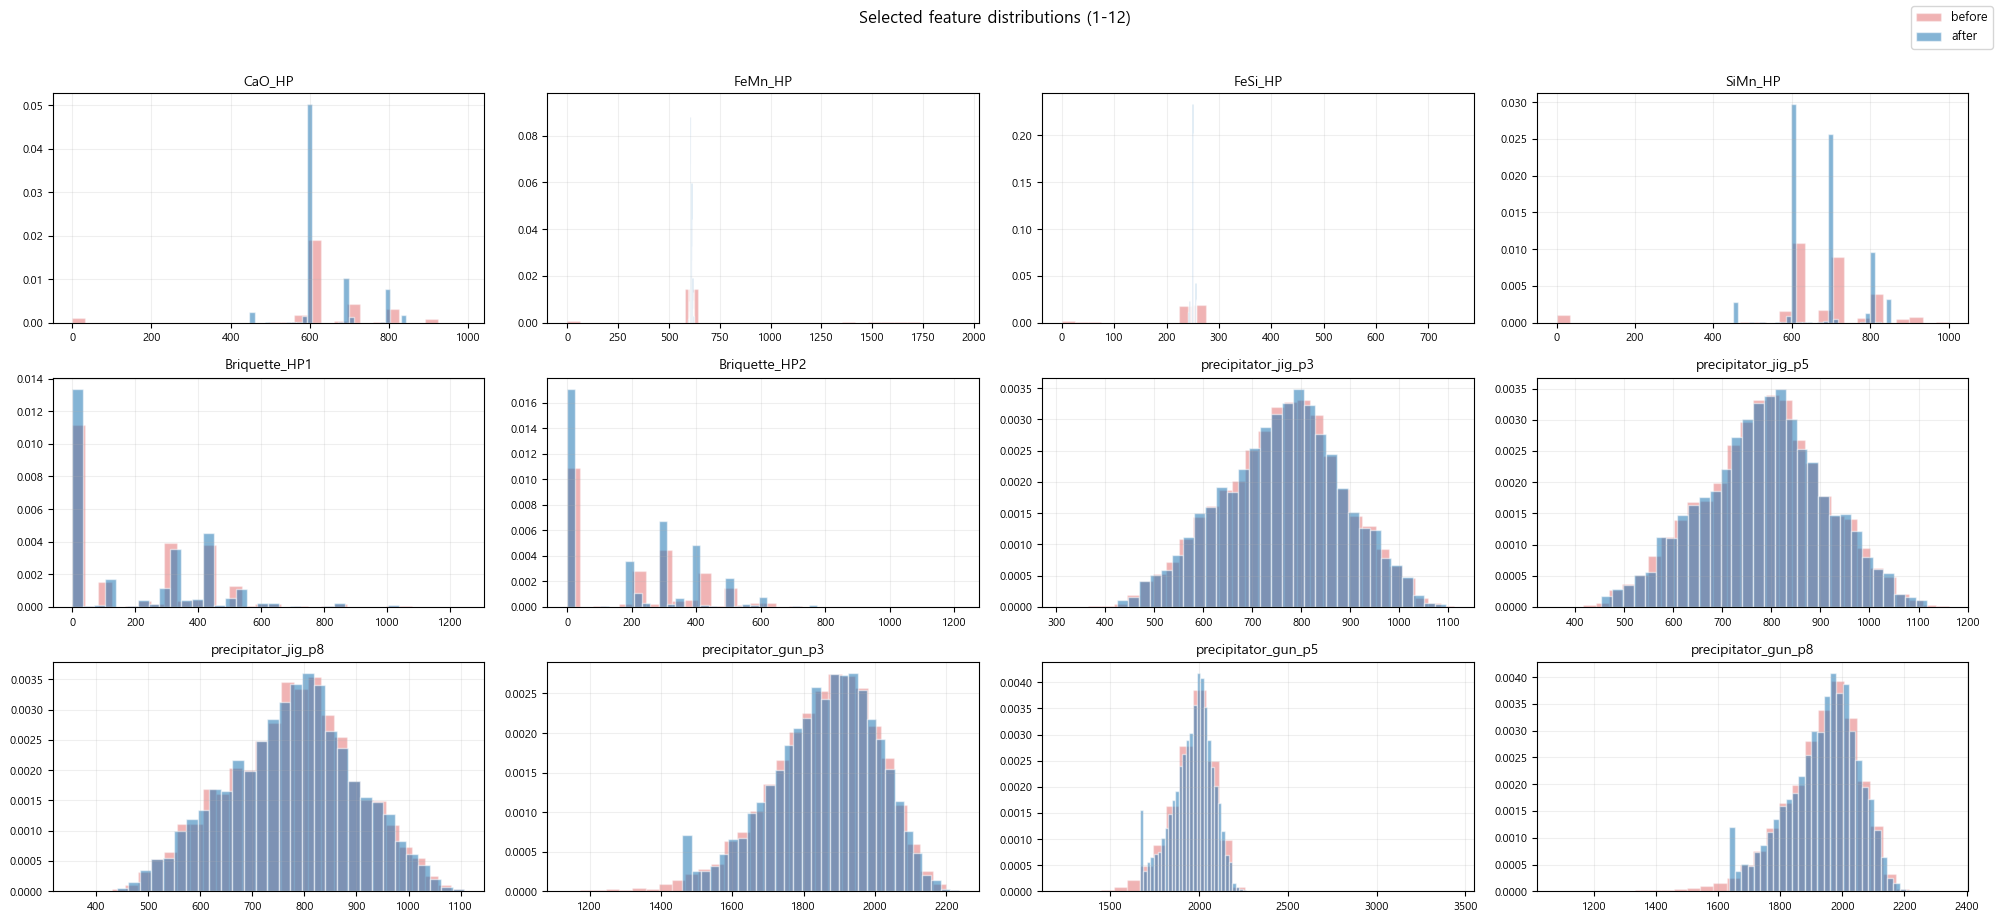

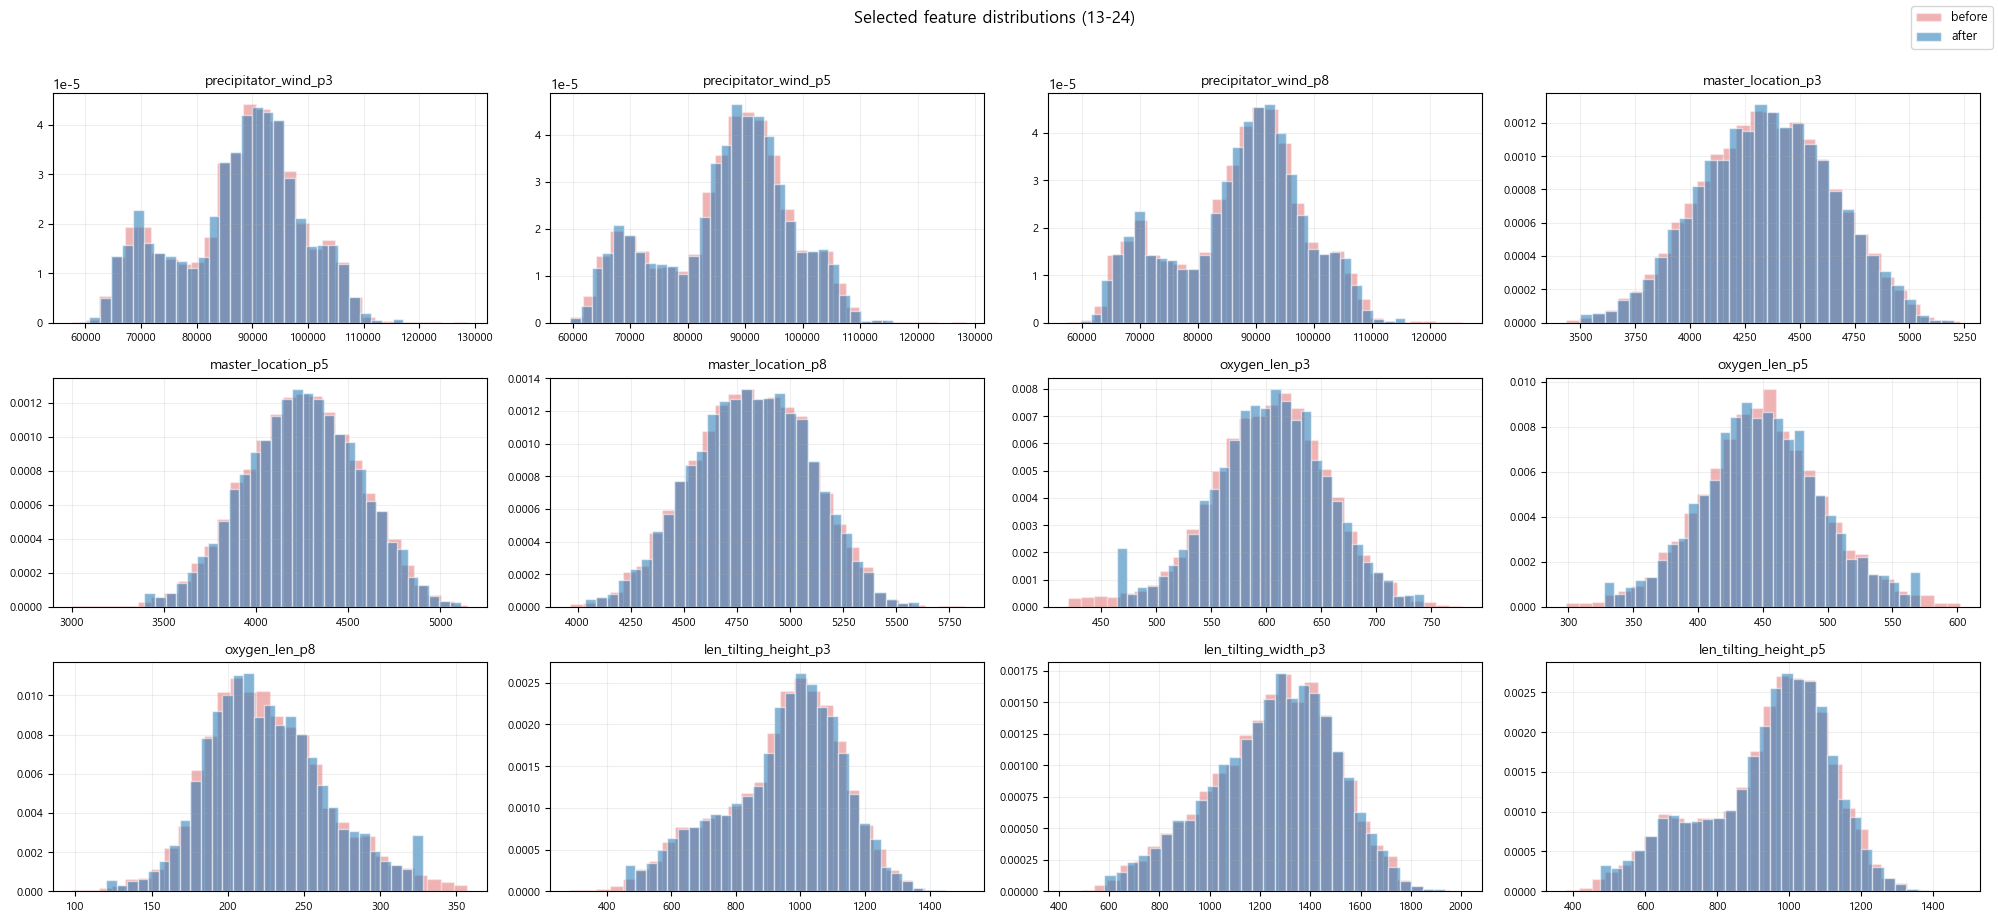

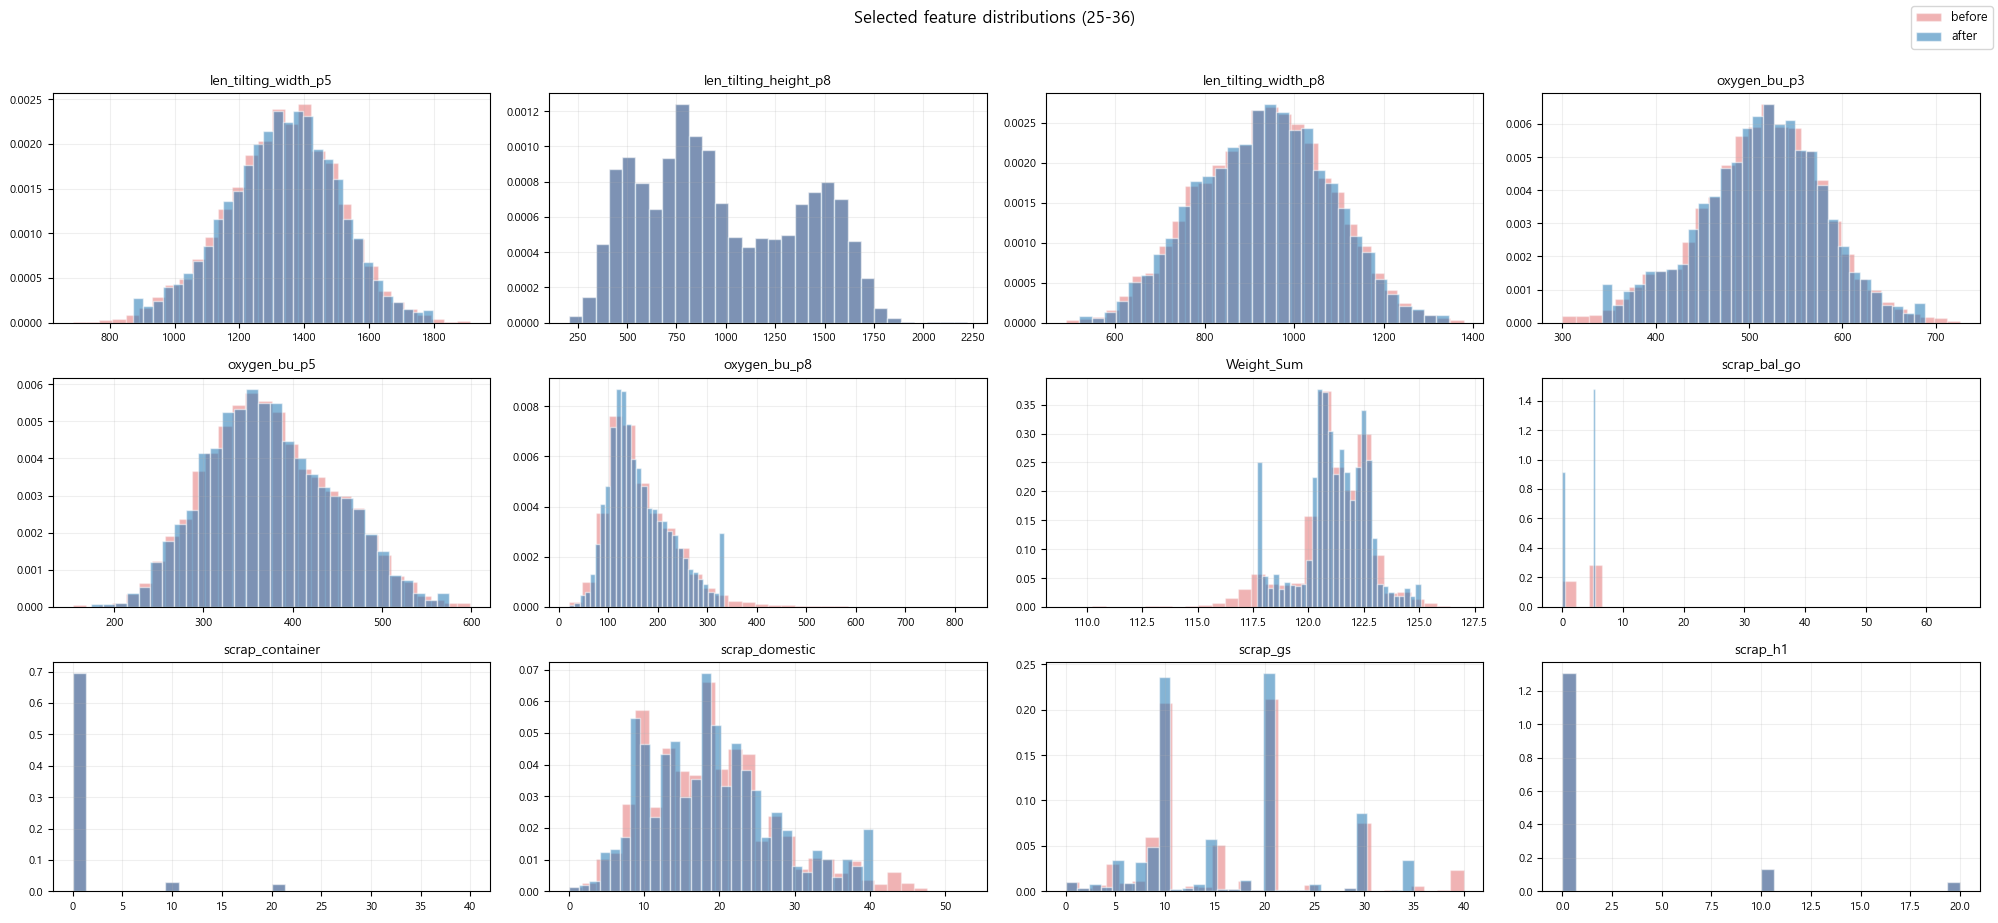

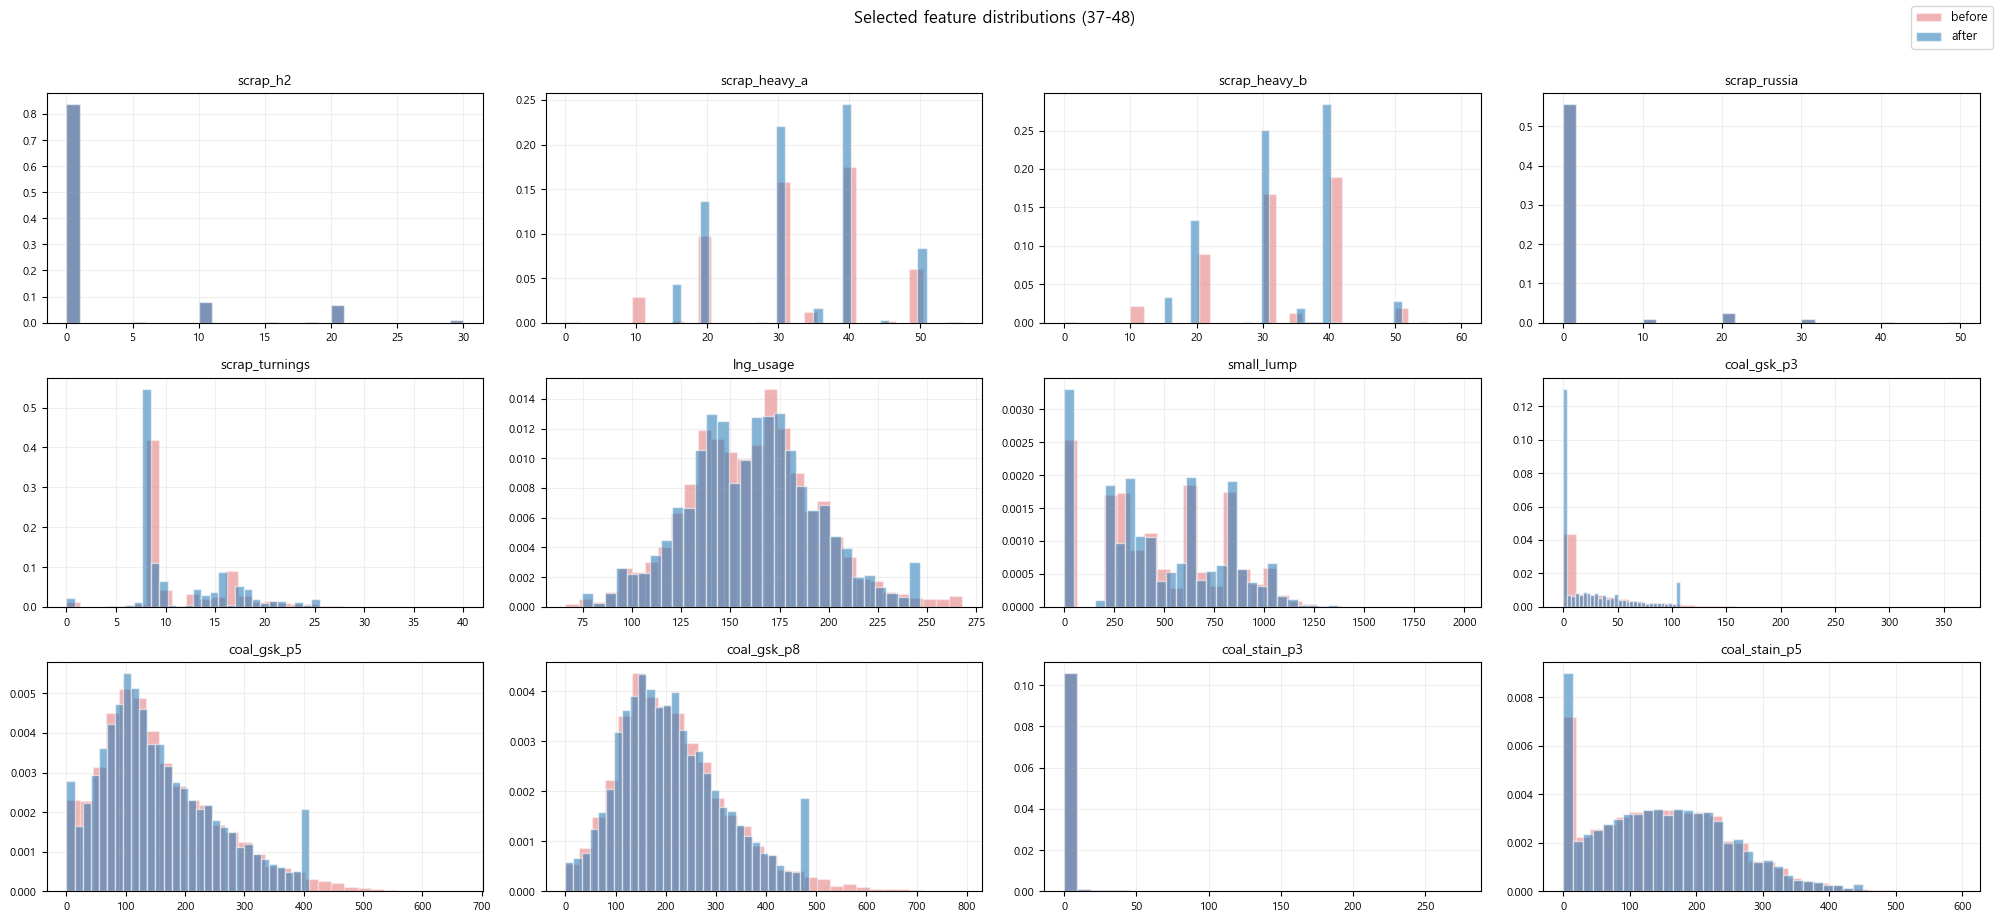

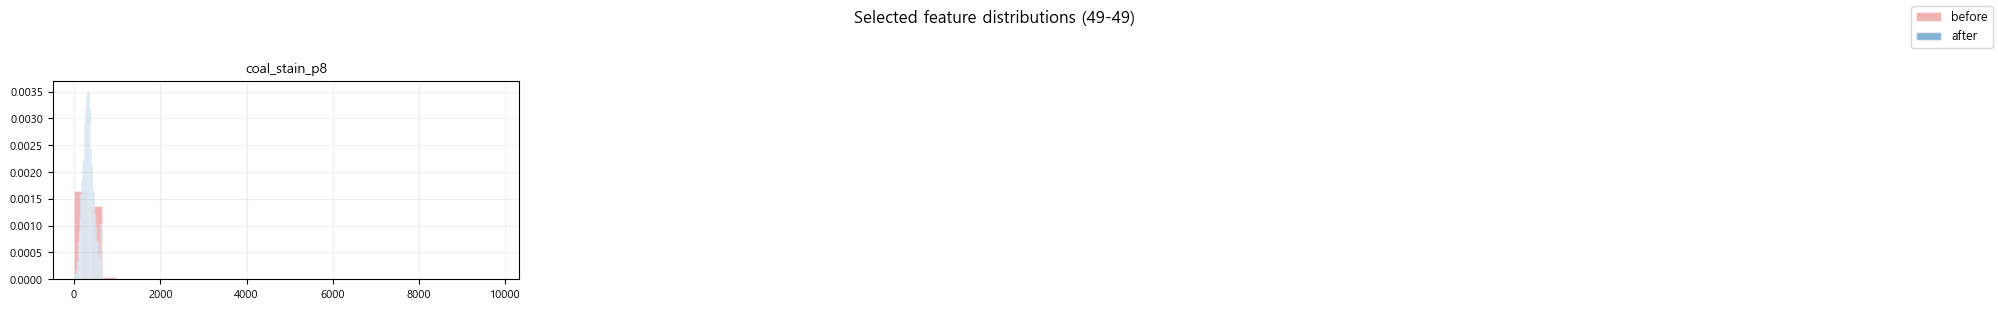

In [5]:
# Selected feature distribution summary and visualizations
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _safe_display(df):
    try:
        display(df)
    except NameError:
        print(df.to_string())

numeric_features = [c for c in SELECTED_FEATURES if pd.api.types.is_numeric_dtype(X[c])]
non_numeric_features = [c for c in SELECTED_FEATURES if c not in numeric_features]

if not numeric_features:
    raise ValueError('No numeric features found in SELECTED_FEATURES.')

if non_numeric_features:
    print(f"Skipped non-numeric features: {non_numeric_features}")

# After-filter summary
dist_summary_after = X[numeric_features].describe(
    percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
).T

dist_summary_after['missing'] = X[numeric_features].isna().sum()
dist_summary_after['missing_pct'] = dist_summary_after['missing'] / len(X) * 100
dist_summary_after['zero_pct'] = (X[numeric_features] == 0).sum() / len(X) * 100

summary_cols = [
    'count', 'mean', 'std', 'min', '1%', '5%', '25%', '50%', '75%', '95%', '99%', 'max',
    'missing', 'missing_pct', 'zero_pct'
]
dist_summary_after = dist_summary_after[summary_cols]

print('Feature distribution summary (after outlier handling):')
_safe_display(dist_summary_after.round(3))

# Before-vs-after min/max/range comparison
X_before = None
compare_summary = pd.DataFrame()
if 'df_model_before_outlier' in globals():
    X_before = df_model_before_outlier[SELECTED_FEATURES]
    numeric_compare = [
        c for c in numeric_features
        if c in X_before.columns and pd.api.types.is_numeric_dtype(X_before[c])
    ]

    compare_summary = pd.DataFrame(index=numeric_compare)
    compare_summary['count_before'] = X_before[numeric_compare].count()
    compare_summary['count_after'] = X[numeric_compare].count()

    compare_summary['min_before'] = X_before[numeric_compare].min()
    compare_summary['min_after'] = X[numeric_compare].min()
    compare_summary['max_before'] = X_before[numeric_compare].max()
    compare_summary['max_after'] = X[numeric_compare].max()

    compare_summary['range_before'] = compare_summary['max_before'] - compare_summary['min_before']
    compare_summary['range_after'] = compare_summary['max_after'] - compare_summary['min_after']
    compare_summary['range_delta'] = compare_summary['range_after'] - compare_summary['range_before']

    compare_summary['mean_before'] = X_before[numeric_compare].mean()
    compare_summary['mean_after'] = X[numeric_compare].mean()
    compare_summary['mean_delta'] = compare_summary['mean_after'] - compare_summary['mean_before']

    compare_summary = compare_summary.sort_values('range_delta')

    print('\nMin/Max and range change (before -> after):')
    _safe_display(compare_summary.round(3))

# Histograms (overlay before/after if baseline exists)
features_per_fig = 12
n_cols = 4

for start in range(0, len(numeric_features), features_per_fig):
    subset = numeric_features[start:start + features_per_fig]
    n_rows = math.ceil(len(subset) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows))
    axes = np.atleast_1d(axes).ravel()

    for ax, col in zip(axes, subset):
        vals_after = X[col].dropna()

        if X_before is not None and col in X_before.columns:
            vals_before = X_before[col].dropna()
            ax.hist(vals_before, bins=30, density=True, color='#d62728', alpha=0.35, edgecolor='white', label='before')
            ax.hist(vals_after, bins=30, density=True, color='#1f77b4', alpha=0.55, edgecolor='white', label='after')
        else:
            ax.hist(vals_after, bins=30, color='#1f77b4', alpha=0.85, edgecolor='white', label='after')

        ax.set_title(col, fontsize=10)
        ax.tick_params(axis='both', labelsize=8)
        ax.grid(alpha=0.2)

    for ax in axes[len(subset):]:
        ax.axis('off')

    if X_before is not None:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper right', fontsize=9)

    fig.suptitle(
        f"Selected feature distributions ({start + 1}-{start + len(subset)})",
        y=1.02,
        fontsize=12,
    )
    plt.tight_layout()
    plt.show()





In [28]:
# 클리핑 비율 확인 코드 (before/after 직접 비교)
import numpy as np
import pandas as pd

# 전제: 이상치 처리 전에 만든 원본 복사본과 처리 후 df가 있어야 함
# - df_model_before_outlier: 클리핑 전
# - df_model: 클리핑 후
if "df_model_before_outlier" not in globals():
    raise RuntimeError("df_model_before_outlier가 없습니다. 클리핑 전 복사본 생성 셀을 먼저 실행하세요.")
if "df_model" not in globals():
    raise RuntimeError("df_model이 없습니다. 이상치 처리 셀을 먼저 실행하세요.")

before = df_model_before_outlier.reset_index(drop=True)
after = df_model.reset_index(drop=True)

# 비교할 컬럼(숫자형 + 공통 컬럼)
cols = [c for c in before.columns if c in after.columns and pd.api.types.is_numeric_dtype(before[c])]

# float 비교 오차 허용
ATOL = 1e-12
change_masks = {
    c: ~np.isclose(before[c].to_numpy(dtype=float), after[c].to_numpy(dtype=float), rtol=0.0, atol=ATOL)
    for c in cols
}

# 컬럼별 클리핑 비율
summary = pd.DataFrame({
    "feature": cols,
    "clipped_count": [m.sum() for m in change_masks.values()],
})
summary["clipped_pct"] = summary["clipped_count"] / len(before) * 100
summary = summary.sort_values("clipped_pct", ascending=False).reset_index(drop=True)

# 전체 요약
row_changed = np.column_stack(list(change_masks.values())).any(axis=1)
total_changed_cells = int(sum(m.sum() for m in change_masks.values()))
total_cells = len(before) * len(cols)

print(f"[행 기준] 한 번이라도 클리핑된 행: {row_changed.sum()} / {len(before)} ({row_changed.mean()*100:.2f}%)")
print(f"[셀 기준] 클리핑된 값: {total_changed_cells} / {total_cells} ({total_changed_cells/total_cells*100:.2f}%)")

# 클리핑 발생한 컬럼만 보기
display(summary[summary["clipped_count"] > 0][["feature", "clipped_count", "clipped_pct"]].round(3))


[행 기준] 한 번이라도 클리핑된 행: 4566 / 8950 (51.02%)
[셀 기준] 클리핑된 값: 7897 / 796550 (0.99%)


feature  clipped_count  clipped_pct
0                 FeSi_HP            980       10.950
1                 FeMn_HP            749        8.369
2                 SiMn_HP            709        7.922
3                  CaO_HP            501        5.598
4              Weight_Sum            501        5.598
5           scrap_heavy_a            499        5.575
6             coal_gsk_p3            432        4.827
7           scrap_heavy_b            398        4.447
8                scrap_gs            299        3.341
9            oxygen_bu_p8            238        2.659
10    precipitator_gun_p5            231        2.581
11            coal_gsk_p8            228        2.547
12            coal_gsk_p5            200        2.235
13         scrap_domestic            198        2.212
14    precipitator_gun_p8            187        2.089
15          coal_stain_p8            172        1.922
16          oxygen_len_p3            168        1.877
17          oxygen_len_p8            152        1.698
18              lng_usage            136        1.520
19          oxygen_len_p5            128        1.430
20    precipitator_gun_p3            121        1.352
21           oxygen_bu_p3            118        1.318
22         scrap_turnings            113        1.263
23   len_tilting_width_p5             67        0.749
24  len_tilting_height_p3             51        0.570
25  len_tilting_height_p5             35        0.391
26          Briquette_HP2             34        0.380
27           oxygen_bu_p5             31        0.346
28          coal_stain_p5             28        0.313
29     master_location_p5             24        0.268
30   len_tilting_width_p3             23        0.257
31    precipitator_jig_p5             22        0.246
32          Briquette_HP1             21        0.235
33     master_location_p8             19        0.212
34   len_tilting_width_p8             18        0.201
35   precipitator_wind_p8             15        0.168
36     master_location_p3             12        0.134
37           scrap_bal_go             10        0.112
38   precipitator_wind_p5             10        0.112
39    precipitator_jig_p3              8        0.089
40   precipitator_wind_p3              7        0.078
41    precipitator_jig_p8              3        0.034
42             small_lump              1        0.011

In [30]:
import numpy as np
import pandas as pd
import pyodbc

DB_CONFIG = {
    "driver": "ODBC Driver 17 for SQL Server",
    "server": "localhost",
    "database": "real_data",
    "trusted_connection": "yes",
}

conn_str = (
    f"DRIVER={{{DB_CONFIG['driver']}}};"
    f"SERVER={DB_CONFIG['server']};"
    f"DATABASE={DB_CONFIG['database']};"
    f"Trusted_Connection={DB_CONFIG['trusted_connection']};"
    "TrustServerCertificate=yes;"
)

conn = pyodbc.connect(conn_str)
df = pd.read_sql(
    "SELECT Weight_Sum, precipitator_gun_p8,wattage_tmp FROM union_charge_divided_by_pattern",
    conn
)
conn.close()

def calc_stats(series):
    s = series.dropna().to_numpy()
    if len(s) == 0:
        return None
    uniq = np.unique(s)
    step = None
    if len(uniq) >= 3:
        diffs = np.diff(np.sort(uniq))
        diffs = diffs[diffs > 0]
        step = float(np.min(diffs)) if len(diffs) else None
    return {
        "min": float(np.min(s)),
        "max": float(np.max(s)),
        "step": step,
        "mean": float(np.mean(s)),
        "median": float(np.median(s)),
    }

result = [
    {"key": "Weight_Sum", **calc_stats(df["Weight_Sum"])},
    {"key": "precipitator_gun_p8", **calc_stats(df["precipitator_gun_p8"])},
    {"key": "wattage_tmp", **calc_stats(df["wattage_tmp"])},
]

result


[{'key': 'Weight_Sum',
  'min': 109.05,
  'max': 127.0,
  'step': 0.009999999999990905,
  'mean': 121.11679888268158,
  'median': 121.25},
 {'key': 'precipitator_gun_p8',
  'min': 1080.7,
  'max': 2342.46,
  'step': 0.009999999999763531,
  'mean': 1932.4161452513968,
  'median': 1952.18},
 {'key': 'wattage_tmp',
  'min': 40800.0,
  'max': 53000.0,
  'step': 100.0,
  'mean': 44923.262569832405,
  'median': 44900.0}]

In [32]:
# 클리핑 비율 확인 코드 (before/after 직접 비교)
import numpy as np
import pandas as pd

# 전제: 이상치 처리 전에 만든 원본 복사본과 처리 후 df가 있어야 함
# - df_model_before_outlier: 클리핑 전
# - df_model: 클리핑 후
if "df_model_before_outlier" not in globals():
    raise RuntimeError("df_model_before_outlier가 없습니다. 클리핑 전 복사본 생성 셀을 먼저 실행하세요.")
if "df_model" not in globals():
    raise RuntimeError("df_model이 없습니다. 이상치 처리 셀을 먼저 실행하세요.")

before = df_model_before_outlier.reset_index(drop=True)
after = df_model.reset_index(drop=True)

# 비교할 컬럼(숫자형 + 공통 컬럼)
cols = [c for c in before.columns if c in after.columns and pd.api.types.is_numeric_dtype(before[c])]

# float 비교 오차 허용
ATOL = 1e-12
change_masks = {
    c: ~np.isclose(before[c].to_numpy(dtype=float), after[c].to_numpy(dtype=float), rtol=0.0, atol=ATOL)
    for c in cols
}

# 컬럼별 클리핑 비율
summary = pd.DataFrame({
    "feature": cols,
    "clipped_count": [m.sum() for m in change_masks.values()],
})
summary["clipped_pct"] = summary["clipped_count"] / len(before) * 100
summary = summary.sort_values("clipped_pct", ascending=False).reset_index(drop=True)

# 전체 요약
row_changed = np.column_stack(list(change_masks.values())).any(axis=1)
total_changed_cells = int(sum(m.sum() for m in change_masks.values()))
total_cells = len(before) * len(cols)

print(f"[행 기준] 한 번이라도 클리핑된 행: {row_changed.sum()} / {len(before)} ({row_changed.mean()*100:.2f}%)")
print(f"[셀 기준] 클리핑된 값: {total_changed_cells} / {total_cells} ({total_changed_cells/total_cells*100:.2f}%)")

# 클리핑 발생한 컬럼만 보기
display(summary[summary["clipped_count"] > 0][["feature", "clipped_count", "clipped_pct"]].round(3))


[행 기준] 한 번이라도 클리핑된 행: 4566 / 8950 (51.02%)
[셀 기준] 클리핑된 값: 7897 / 796550 (0.99%)


feature  clipped_count  clipped_pct
0                 FeSi_HP            980       10.950
1                 FeMn_HP            749        8.369
2                 SiMn_HP            709        7.922
3                  CaO_HP            501        5.598
4              Weight_Sum            501        5.598
5           scrap_heavy_a            499        5.575
6             coal_gsk_p3            432        4.827
7           scrap_heavy_b            398        4.447
8                scrap_gs            299        3.341
9            oxygen_bu_p8            238        2.659
10    precipitator_gun_p5            231        2.581
11            coal_gsk_p8            228        2.547
12            coal_gsk_p5            200        2.235
13         scrap_domestic            198        2.212
14    precipitator_gun_p8            187        2.089
15          coal_stain_p8            172        1.922
16          oxygen_len_p3            168        1.877
17          oxygen_len_p8            152        1.698
18              lng_usage            136        1.520
19          oxygen_len_p5            128        1.430
20    precipitator_gun_p3            121        1.352
21           oxygen_bu_p3            118        1.318
22         scrap_turnings            113        1.263
23   len_tilting_width_p5             67        0.749
24  len_tilting_height_p3             51        0.570
25  len_tilting_height_p5             35        0.391
26          Briquette_HP2             34        0.380
27           oxygen_bu_p5             31        0.346
28          coal_stain_p5             28        0.313
29     master_location_p5             24        0.268
30   len_tilting_width_p3             23        0.257
31    precipitator_jig_p5             22        0.246
32          Briquette_HP1             21        0.235
33     master_location_p8             19        0.212
34   len_tilting_width_p8             18        0.201
35   precipitator_wind_p8             15        0.168
36     master_location_p3             12        0.134
37           scrap_bal_go             10        0.112
38   precipitator_wind_p5             10        0.112
39    precipitator_jig_p3              8        0.089
40   precipitator_wind_p3              7        0.078
41    precipitator_jig_p8              3        0.034
42             small_lump              1        0.011

In [7]:
# 데이터 분할 (학습, 테스트 각각 0.8, 0.2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
    
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain y 데이터 통계:")
print(y_train.describe())
print(f"\nTest y 데이터 통계:")
print(y_test.describe())

Train set: (7160, 49)
Test set: (1790, 49)

Train y 데이터 통계:
       refining_wattage_tmp
count           7160.000000
mean            8116.634078
std             1382.008236
min             3200.000000
25%             7100.000000
50%             8000.000000
75%             9000.000000
max            14900.000000

Test y 데이터 통계:
       refining_wattage_tmp
count           1790.000000
mean            8216.536313
std             1397.800421
min             4400.000000
25%             7200.000000
50%             8100.000000
75%             9100.000000
max            14200.000000


In [8]:
# ===== 하이퍼파라미터 설정 + best_n 선택 + 클러스터별 학습 (붙여넣기용 전체) =====
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.mixture import GaussianMixture
import xgboost as xgb
import numpy as np

# 필수 데이터 체크
if "X" not in globals() or "y" not in globals():
    raise RuntimeError("Run the data prep cells (target/features) before this cell.")

# train/test가 없으면 생성
if "X_train" not in globals() or X_train is None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

# n 범위
N_RANGE = range(2, 8)
n_range = N_RANGE

# GMM 설정 (첫 블록과 동일하게 고정)
GMM_KWARGS = {
    "covariance_type": "diag",
    "reg_covar": 1e-6,
    "n_init": 3,
}

USE_GPU = True
params = {
    "objective": "reg:squarederror",
    "random_state": 42,
    "tree_method": "hist",
    "device": "cuda" if USE_GPU else "cpu",
    "sampling_method": "gradient_based",  # GPU 전용
    "max_bin": 256,
    "max_depth": 6,
    "learning_rate": 0.01223826357909319,
    "n_estimators": 800,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "min_child_weight": 6,
    "gamma": 5.0,
    "reg_alpha": 1.0,
    "reg_lambda": 6.0,
    "eval_metric": "rmse",
}

# CPU로 바꿀 때 GPU 전용 옵션 제거
if not USE_GPU:
    params.pop("sampling_method", None)

# ===== Validation 기반 best_n 선택 (R2 max -> SMAPE min) =====
X_tr2, X_val, y_tr2, y_val = train_test_split(
    X_train, y_train.values.ravel(), test_size=0.2, random_state=42
)

best_n_perf = None
best_r2 = -float("inf")
best_smape = float("inf")
metrics_by_n = {}

for n in n_range:
    gmm_tmp = GaussianMixture(n_components=n, random_state=42, **GMM_KWARGS)
    tr_clusters = gmm_tmp.fit_predict(X_tr2.values)
    val_clusters = gmm_tmp.predict(X_val.values)

    y_val_pred = np.empty(len(X_val))
    for c_id in range(n):
        tr_mask = tr_clusters == c_id
        val_mask = val_clusters == c_id
        if tr_mask.sum() > 0 and val_mask.sum() > 0:
            m = xgb.XGBRegressor(**params)
            m.fit(X_tr2[tr_mask], y_tr2[tr_mask], verbose=False)
            y_val_pred[val_mask] = m.predict(X_val[val_mask])
        else:
            y_val_pred[val_mask] = y_tr2.mean()

    r2 = r2_score(y_val, y_val_pred)
    smape = 100 / len(y_val) * np.sum(
        2 * np.abs(y_val_pred - y_val) / (np.abs(y_val) + np.abs(y_val_pred) + 1e-9)
    )

    metrics_by_n[n] = (r2, smape)
    if (r2 > best_r2) or (r2 == best_r2 and smape < best_smape):
        best_r2 = r2
        best_smape = smape
        best_n_perf = n

print("\nValidation metrics by n:")
for n, (r2, smape) in metrics_by_n.items():
    print(f"  n={n}: R2={r2:.4f}, SMAPE={smape:.2f}%")
print(f"Selected best_n by R2->SMAPE: {best_n_perf} (R2={best_r2:.4f}, SMAPE={best_smape:.2f}%)")

# ===== 최종 best_n =====
best_n = best_n_perf
print(f"Final best_n (R2): {best_n}")

# ===== GMM clustering using selected n =====
gmm = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
train_clusters = gmm.fit_predict(X_train.values)
test_clusters = gmm.predict(X_test.values)

print(f"최적 클러스터 수: {best_n}")
for c in range(best_n):
    print(f"  Cluster {c}: Train {(train_clusters == c).sum()}건, Test {(test_clusters == c).sum()}건")

# 클러스터별 모델 학습
models = {}
for c in range(best_n):
    train_mask = train_clusters == c
    X_c = X_train[train_mask]
    y_c = y_train.values.ravel()[train_mask]

    if len(X_c) > 0:
        model_c = xgb.XGBRegressor(**params)
        model_c.fit(X_c, y_c, verbose=False)
        models[c] = model_c
        print(f"[Cluster {c}] 학습 완료 - 데이터: {len(X_c)}건")

print("\n모델 학습 완료!")



Validation metrics by n:
  n=2: R2=0.7069, SMAPE=7.12%
  n=3: R2=0.7032, SMAPE=7.15%
  n=4: R2=0.7075, SMAPE=7.13%
  n=5: R2=0.7086, SMAPE=7.06%
  n=6: R2=0.7069, SMAPE=7.14%
  n=7: R2=0.7037, SMAPE=7.19%
Selected best_n by R2->SMAPE: 5 (R2=0.7086, SMAPE=7.06%)
Final best_n (R2): 5
최적 클러스터 수: 5
  Cluster 0: Train 357건, Test 114건
  Cluster 1: Train 906건, Test 202건
  Cluster 2: Train 1131건, Test 270건
  Cluster 3: Train 4515건, Test 1156건
  Cluster 4: Train 251건, Test 48건
[Cluster 0] 학습 완료 - 데이터: 357건
[Cluster 1] 학습 완료 - 데이터: 906건
[Cluster 2] 학습 완료 - 데이터: 1131건
[Cluster 3] 학습 완료 - 데이터: 4515건
[Cluster 4] 학습 완료 - 데이터: 251건

모델 학습 완료!



[Cluster 0] SHAP 평균 중요도 Top 20
                 feature  mean_abs_shap
20         oxygen_len_p8     344.684387
48         coal_stain_p8     338.444031
34              scrap_gs     132.934021
45           coal_gsk_p8     122.653358
42            small_lump     108.960609
0                 CaO_HP     108.372650
19         oxygen_len_p5      94.951439
41             lng_usage      76.258644
18         oxygen_len_p3      72.586143
29          oxygen_bu_p8      57.617882
28          oxygen_bu_p5      50.540672
22  len_tilting_width_p3      49.099091
11   precipitator_gun_p8      44.683220
24  len_tilting_width_p5      33.699181
44           coal_gsk_p5      31.896521
43           coal_gsk_p3      30.673521
3                SiMn_HP      30.386732
13  precipitator_wind_p5      29.460314
30            Weight_Sum      26.550446
9    precipitator_gun_p3      26.495802


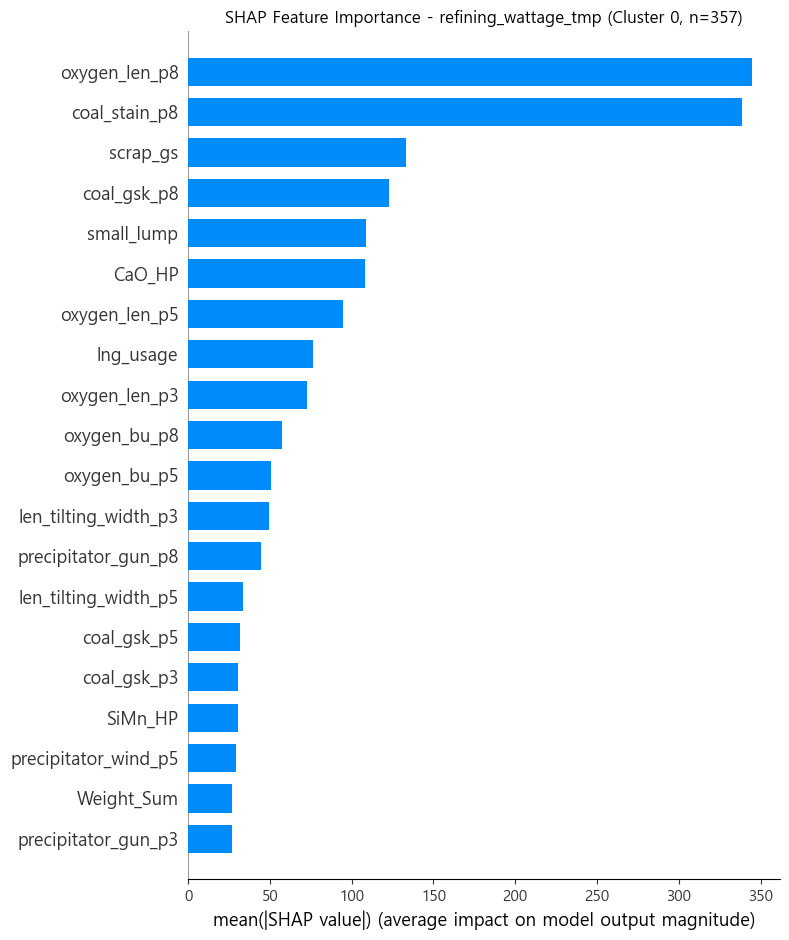

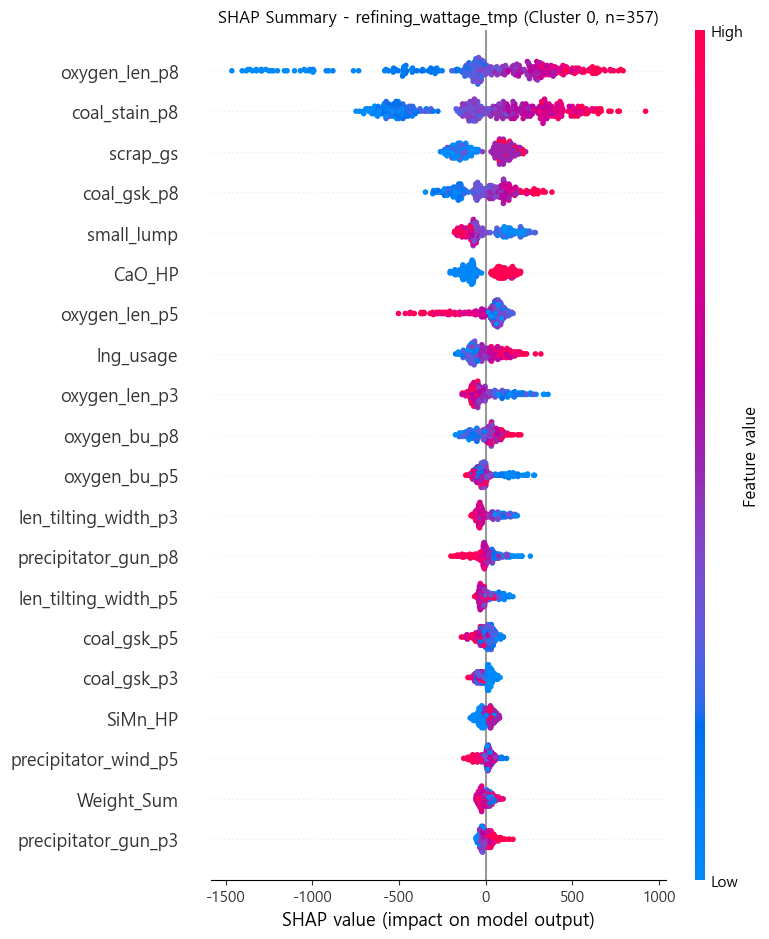


[Cluster 1] SHAP 평균 중요도 Top 20
                  feature  mean_abs_shap
48          coal_stain_p8     319.664124
20          oxygen_len_p8     311.326874
45            coal_gsk_p8     104.056824
42             small_lump      93.376213
47          coal_stain_p5      90.325058
26   len_tilting_width_p8      71.244774
19          oxygen_len_p5      67.042908
28           oxygen_bu_p5      66.305649
11    precipitator_gun_p8      66.203300
16     master_location_p5      53.694016
17     master_location_p8      50.380692
23  len_tilting_height_p5      45.870277
29           oxygen_bu_p8      40.583096
30             Weight_Sum      36.799549
22   len_tilting_width_p3      35.065125
33         scrap_domestic      33.358418
5           Briquette_HP2      32.962162
44            coal_gsk_p5      28.134205
9     precipitator_gun_p3      25.727535
10    precipitator_gun_p5      24.832813


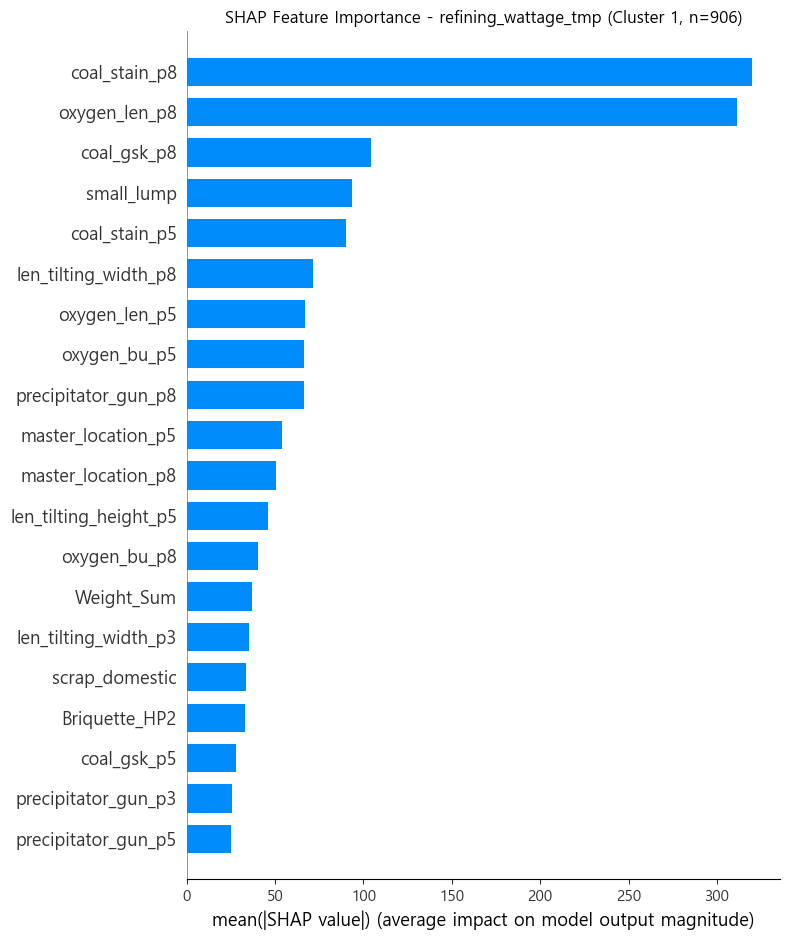

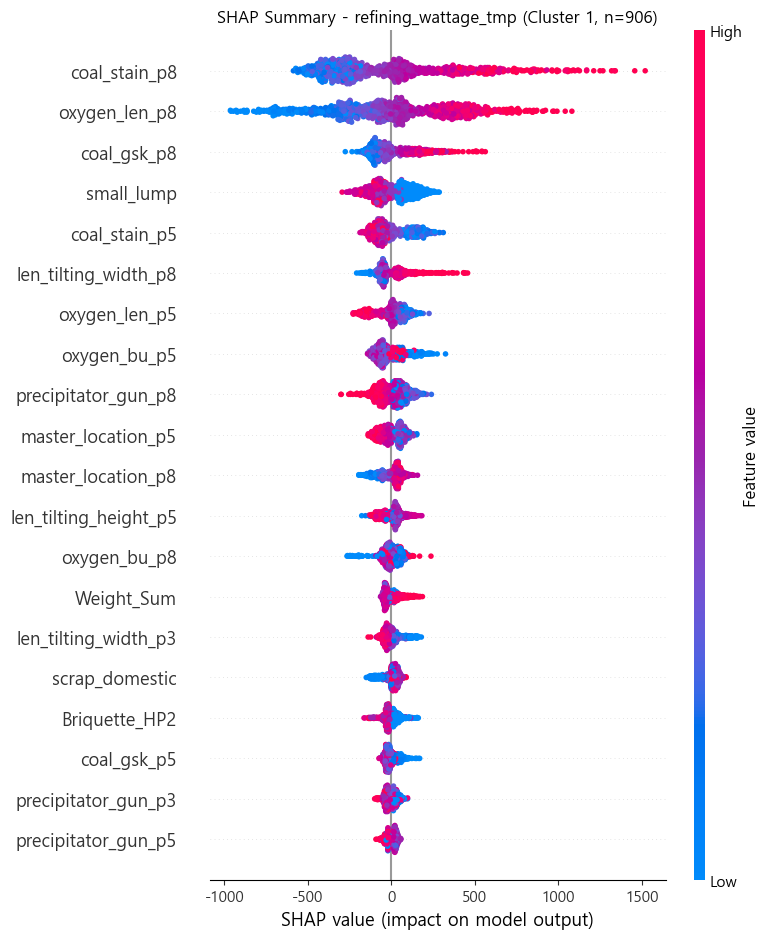


[Cluster 2] SHAP 평균 중요도 Top 20
                  feature  mean_abs_shap
20          oxygen_len_p8     365.792236
48          coal_stain_p8     325.110291
45            coal_gsk_p8     106.111359
27           oxygen_bu_p3      99.375740
22   len_tilting_width_p3      96.513840
23  len_tilting_height_p5      80.950630
11    precipitator_gun_p8      78.159737
19          oxygen_len_p5      75.897774
29           oxygen_bu_p8      64.202438
42             small_lump      51.797615
26   len_tilting_width_p8      50.815716
47          coal_stain_p5      42.079849
30             Weight_Sum      38.676804
36               scrap_h2      35.540955
28           oxygen_bu_p5      34.283161
17     master_location_p8      29.671682
41              lng_usage      29.280304
33         scrap_domestic      23.936888
25  len_tilting_height_p8      23.308586
16     master_location_p5      20.613314


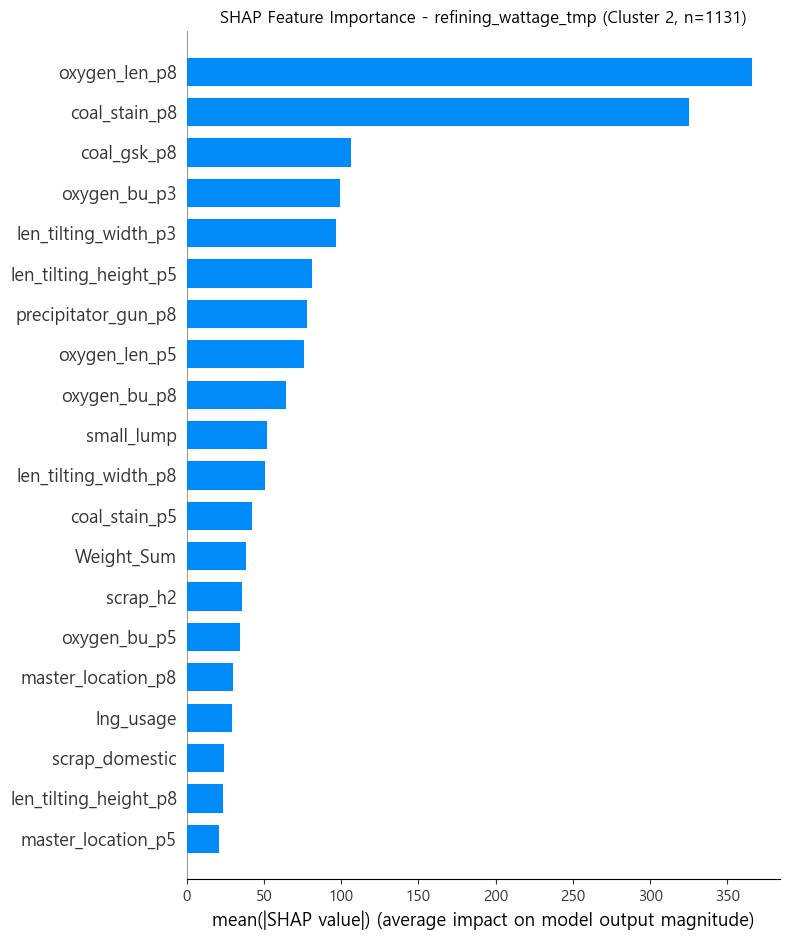

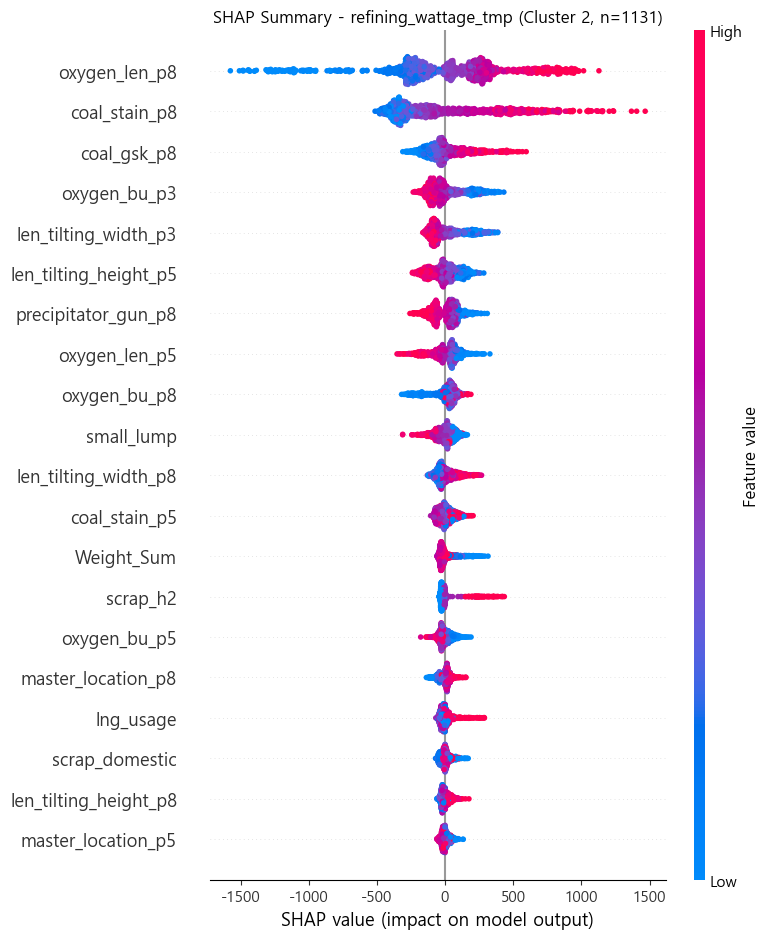


[Cluster 3] SHAP 평균 중요도 Top 20
                  feature  mean_abs_shap
20          oxygen_len_p8     419.703827
48          coal_stain_p8     341.238373
45            coal_gsk_p8     204.027267
29           oxygen_bu_p8     118.522423
11    precipitator_gun_p8     109.273003
19          oxygen_len_p5      91.938980
28           oxygen_bu_p5      86.690483
25  len_tilting_height_p8      85.385345
41              lng_usage      56.962936
4           Briquette_HP1      56.330589
42             small_lump      48.593918
27           oxygen_bu_p3      48.345650
18          oxygen_len_p3      38.760204
10    precipitator_gun_p5      38.299717
47          coal_stain_p5      36.668774
44            coal_gsk_p5      36.596352
17     master_location_p8      35.198513
22   len_tilting_width_p3      32.004864
5           Briquette_HP2      28.229103
24   len_tilting_width_p5      25.144136


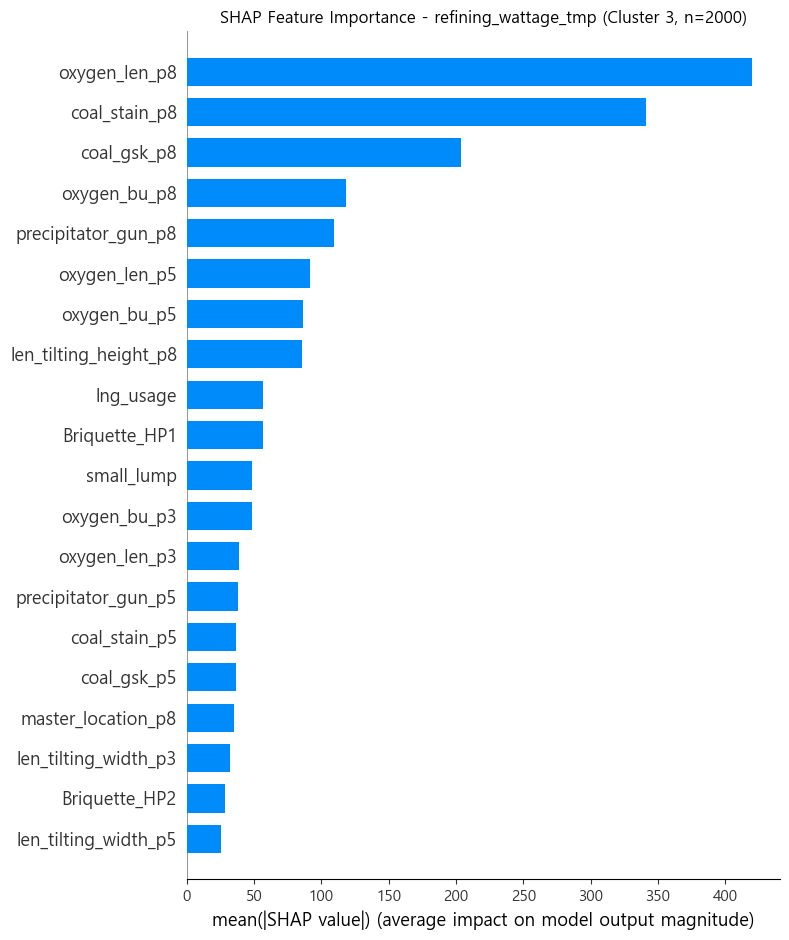

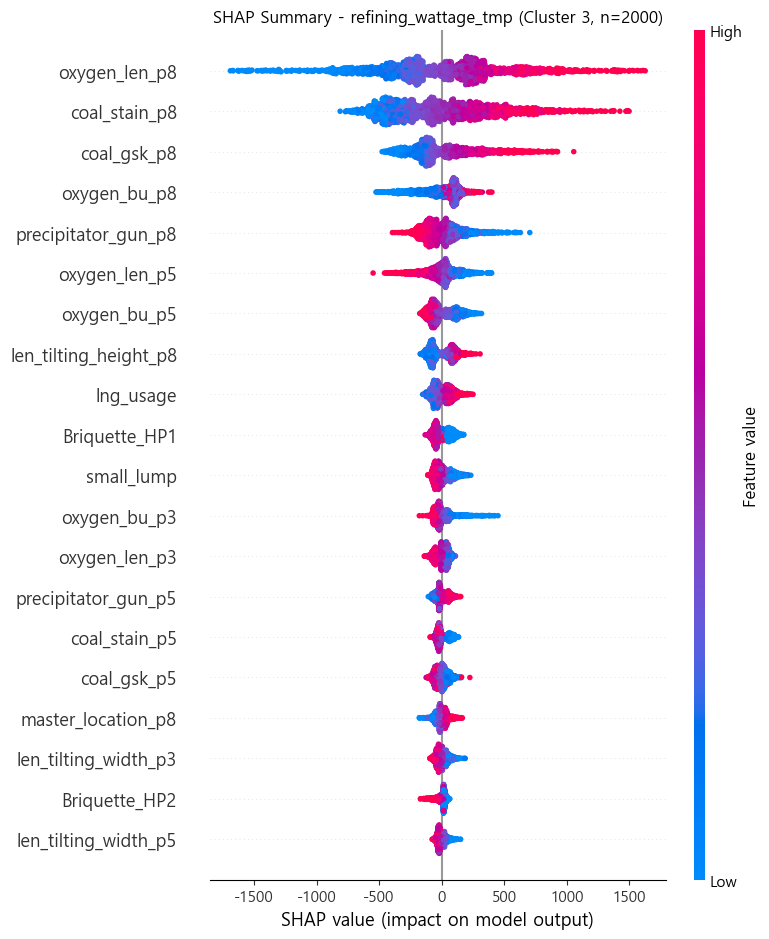


[Cluster 4] SHAP 평균 중요도 Top 20
                  feature  mean_abs_shap
20          oxygen_len_p8     454.051056
48          coal_stain_p8     254.729965
28           oxygen_bu_p5     196.187881
45            coal_gsk_p8     165.450867
19          oxygen_len_p5     100.338135
47          coal_stain_p5      99.718155
29           oxygen_bu_p8      91.120399
44            coal_gsk_p5      65.242447
11    precipitator_gun_p8      63.136028
21  len_tilting_height_p3      59.756287
22   len_tilting_width_p3      55.301636
18          oxygen_len_p3      44.784313
26   len_tilting_width_p8      42.654057
41              lng_usage      40.559319
43            coal_gsk_p3      33.273201
1                 FeMn_HP      29.562477
9     precipitator_gun_p3      27.478142
17     master_location_p8      27.325411
0                  CaO_HP      26.699554
42             small_lump      24.688139


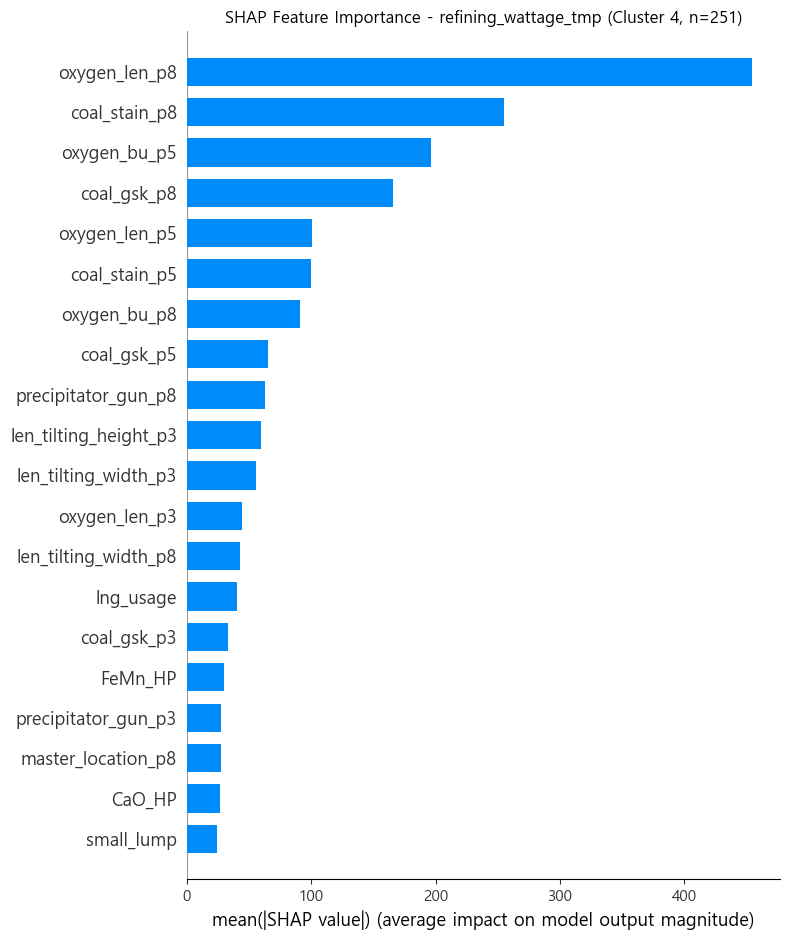

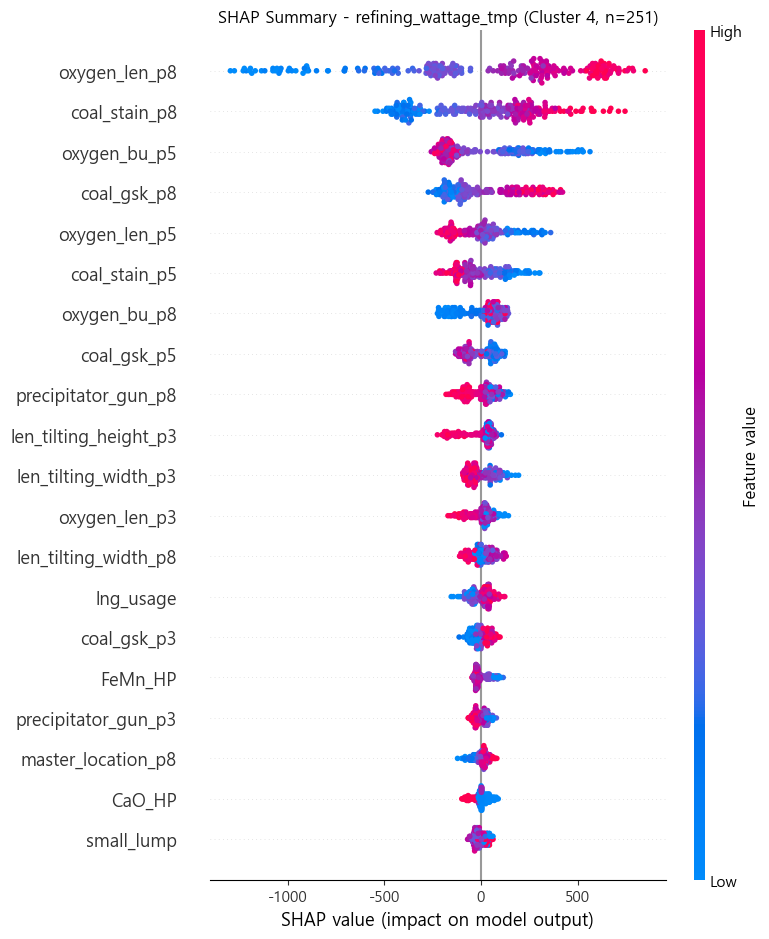


[전체] SHAP 평균 중요도 Top 20
                  feature  mean_abs_shap
20          oxygen_len_p8     381.528503
48          coal_stain_p8     328.213379
45            coal_gsk_p8     152.347961
11    precipitator_gun_p8      85.839371
29           oxygen_bu_p8      83.932602
19          oxygen_len_p5      83.862617
28           oxygen_bu_p5      73.092361
42             small_lump      61.456539
27           oxygen_bu_p3      51.274784
22   len_tilting_width_p3      50.881584
47          coal_stain_p5      50.875183
25  len_tilting_height_p8      48.552666
41              lng_usage      43.105801
23  len_tilting_height_p5      40.088860
17     master_location_p8      34.731354
26   len_tilting_width_p8      34.475525
18          oxygen_len_p3      32.694702
44            coal_gsk_p5      31.491911
4           Briquette_HP1      30.246071
30             Weight_Sum      28.344706


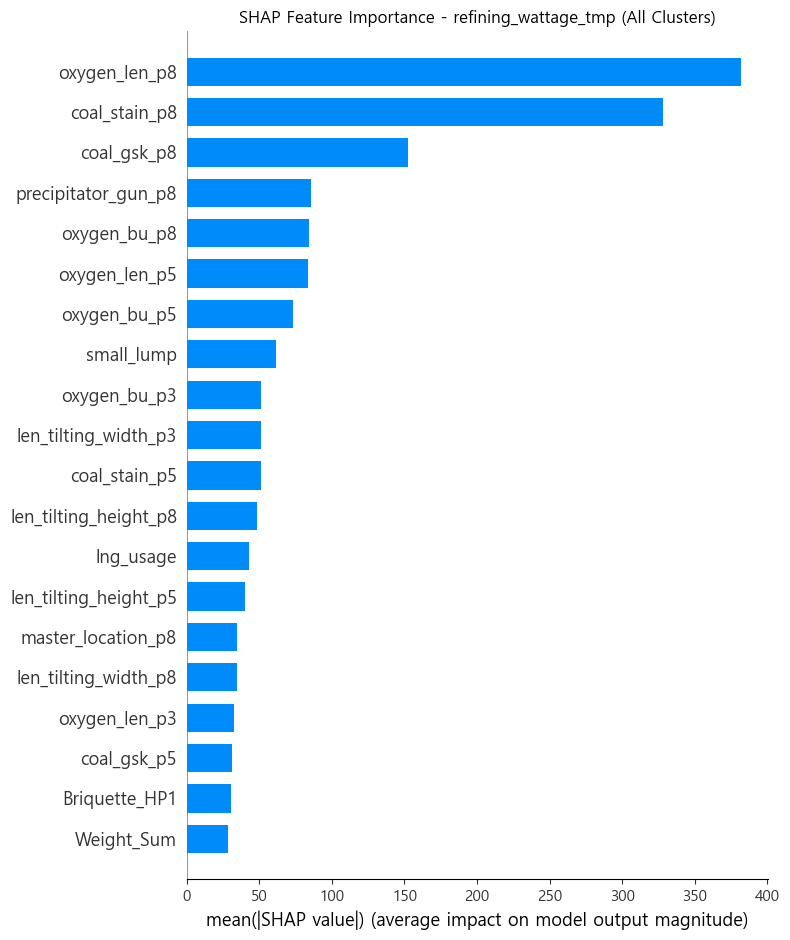

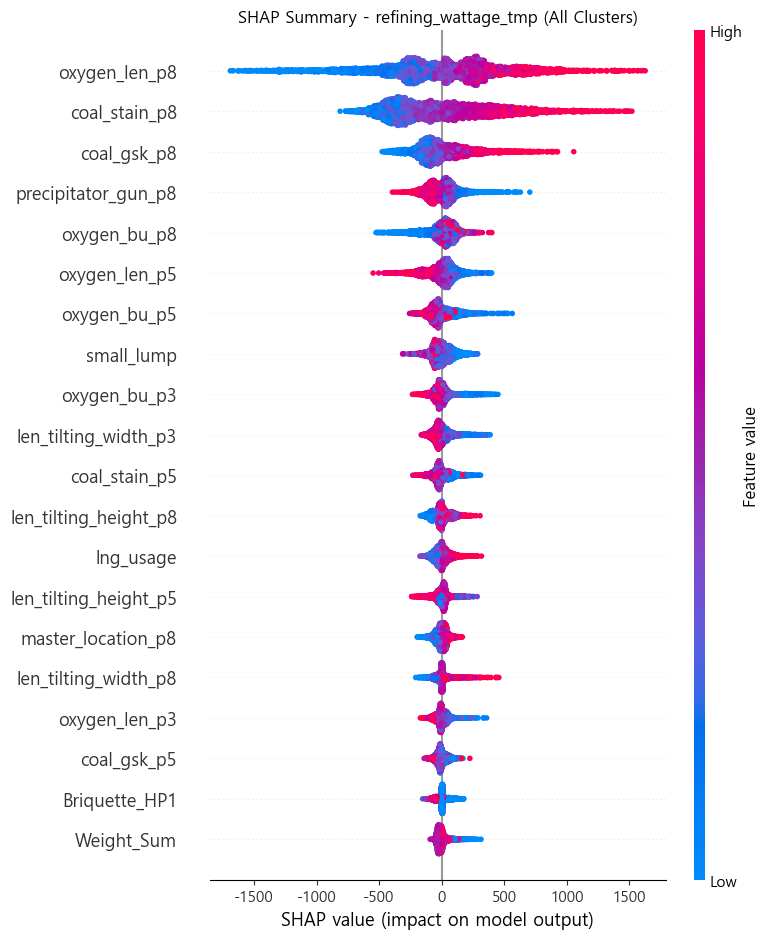

In [9]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== SHAP 설정 =====
SHAP_DATA = "train"   # "train" or "test"
SHAP_SAMPLE = 2000    # 클러스터별 최대 샘플 수
RANDOM_STATE = 42

if SHAP_DATA == "train":
    X_base = X_train
    clusters_base = train_clusters
else:
    X_base = X_test
    clusters_base = test_clusters

# 전체(클러스터 평균)용 누적
all_shap = []
all_X = []

for c, model_c in models.items():
    mask = clusters_base == c
    X_c = X_base[mask]
    if len(X_c) == 0:
        print(f"[Cluster {c}] 데이터 없음 - skip")
        continue

    if len(X_c) > SHAP_SAMPLE:
        X_c = X_c.sample(SHAP_SAMPLE, random_state=RANDOM_STATE)

    # SHAP 값 계산
    explainer = shap.TreeExplainer(model_c)
    shap_values = explainer.shap_values(X_c)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # 평균 |SHAP| 정렬 (표 형태)
    mean_abs = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        "feature": X_c.columns,
        "mean_abs_shap": mean_abs
    }).sort_values("mean_abs_shap", ascending=False)
    print(f"\n[Cluster {c}] SHAP 평균 중요도 Top 20")
    print(shap_df.head(20))

    # Bar plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_c, plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance - {TARGETS[0]} (Cluster {c}, n={len(X_c)})")
    plt.tight_layout()
    plt.show()

    # Beeswarm plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_c, show=False)
    plt.title(f"SHAP Summary - {TARGETS[0]} (Cluster {c}, n={len(X_c)})")
    plt.tight_layout()
    plt.show()

    # 전체 평균용 누적
    all_shap.append(shap_values)
    all_X.append(X_c)

# ===== 클러스터 전체 평균 SHAP =====
if len(all_shap) > 0:
    shap_all = np.vstack(all_shap)
    X_all = pd.concat(all_X, axis=0)

    mean_abs_all = np.abs(shap_all).mean(axis=0)
    shap_df_all = pd.DataFrame({
        "feature": X_all.columns,
        "mean_abs_shap": mean_abs_all
    }).sort_values("mean_abs_shap", ascending=False)

    print("\n[전체] SHAP 평균 중요도 Top 20")
    print(shap_df_all.head(20))

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_all, X_all, plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance - {TARGETS[0]} (All Clusters)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_all, X_all, show=False)
    plt.title(f"SHAP Summary - {TARGETS[0]} (All Clusters)")
    plt.tight_layout()
    plt.show()


In [10]:
# 클러스터별 예측
y_pred_train = np.empty(len(X_train))
y_pred_test = np.empty(len(X_test))

for c, model_c in models.items():
    # Train 예측
    train_mask = train_clusters == c
    if train_mask.sum() > 0:
        y_pred_train[train_mask] = model_c.predict(X_train[train_mask])
    
    # Test 예측
    test_mask = test_clusters == c
    if test_mask.sum() > 0:
        y_pred_test[test_mask] = model_c.predict(X_test[test_mask])

y_train_array = y_train.values.ravel()
y_test_array = y_test.values.ravel()

targets_to_evaluate = [(TARGETS[0], y_train_array, y_test_array, 
                        y_pred_train, y_pred_test)]

# 성능 평가
print("=" * 70)
print(f"모델 성능 평가 (GMM {best_n}그룹 분할 학습)")
print("=" * 70)

for target_name, y_tr, y_te, y_pred_tr, y_pred_te in targets_to_evaluate:
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
    test_rmse = np.sqrt(mean_squared_error(y_te, y_pred_te))
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    test_mae = mean_absolute_error(y_te, y_pred_te)
    test_mape = np.mean(np.abs((y_te - y_pred_te) / (y_te + 1e-9))) * 100
    test_smape = 100 / len(y_te) * np.sum(2 * np.abs(y_pred_te - y_te) / (np.abs(y_te) + np.abs(y_pred_te) + 1e-9))

    print(f"\n【{target_name}】")
    print(f"  Train RMSE: {train_rmse:.4f}  |  Train R²: {train_r2:.4f}")
    print(f"  Test RMSE:  {test_rmse:.4f}  |  Test R²:  {test_r2:.4f}")
    print(f"  Test MAE:   {test_mae:.4f}")
    print(f"  Test MAPE:  {test_mape:.2f}%")
    print(f"  Test SMAPE: {test_smape:.2f}%")
    
    overfitting = train_r2 - test_r2
    print(f"  과적합 체크 (R² 차이): {overfitting:.4f}", end="")
    if overfitting > 0.1:
        print("  ⚠️ 과적합 가능성")
    else:
        print("  ✅")

모델 성능 평가 (GMM 5그룹 분할 학습)

【refining_wattage_tmp】
  Train RMSE: 340.6828  |  Train R²: 0.9392
  Test RMSE:  826.6481  |  Test R²:  0.6501
  Test MAE:   610.3131
  Test MAPE:  7.32%
  Test SMAPE: 7.35%
  과적합 체크 (R² 차이): 0.2892  ⚠️ 과적합 가능성


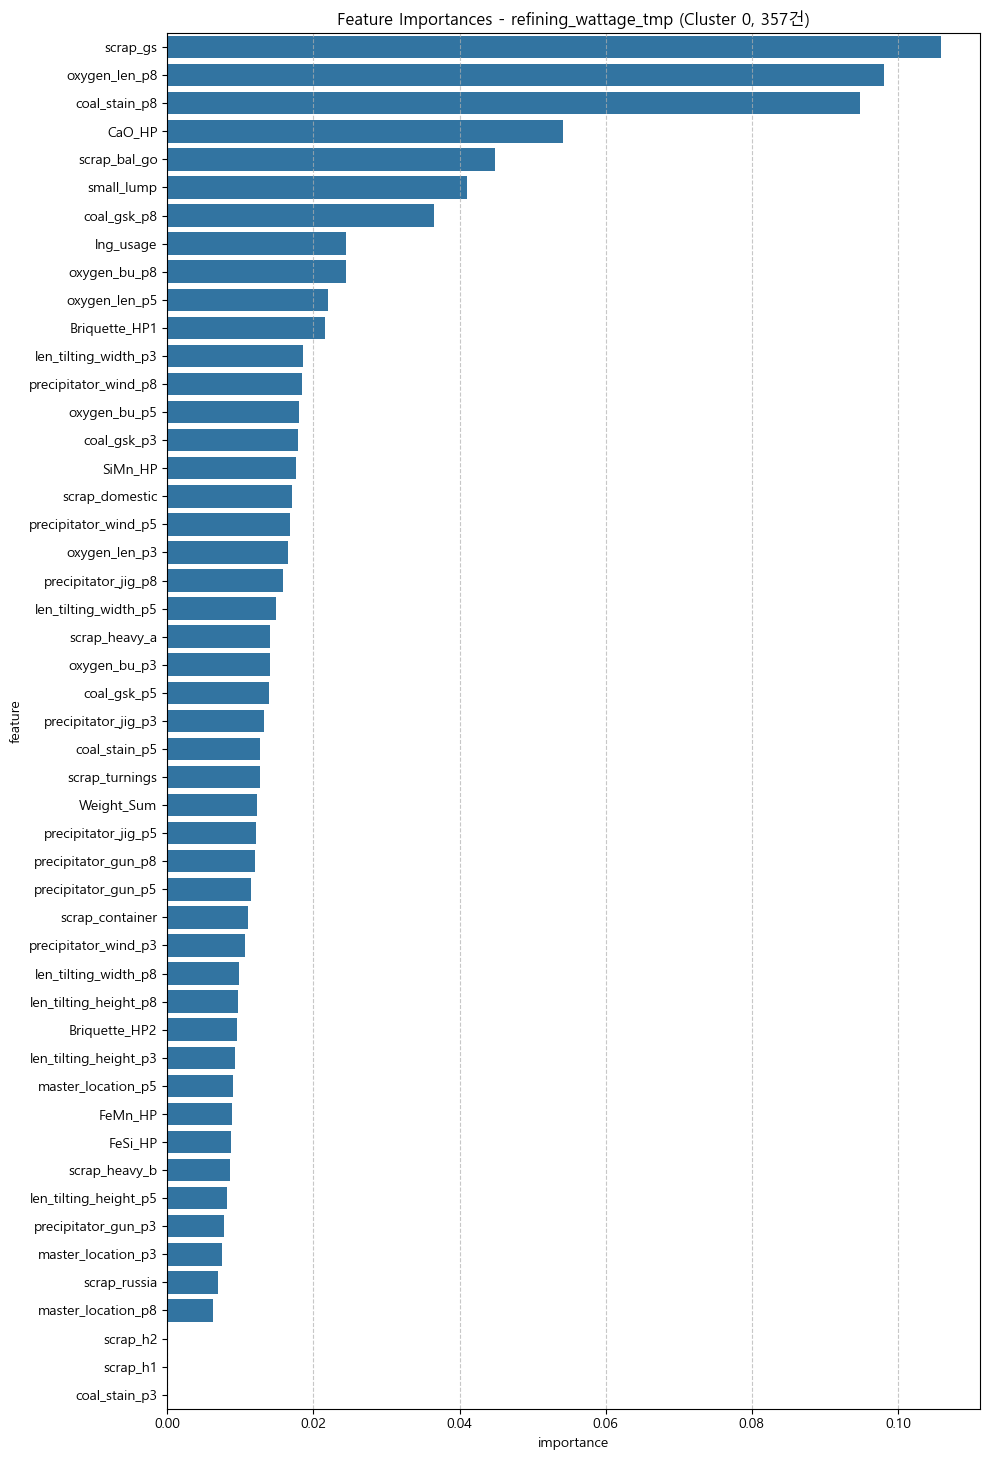


[Cluster 0 변수 중요도 순위]
                  feature  importance
34               scrap_gs    0.105945
20          oxygen_len_p8    0.098094
48          coal_stain_p8    0.094787
0                  CaO_HP    0.054136
31           scrap_bal_go    0.044891
42             small_lump    0.041045
45            coal_gsk_p8    0.036481
41              lng_usage    0.024509
29           oxygen_bu_p8    0.024480
19          oxygen_len_p5    0.022062
4           Briquette_HP1    0.021598
22   len_tilting_width_p3    0.018591
14   precipitator_wind_p8    0.018489
28           oxygen_bu_p5    0.017999
43            coal_gsk_p3    0.017884
3                 SiMn_HP    0.017581
33         scrap_domestic    0.017068
13   precipitator_wind_p5    0.016863
18          oxygen_len_p3    0.016491
8     precipitator_jig_p8    0.015782
24   len_tilting_width_p5    0.014922
37          scrap_heavy_a    0.014124
27           oxygen_bu_p3    0.014049
44            coal_gsk_p5    0.013902
6     precipitator_jig_p3  

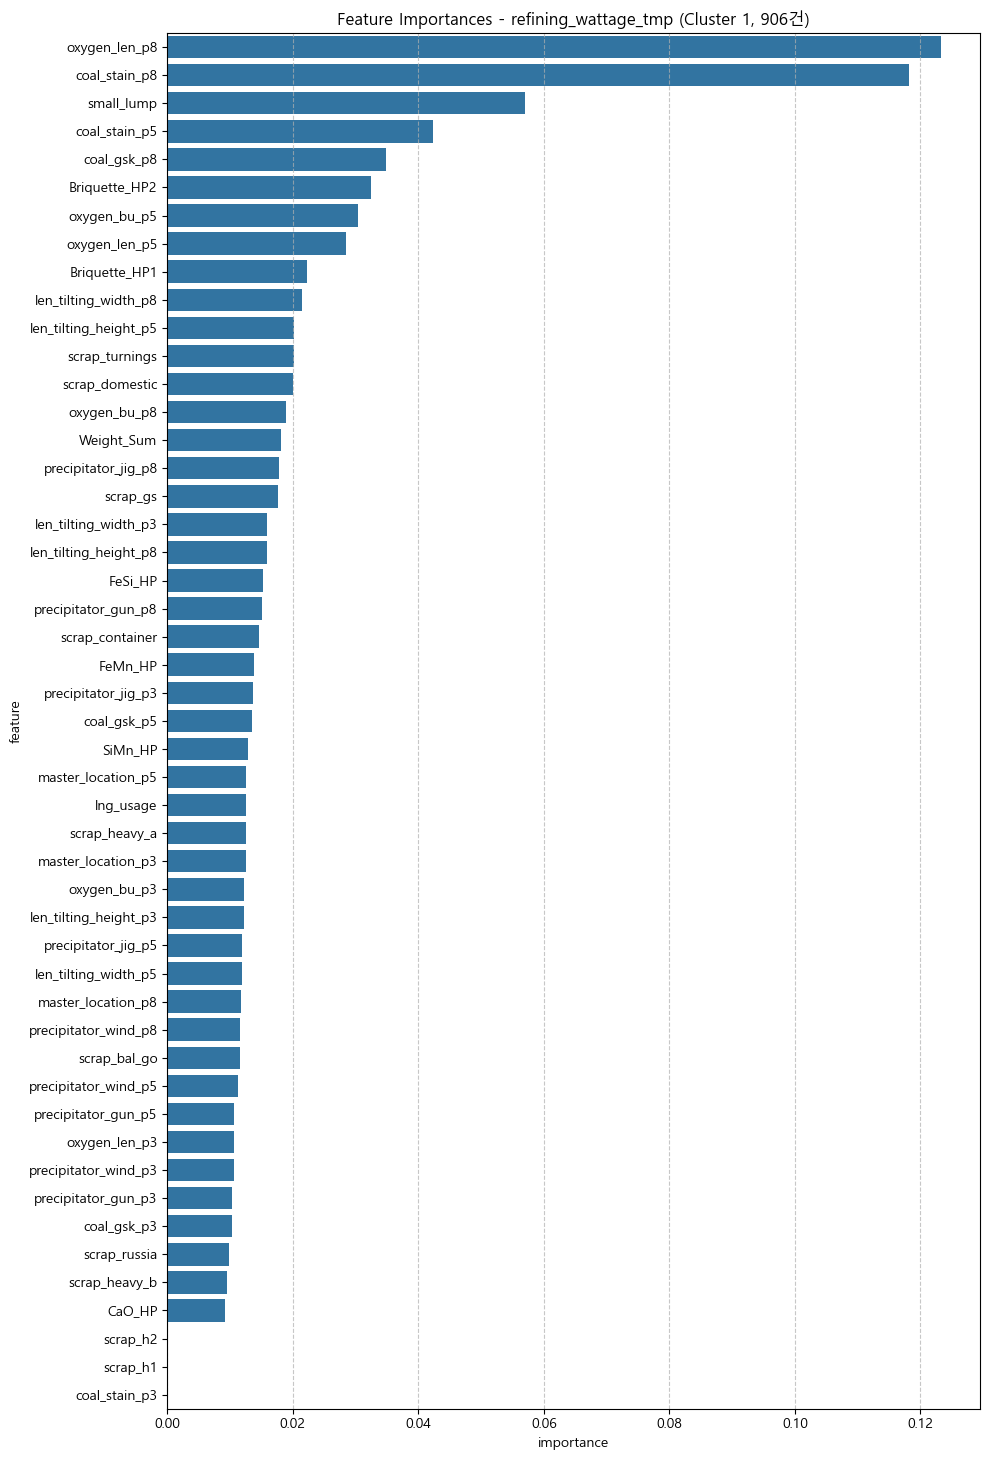


[Cluster 1 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.123314
48          coal_stain_p8    0.118187
42             small_lump    0.056946
47          coal_stain_p5    0.042312
45            coal_gsk_p8    0.034824
5           Briquette_HP2    0.032450
28           oxygen_bu_p5    0.030450
19          oxygen_len_p5    0.028542
4           Briquette_HP1    0.022235
26   len_tilting_width_p8    0.021399
23  len_tilting_height_p5    0.020253
40         scrap_turnings    0.020232
33         scrap_domestic    0.019986
29           oxygen_bu_p8    0.018896
30             Weight_Sum    0.018064
8     precipitator_jig_p8    0.017857
34               scrap_gs    0.017682
22   len_tilting_width_p3    0.015940
25  len_tilting_height_p8    0.015922
2                 FeSi_HP    0.015278
11    precipitator_gun_p8    0.015036
32        scrap_container    0.014601
1                 FeMn_HP    0.013763
6     precipitator_jig_p3    0.013672
44            coal_gsk_p5  

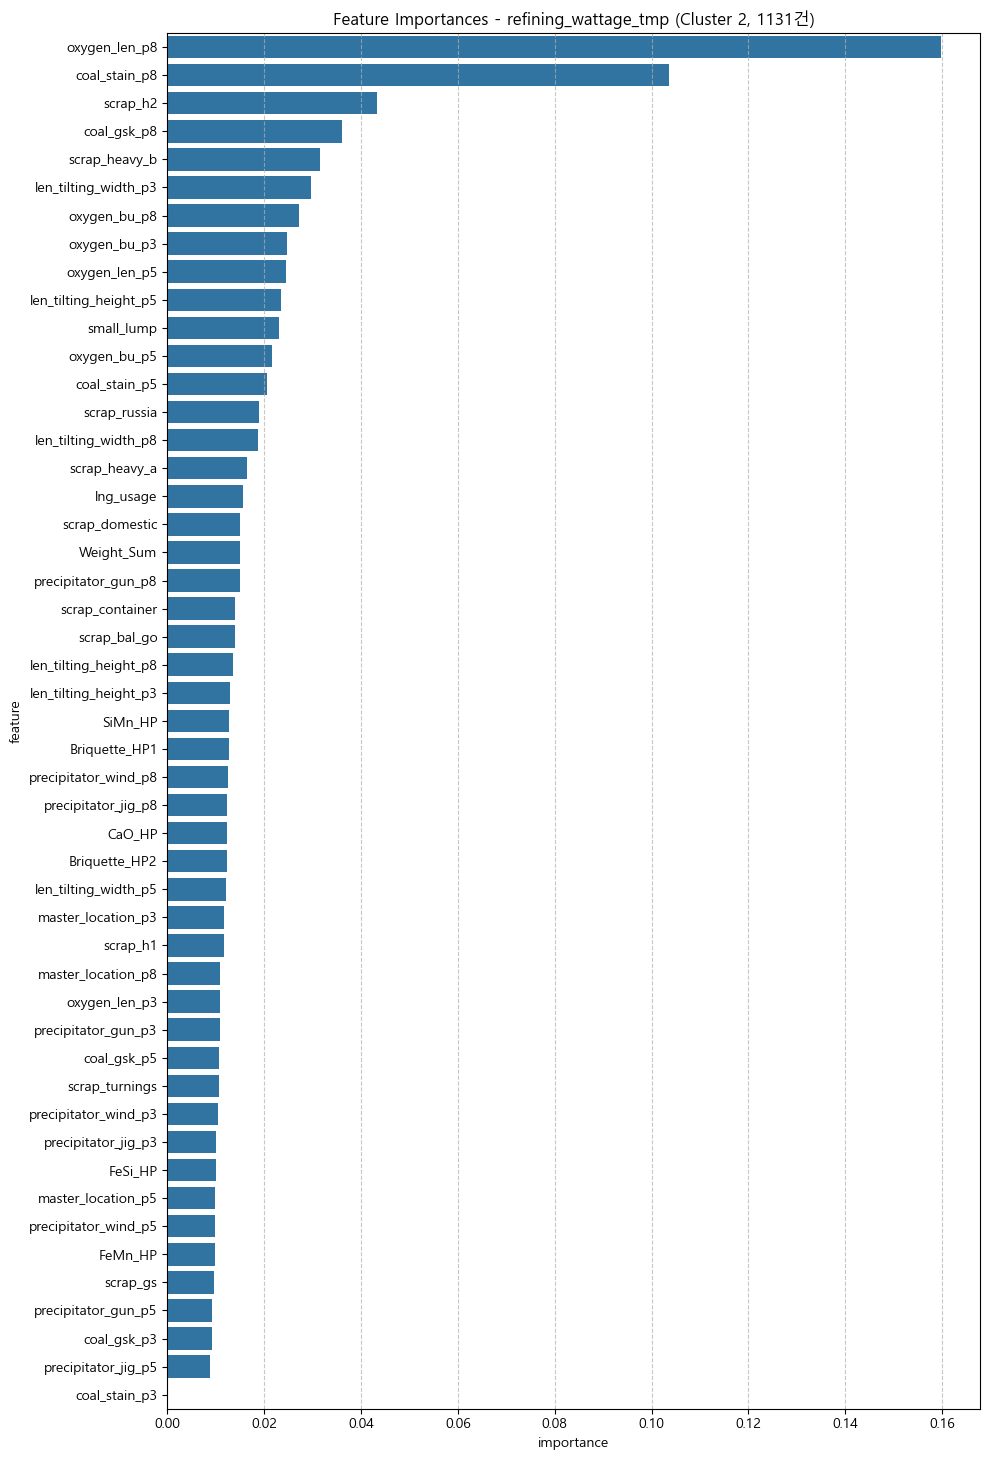


[Cluster 2 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.159829
48          coal_stain_p8    0.103504
36               scrap_h2    0.043324
45            coal_gsk_p8    0.036005
38          scrap_heavy_b    0.031617
22   len_tilting_width_p3    0.029693
29           oxygen_bu_p8    0.027167
27           oxygen_bu_p3    0.024779
19          oxygen_len_p5    0.024577
23  len_tilting_height_p5    0.023444
42             small_lump    0.023086
28           oxygen_bu_p5    0.021634
47          coal_stain_p5    0.020690
39           scrap_russia    0.018896
26   len_tilting_width_p8    0.018781
37          scrap_heavy_a    0.016539
41              lng_usage    0.015572
33         scrap_domestic    0.015034
30             Weight_Sum    0.014953
11    precipitator_gun_p8    0.014922
32        scrap_container    0.014078
31           scrap_bal_go    0.014060
25  len_tilting_height_p8    0.013558
21  len_tilting_height_p3    0.012894
3                 SiMn_HP  

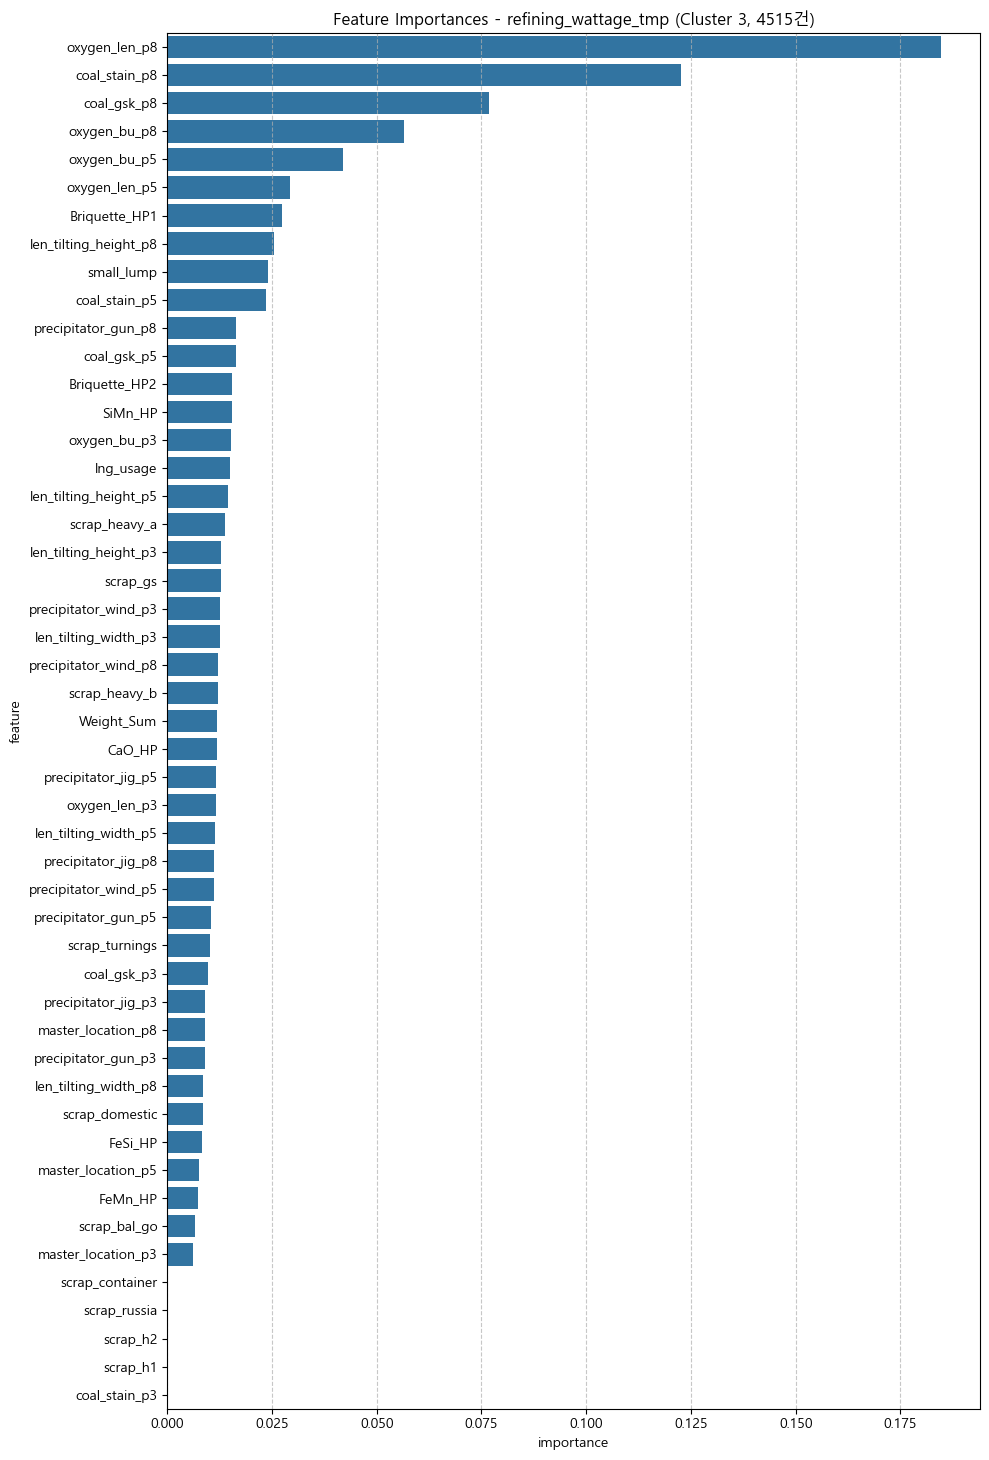


[Cluster 3 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.184774
48          coal_stain_p8    0.122546
45            coal_gsk_p8    0.076711
29           oxygen_bu_p8    0.056516
28           oxygen_bu_p5    0.041841
19          oxygen_len_p5    0.029402
4           Briquette_HP1    0.027291
25  len_tilting_height_p8    0.025426
42             small_lump    0.024088
47          coal_stain_p5    0.023537
11    precipitator_gun_p8    0.016457
44            coal_gsk_p5    0.016358
5           Briquette_HP2    0.015481
3                 SiMn_HP    0.015354
27           oxygen_bu_p3    0.015196
41              lng_usage    0.015021
23  len_tilting_height_p5    0.014479
37          scrap_heavy_a    0.013830
21  len_tilting_height_p3    0.012884
34               scrap_gs    0.012866
12   precipitator_wind_p3    0.012566
22   len_tilting_width_p3    0.012507
14   precipitator_wind_p8    0.012066
38          scrap_heavy_b    0.012055
30             Weight_Sum  

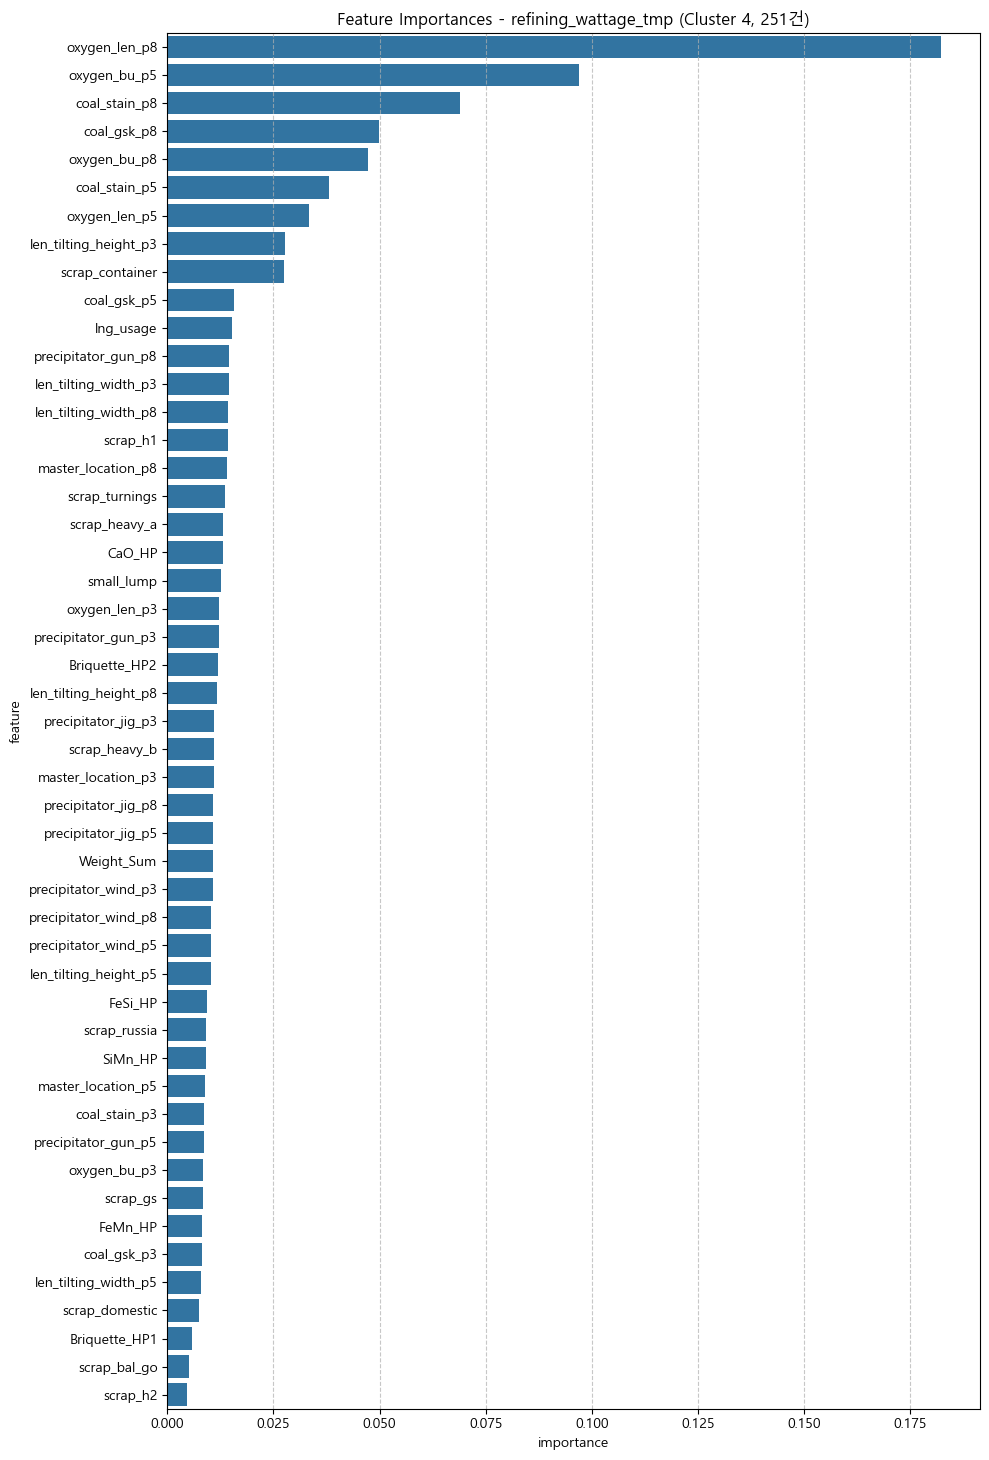


[Cluster 4 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.182340
28           oxygen_bu_p5    0.096981
48          coal_stain_p8    0.069045
45            coal_gsk_p8    0.049944
29           oxygen_bu_p8    0.047200
47          coal_stain_p5    0.038022
19          oxygen_len_p5    0.033501
21  len_tilting_height_p3    0.027634
32        scrap_container    0.027432
44            coal_gsk_p5    0.015607
41              lng_usage    0.015187
11    precipitator_gun_p8    0.014651
22   len_tilting_width_p3    0.014442
26   len_tilting_width_p8    0.014204
35               scrap_h1    0.014202
17     master_location_p8    0.014008
40         scrap_turnings    0.013627
37          scrap_heavy_a    0.013155
0                  CaO_HP    0.013108
42             small_lump    0.012558
18          oxygen_len_p3    0.012290
9     precipitator_gun_p3    0.012096
5           Briquette_HP2    0.011954
25  len_tilting_height_p8    0.011830
6     precipitator_jig_p3  

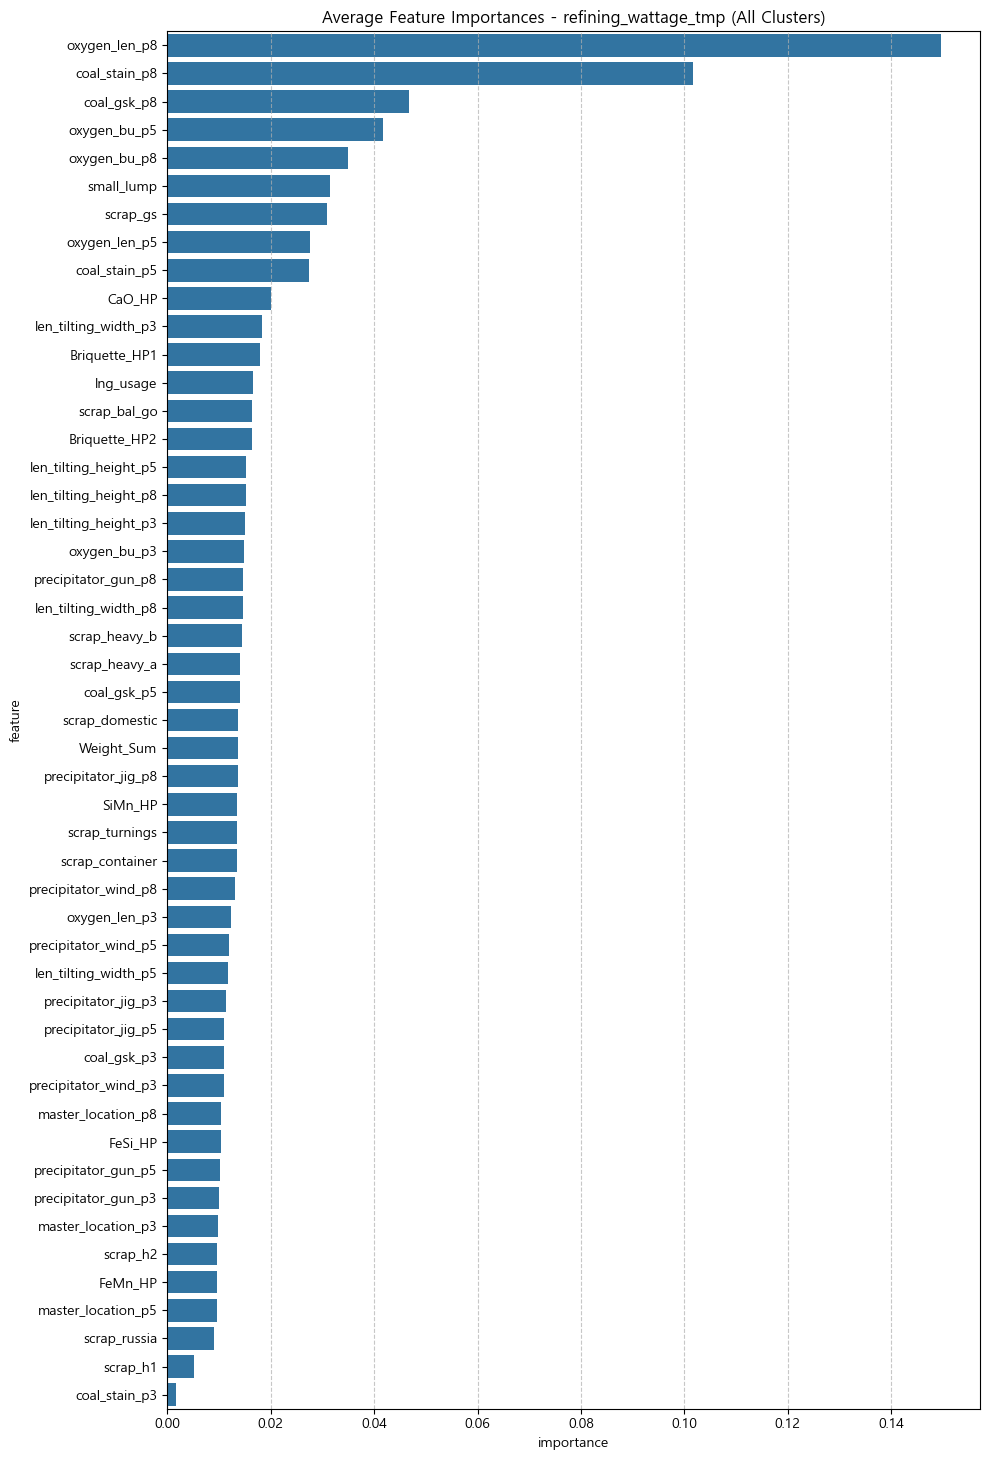


[전체 평균 변수 중요도 순위]
                  feature  importance
0           oxygen_len_p8    0.149670
1           coal_stain_p8    0.101614
2             coal_gsk_p8    0.046793
3            oxygen_bu_p5    0.041781
4            oxygen_bu_p8    0.034852
5              small_lump    0.031545
6                scrap_gs    0.030894
7           oxygen_len_p5    0.027617
8           coal_stain_p5    0.027456
9                  CaO_HP    0.020102
10   len_tilting_width_p3    0.018234
11          Briquette_HP1    0.017917
12              lng_usage    0.016568
13           scrap_bal_go    0.016473
14          Briquette_HP2    0.016325
15  len_tilting_height_p5    0.015307
16  len_tilting_height_p8    0.015284
17  len_tilting_height_p3    0.014973
18           oxygen_bu_p3    0.014931
19    precipitator_gun_p8    0.014624
20   len_tilting_width_p8    0.014556
21          scrap_heavy_b    0.014542
22          scrap_heavy_a    0.014038
23            coal_gsk_p5    0.014009
24         scrap_domestic    0.

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 클러스터별 변수 중요도 추출 및 시각화
for c, model_c in models.items():
    importances = model_c.feature_importances_
    feature_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, len(X_train.columns) * 0.3))
    sns.barplot(x='importance', y='feature', data=feature_df)
    plt.title(f'Feature Importances - {TARGETS[0]} (Cluster {c}, {(train_clusters == c).sum()}건)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(f"\n[Cluster {c} 변수 중요도 순위]")
    print(feature_df)
    print()

# 전체 평균 중요도
avg_importances = np.mean([m.feature_importances_ for m in models.values()], axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': avg_importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, len(X_train.columns) * 0.3))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title(f'Average Feature Importances - {TARGETS[0]} (All Clusters)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"\n[전체 평균 변수 중요도 순위]")
print(feature_importance_df)

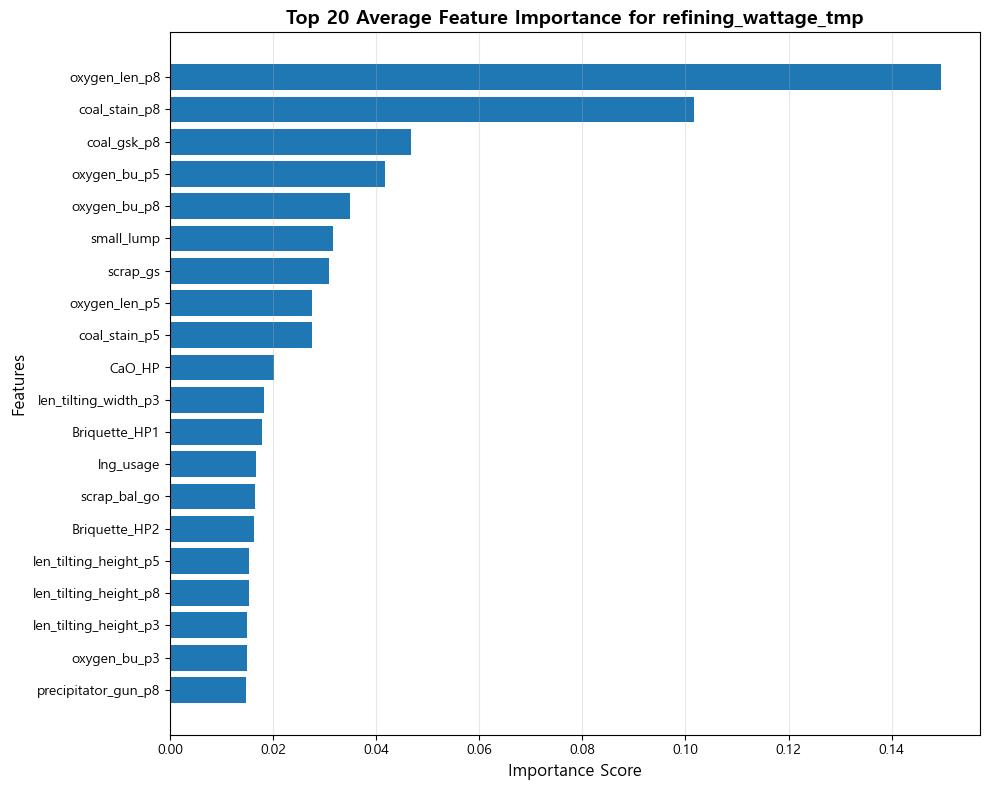

In [12]:
# Feature Importance Top 20 시각화 (평균 기준)
top_n = 20

plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Top {top_n} Average Feature Importance for {TARGETS[0]}', 
         fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

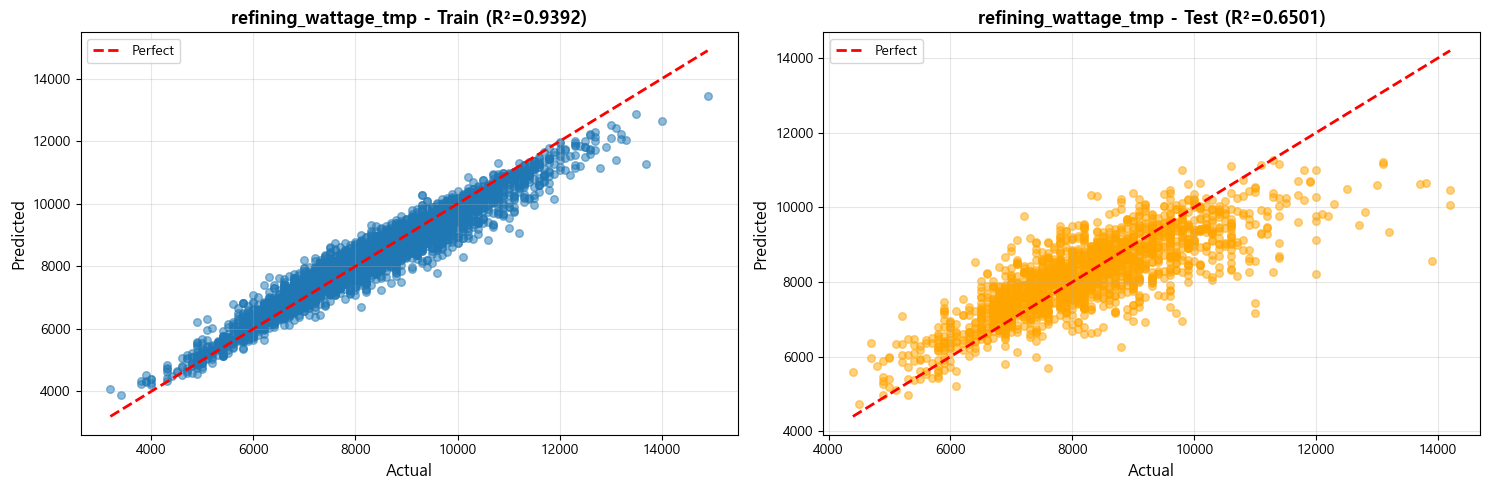

In [13]:
# 예측 vs 실제 시각화
n_targets = len(targets_to_evaluate)
fig, axes = plt.subplots(n_targets, 2, figsize=(15, 5*n_targets))

# 타겟이 1개일 때 axes 차원 조정
if n_targets == 1:
    axes = axes.reshape(1, -1)

for idx, (target_name, y_tr, y_te, y_pred_tr, y_pred_te) in enumerate(targets_to_evaluate):
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    
    # Train set
    axes[idx, 0].scatter(y_tr, y_pred_tr, alpha=0.5, s=30)
    axes[idx, 0].plot([y_tr.min(), y_tr.max()],
                      [y_tr.min(), y_tr.max()], 'r--', lw=2, label='Perfect')
    axes[idx, 0].set_xlabel('Actual', fontsize=12)
    axes[idx, 0].set_ylabel('Predicted', fontsize=12)
    axes[idx, 0].set_title(f'{target_name} - Train (R²={train_r2:.4f})', 
                          fontsize=13, fontweight='bold')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Test set
    axes[idx, 1].scatter(y_te, y_pred_te, alpha=0.5, s=30, color='orange')
    axes[idx, 1].plot([y_te.min(), y_te.max()],
                      [y_te.min(), y_te.max()], 'r--', lw=2, label='Perfect')
    axes[idx, 1].set_xlabel('Actual', fontsize=12)
    axes[idx, 1].set_ylabel('Predicted', fontsize=12)
    axes[idx, 1].set_title(f'{target_name} - Test (R²={test_r2:.4f})', 
                          fontsize=13, fontweight='bold')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

targets_str = '_'.join(TARGETS)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import gc

print("교차 검증 수행 중 (GMM 분할 학습)...")

N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
cv_r2_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    X_cv_train, X_cv_val = X.iloc[train_idx], X.iloc[val_idx]
    y_cv_train = y.values.ravel()[train_idx]
    y_cv_val   = y.values.ravel()[val_idx]

    # (중요) fold 기준으로 스케일러 fit -> leakage 방지 + GMM 안정화
    sc = StandardScaler()
    X_tr_s = sc.fit_transform(X_cv_train.values)
    X_va_s = sc.transform(X_cv_val.values)

    # GMM은 스케일된 X로
    gmm_cv = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
    cv_train_clusters = gmm_cv.fit_predict(X_tr_s)
    cv_val_clusters   = gmm_cv.predict(X_va_s)

    # 1) global 모델(폴드 fallback)
    global_params = dict(params)
    global_params.update({"nthread": 4})  # 안정성
    global_model = xgb.XGBRegressor(**global_params)
    global_model.fit(X_cv_train, y_cv_train, verbose=False)

    y_cv_pred = global_model.predict(X_cv_val)  # 기본값을 global로 깔아둠

    # 2) 클러스터별로 있으면 덮어쓰기
    for c in range(best_n):
        tr_mask = (cv_train_clusters == c)
        va_mask = (cv_val_clusters == c)

        # 최소 샘플 조건(너무 작은 클러스터는 학습하지 않음)
        if tr_mask.sum() < 50 or va_mask.sum() == 0:
            continue

        m = xgb.XGBRegressor(**global_params)
        m.fit(X_cv_train.iloc[tr_mask], y_cv_train[tr_mask], verbose=False)
        y_cv_pred[va_mask] = m.predict(X_cv_val.iloc[va_mask])

        del m
        gc.collect()

    fold_r2 = r2_score(y_cv_val, y_cv_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
    cv_r2_scores.append(fold_r2)

    print(f"  Fold {fold}: R² = {fold_r2:.4f}, RMSE = {fold_rmse:.4f}")

    del global_model, gmm_cv
    gc.collect()

print("=" * 50)
print(f"{N_SPLITS}5-Fold CV 평균 R²: {np.mean(cv_r2_scores):.4f} (±{np.std(cv_r2_scores):.4f})")
print("=" * 50)


교차 검증 수행 중 (GMM 분할 학습)...
  Fold 1: R² = 0.6533, RMSE = 822.8475
  Fold 2: R² = 0.7096, RMSE = 741.0419
  Fold 3: R² = 0.7162, RMSE = 731.1520
  Fold 4: R² = 0.6939, RMSE = 778.8898
  Fold 5: R² = 0.6616, RMSE = 797.9266
55-Fold CV 평균 R²: 0.6869 (±0.0253)



【refining_wattage_tmp 잔차 통계】
  평균: 57.8961
  표준편차: 824.6182
  최대값: 5346.4414
  최소값: -2559.7246

💾 저장 완료: residuals_refining_wattage_tmp.png


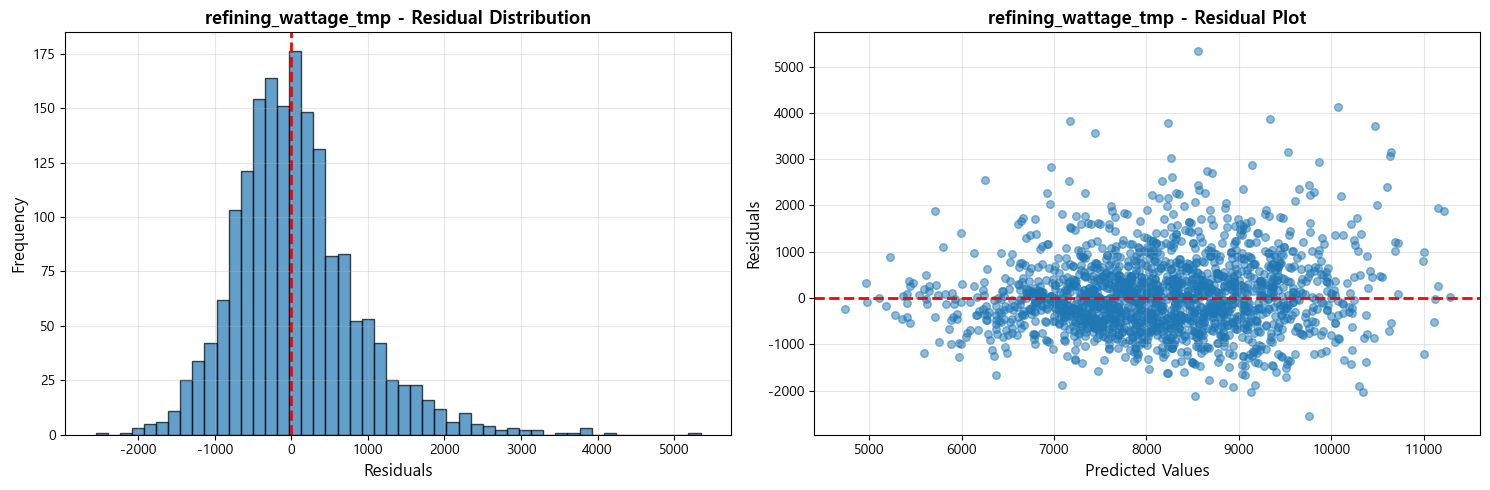

In [15]:
# 잔차 분석
n_targets = len(targets_to_evaluate)
fig, axes = plt.subplots(n_targets, 2, figsize=(15, 5*n_targets))
# 각 타겟별로 2개 그래프 (분포 히스토그램, 잔차 플롯)

if n_targets == 1:
    axes = axes.reshape(1, -1)

for idx, (target_name, y_tr, y_te, y_pred_tr, y_pred_te) in enumerate(targets_to_evaluate):
    residuals_test = y_te - y_pred_te  # 잔차 = 실제값 - 예측값
    # 양수: 과소예측 (실제가 더 큼)
    # 음수: 과대예측 (예측이 더 큼)
    
    # ===== 왼쪽: 잔차 분포 히스토그램 =====
    axes[idx, 0].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
    # hist: 히스토그램 (막대 그래프)
    #   - bins=50: 50개 구간으로 나눔
    #   - edgecolor='black': 막대 테두리 색
    #   - alpha=0.7: 투명도 70%
    
    axes[idx, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    # axvline: 수직선 그리기
    #   - x=0 위치에 빨간 점선
    #   - 이상적으로는 이 선을 중심으로 대칭이어야 함
    
    axes[idx, 0].set_xlabel('Residuals', fontsize=12)
    axes[idx, 0].set_ylabel('Frequency', fontsize=12)
    axes[idx, 0].set_title(f'{target_name} - Residual Distribution', 
                          fontsize=13, fontweight='bold')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # ===== 오른쪽: 잔차 vs 예측값 산점도 =====
    axes[idx, 1].scatter(y_pred_te, residuals_test, alpha=0.5, s=30)
    # x축: 예측값
    # y축: 잔차
    # 패턴 없이 무작위로 흩어져야 좋은 모델
    
    axes[idx, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    # axhline: 수평선 그리기
    #   - y=0 위치 (잔차 0)
    #   - 점들이 이 선 주위에 랜덤하게 분포해야 함
    
    axes[idx, 1].set_xlabel('Predicted Values', fontsize=12)
    axes[idx, 1].set_ylabel('Residuals', fontsize=12)
    axes[idx, 1].set_title(f'{target_name} - Residual Plot', 
                          fontsize=13, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # 통계 정보 출력
    print(f"\n【{target_name} 잔차 통계】")
    print(f"  평균: {residuals_test.mean():.4f}")
    # 평균이 0에 가까워야 함 (편향 없음)
    
    print(f"  표준편차: {residuals_test.std():.4f}")
    # 오차의 퍼진 정도
    
    print(f"  최대값: {residuals_test.max():.4f}")
    # 가장 크게 과소예측한 경우
    
    print(f"  최소값: {residuals_test.min():.4f}")
    # 가장 크게 과대예측한 경우

targets_str = '_'.join(TARGETS)
plt.tight_layout()
plt.savefig(f'residuals_{targets_str}.png', dpi=300, bbox_inches='tight')
print(f"\n💾 저장 완료: residuals_{targets_str}.png")
plt.show()

In [16]:
from datetime import datetime

print("=" * 80)
print("XGBoost 모델 학습 결과 요약 (GMM 분할 학습)")
print("=" * 80)

print(f"\n【실험 정보】")
print(f"  실험 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"  타겟 변수: {', '.join(TARGETS)}")
print(f"  GMM 클러스터 수: {best_n}")
print(f"  총 데이터 개수: {len(df_model)}")
print(f"  Train 데이터: {len(X_train)} ({len(X_train)/len(df_model)*100:.1f}%)")
print(f"  Test 데이터: {len(X_test)} ({len(X_test)/len(df_model)*100:.1f}%)")

print(f"\n【클러스터 분포】")
for c in range(best_n):
    print(f"  Cluster {c}: Train {(train_clusters == c).sum()}건, Test {(test_clusters == c).sum()}건")

print(f"\n【데이터 전처리】")
print(f"  결측치 → 0 (미투입 처리)")

print(f"\n【특성 정보】")
print(f"  총 특성 개수: {len(SELECTED_FEATURES)}")

print(f"\n【하이퍼파라미터】")
for key, value in params.items():
    print(f"  {key:25s}: {value}")

print(f"\n【모델 성능】")
for target_name, y_tr, y_te, y_pred_tr, y_pred_te in targets_to_evaluate:
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
    test_rmse = np.sqrt(mean_squared_error(y_te, y_pred_te))
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    train_mae = mean_absolute_error(y_tr, y_pred_tr)
    test_mae = mean_absolute_error(y_te, y_pred_te)
    
    print(f"\n  ▶ {target_name}")
    print(f"    Train - RMSE: {train_rmse:>10.4f}  |  R²: {train_r2:>6.4f}  |  MAE: {train_mae:>10.4f}")
    print(f"    Test  - RMSE: {test_rmse:>10.4f}  |  R²: {test_r2:>6.4f}  |  MAE: {test_mae:>10.4f}")
    
    overfitting = train_r2 - test_r2
    if overfitting > 0.1:
        print(f"    ⚠️  과적합 감지 (R² 차이: {overfitting:.4f})")
    else:
        print(f"    ✅  과적합 없음 (R² 차이: {overfitting:.4f})")
    
    print(f"    타겟 범위: {y_te.min():.2f} ~ {y_te.max():.2f}")
    print(f"    타겟 평균: {y_te.mean():.2f} (표준편차: {y_te.std():.2f})")

print(f"\n【주요 특성 (Top 10, 평균 중요도)】")
for idx, row in feature_importance_df.head(10).iterrows():
    print(f"  {idx+1:2d}. {row['feature']:25s}  중요도: {row['importance']:.6f}")

print("\n" + "=" * 80)

XGBoost 모델 학습 결과 요약 (GMM 분할 학습)

【실험 정보】
  실험 일시: 2026-02-10 16:01:01
  타겟 변수: refining_wattage_tmp
  GMM 클러스터 수: 5
  총 데이터 개수: 8950
  Train 데이터: 7160 (80.0%)
  Test 데이터: 1790 (20.0%)

【클러스터 분포】
  Cluster 0: Train 357건, Test 114건
  Cluster 1: Train 906건, Test 202건
  Cluster 2: Train 1131건, Test 270건
  Cluster 3: Train 4515건, Test 1156건
  Cluster 4: Train 251건, Test 48건

【데이터 전처리】
  결측치 → 0 (미투입 처리)

【특성 정보】
  총 특성 개수: 49

【하이퍼파라미터】
  objective                : reg:squarederror
  random_state             : 42
  tree_method              : hist
  device                   : cuda
  sampling_method          : gradient_based
  max_bin                  : 256
  max_depth                : 6
  learning_rate            : 0.01223826357909319
  n_estimators             : 800
  subsample                : 0.7
  colsample_bytree         : 0.6
  min_child_weight         : 6
  gamma                    : 5.0
  reg_alpha                : 1.0
  reg_lambda               : 6.0
  eval_metric              : rms

In [17]:
class ExperimentLogger:
    """실험 결과를 자동으로 기록하는 클래스"""
    
    def __init__(self, log_file='experiment_log_xgb.json'):
        self.log_file = log_file
        self.experiments = []
        self.load_existing_logs()
    
    def load_existing_logs(self):
        """기존 로그 불러오기"""
        try:
            with open(self.log_file, 'r', encoding='utf-8') as f:
                self.experiments = json.load(f)
            print(f"✅ 기존 로그 {len(self.experiments)}개 불러옴: {self.log_file}")
        except FileNotFoundError:
            print(f"📝 새로운 로그 파일 생성: {self.log_file}")
            self.experiments = []
    
    def log_experiment(self, target, features, params, results, feature_importance=None):
        """실험 결과 기록"""
        experiment = {
            'experiment_id': len(self.experiments) + 1,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'target': target,
            'n_features': len(features),
            'features': features,
            'params': params,
            'results': results,
            'feature_importance_top10': feature_importance
        }
        self.experiments.append(experiment)
        self.save()
        return experiment['experiment_id']
    
    def save(self):
        """로그 파일 저장"""
        with open(self.log_file, 'w', encoding='utf-8') as f:
            json.dump(self.experiments, f, ensure_ascii=False, indent=2)
    
    def get_best_experiment(self, target, metric='test_r2'):
        """특정 타겟의 최고 성능 실험 찾기"""
        target_exps = [e for e in self.experiments if e['target'] == target]
        if not target_exps:
            return None
        return max(target_exps, key=lambda x: x['results'][metric])
    
    def print_summary(self):
        """전체 실험 요약"""
        if len(self.experiments) == 0:
            print("아직 실험 기록이 없습니다.")
            return
        
        print(f"\n{'='*80}")
        print(f"📊 실험 기록 요약")
        print(f"{'='*80}")
        print(f"총 실험 횟수: {len(self.experiments)}")
        print(f"로그 파일: {self.log_file}")
        print(f"{'='*80}\n")
        
        # 타겟별 최고 성능
        targets = set(e['target'] for e in self.experiments)
        for target in sorted(targets):
            best = self.get_best_experiment(target)
            if best:
                print(f"[{target}] 최고 성능 (실험 #{best['experiment_id']})")
                print(f"  Test R²:    {best['results']['test_r2']:.4f}")
                print(f"  Test MAPE:  {best['results'].get('test_mape', 0):.2f}%")  # ✨ 추가
                print(f"  Test SMAPE: {best['results'].get('test_smape', 0):.2f}%") # ✨ 추가
                print(f"  Test RMSE:  {best['results']['test_rmse']:.4f}")
                print(f"  CV R²:      {best['results']['cv_r2']:.4f}")
                print(f"  실험 시각:  {best['timestamp']}")
                print(f"  특성 개수:  {best['n_features']}")
                print(f"  주요 파라미터:")
                print(f"    - max_depth: {best['params']['max_depth']}")
                print(f"    - learning_rate: {best['params']['learning_rate']:.4f}")
                print(f"    - n_estimators: {best['params']['n_estimators']}")
                print(f"  Top 5 특성: {', '.join(best['feature_importance_top10'][:5])}")
                print()
    
    def get_experiments_df(self):
        """실험 결과를 DataFrame으로 변환"""
        if len(self.experiments) == 0:
            return pd.DataFrame()
        
        records = []
        for exp in self.experiments:
            record = {
                'exp_id': exp['experiment_id'],
                'timestamp': exp['timestamp'],
                'target': exp['target'],
                'n_features': exp['n_features'],
                'test_r2': exp['results']['test_r2'],
                'test_mape': exp['results'].get('test_mape'),   # ✨ 추가
                'test_smape': exp['results'].get('test_smape'), # ✨ 추가
                'test_rmse': exp['results']['test_rmse'],
                'cv_r2': exp['results']['cv_r2'],
                'max_depth': exp['params']['max_depth'],
                'learning_rate': exp['params']['learning_rate'],
                'n_estimators': exp['params']['n_estimators'],
            }
            records.append(record)
        
        return pd.DataFrame(records)

# 로거 초기화
logger = ExperimentLogger('experiment_log_xgb.json')
logger.print_summary()

✅ 기존 로그 10개 불러옴: experiment_log_xgb.json

📊 실험 기록 요약
총 실험 횟수: 10
로그 파일: experiment_log_xgb.json

[melting_wattage] 최고 성능 (실험 #2)
  Test R²:    0.7053
  Test MAPE:  0.94%
  Test SMAPE: 0.94%
  Test RMSE:  561.9262
  CV R²:      0.6924
  실험 시각:  2026-02-04 18:13:04
  특성 개수:  41
  주요 파라미터:
    - max_depth: 6
    - learning_rate: 0.0376
    - n_estimators: 900
  Top 5 특성: small_lump, Briquette_HP1, coal_gsk, oxygen_bu_p5, oxygen_len_p5

[melting_wattage_tmp] 최고 성능 (실험 #7)
  Test R²:    0.6327
  Test MAPE:  1.09%
  Test SMAPE: 1.09%
  Test RMSE:  534.0674
  CV R²:      0.6273
  실험 시각:  2026-02-06 11:28:07
  특성 개수:  39
  주요 파라미터:
    - max_depth: 6
    - learning_rate: 0.0240
    - n_estimators: 850
  Top 5 특성: oxygen_len_p5, Briquette_HP1, coal_stain_p5, small_lump, oxygen_bu_p5

[refining_wattage_tmp] 최고 성능 (실험 #4)
  Test R²:    0.6693
  Test MAPE:  7.09%
  Test SMAPE: 7.11%
  Test RMSE:  803.6452
  CV R²:      0.7044
  실험 시각:  2026-02-05 14:42:22
  특성 개수:  48
  주요 파라미터:
    - max_depth: 6

In [18]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import gc

def objective(trial, target_name, X_data, y_data):
    params = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 900, step=50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'tree_method': 'hist',
        'device': 'cpu',   # 안정화 후 cuda로 바꾸고 싶으면 여기만 변경
        'nthread': 4
    }

    N_SPLITS = 5  # 속도 개선(원하면 10으로)
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    fold_r2s = []

    X_df = X_data
    y_arr = y_data.values.ravel()

    for train_idx, val_idx in kf.split(X_df):
        X_tr = X_df.iloc[train_idx]
        X_val = X_df.iloc[val_idx]
        y_tr = y_arr[train_idx]
        y_val = y_arr[val_idx]

        # fold별 스케일링 -> GMM 안정화/일관성
        sc = StandardScaler()
        X_tr_s = sc.fit_transform(X_tr.values)
        X_val_s = sc.transform(X_val.values)

        # GMM은 스케일된 X로
        gmm_cv = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
        tr_clusters = gmm_cv.fit_predict(X_tr_s)
        val_clusters = gmm_cv.predict(X_val_s)

        # (핵심) global fallback으로 예측값을 먼저 채움
        global_model = xgb.XGBRegressor(**params)
        global_model.fit(X_tr, y_tr, verbose=False)
        y_pred = global_model.predict(X_val)

        # 클러스터별 덮어쓰기(조건 만족 시에만)
        MIN_CLUSTER = 100
        for c in range(best_n):
            tr_mask = (tr_clusters == c)
            val_mask = (val_clusters == c)

            if tr_mask.sum() < MIN_CLUSTER or val_mask.sum() == 0:
                continue

            m = xgb.XGBRegressor(**params)
            m.fit(X_tr.iloc[tr_mask], y_tr[tr_mask], verbose=False)
            y_pred[val_mask] = m.predict(X_val.iloc[val_mask])

            del m
            gc.collect()

        fold_r2s.append(r2_score(y_val, y_pred))

        del global_model, gmm_cv, sc
        gc.collect()

    return float(np.mean(fold_r2s))


In [19]:
# 필요한 import (없으면 추가)
import numpy as np
import pandas as pd
import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def run_optimization(target_name, n_trials=100, timeout=None):
    """GMM 분할 학습 기반 하이퍼파라미터 자동 최적화"""

    print(f"\n{'='*80}")
    print(f"[{target_name}] 하이퍼파라미터 최적화 시작 (GMM {best_n}그룹)")
    print(f"{'='*80}")
    print(f"시도 횟수: {n_trials}")
    if timeout:
        print(f"최대 시간: {timeout}초")
    print(f"{'='*80}\n")

    TARGETS_OPTUNA = [target_name]
    df_model_optuna = df_processed.dropna(subset=TARGETS_OPTUNA).copy()

    # Use the same outlier handling as the main training dataset (if defined)
    if (
        'USE_OUTLIER_FILTER' in globals()
        and 'OUTLIER_METHOD' in globals()
        and 'OUTLIER_ACTION' in globals()
        and 'remove_outliers_iqr' in globals()
        and 'clip_outliers_iqr' in globals()
        and USE_OUTLIER_FILTER
        and OUTLIER_METHOD == 'iqr'
    ):
        outlier_cols_optuna = list(dict.fromkeys(SELECTED_FEATURES if not OUTLIER_INCLUDE_TARGET else (TARGETS_OPTUNA + SELECTED_FEATURES)))
        before_optuna = len(df_model_optuna)

        if OUTLIER_ACTION == 'drop':
            df_model_optuna, _, _, _ = remove_outliers_iqr(
                df=df_model_optuna,
                columns=outlier_cols_optuna,
                iqr_multiplier=OUTLIER_IQR_MULTIPLIER,
                min_violations=OUTLIER_MIN_VIOLATIONS,
            )
            print(f"Outlier drop applied (Optuna): {before_optuna} -> {len(df_model_optuna)}")
        elif OUTLIER_ACTION == 'clip':
            df_model_optuna, _, _, _ = clip_outliers_iqr(
                df=df_model_optuna,
                columns=outlier_cols_optuna,
                iqr_multiplier=OUTLIER_IQR_MULTIPLIER,
            )
            print(f"Outlier clip applied (Optuna): {before_optuna} -> {len(df_model_optuna)} (row count unchanged)")
        else:
            raise ValueError(f"Unsupported OUTLIER_ACTION: {OUTLIER_ACTION}")

    X_data = df_model_optuna[SELECTED_FEATURES]
    y_data = df_model_optuna[target_name]

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42
    )

    print(f"전체 데이터: {len(X_data)}")
    print(f"학습용: {len(X_tr)} | 테스트용: {len(X_te)}")
    print(f"특성 개수: {len(SELECTED_FEATURES)}\n")

    study = optuna.create_study(
        direction='maximize',
        study_name=f'{target_name}_gmm_opt_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    )

    study.optimize(
        lambda trial: objective(trial, target_name, X_tr, y_tr),
        n_trials=n_trials,
        timeout=timeout,
        n_jobs=1,
        show_progress_bar=True
    )

    print(f"\n{'='*80}")
    print(f"최적화 완료! 최고 CV R²: {study.best_value:.4f}")
    print(f"{'='*80}")
    print(f"\n최적 하이퍼파라미터:")
    for key, value in study.best_params.items():
        if isinstance(value, float):
            print(f"  {key:25s}: {value:.6f}")
        else:
            print(f"  {key:25s}: {value}")

    # 최적 파라미터로 GMM 분할 학습
    print(f"\n{'='*80}")
    print(f"최적 파라미터로 최종 모델 학습 중 (GMM {best_n}그룹)...")
    print(f"{'='*80}\n")

    opt_params = {
        'objective': 'reg:squarederror',
        'random_state': 42,
        'tree_method': 'hist',
        'device': 'cpu',   # 완주 확인 후 cuda로 바꾸고 싶으면 여기만 변경
        'nthread': 4,
        **study.best_params
    }

    # GMM 분할 (스케일링 일관화)
    sc = StandardScaler()
    X_tr_s = sc.fit_transform(X_tr.values)
    X_te_s = sc.transform(X_te.values)

    gmm_opt = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
    tr_clusters = gmm_opt.fit_predict(X_tr_s)
    te_clusters = gmm_opt.predict(X_te_s)

    # (1) 전역 모델로 기본 예측값 채우기 (미할당 방지)
    global_model = xgb.XGBRegressor(**opt_params)
    global_model.fit(X_tr, y_tr.values, verbose=False)

    y_pred_tr = global_model.predict(X_tr)
    y_pred_te = global_model.predict(X_te)

    # (2) 클러스터별 모델이 있으면 덮어쓰기
    opt_models = {'global': global_model}
    MIN_CLUSTER = 100  # objective와 맞추는 걸 권장

    for c in range(best_n):
        tr_mask = (tr_clusters == c)
        te_mask = (te_clusters == c)

        if tr_mask.sum() < MIN_CLUSTER:
            continue  # 너무 작은 클러스터는 건너뛰고 global 유지

        m = xgb.XGBRegressor(**opt_params)
        m.fit(X_tr.loc[tr_mask], y_tr.values[tr_mask], verbose=False)
        opt_models[c] = m

        # train 덮어쓰기
        y_pred_tr[tr_mask] = m.predict(X_tr.loc[tr_mask])
        # test 덮어쓰기 (있을 때만)
        if te_mask.sum() > 0:
            y_pred_te[te_mask] = m.predict(X_te.loc[te_mask])

        del m
        gc.collect()

    def get_mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

    def get_smape(y_true, y_pred):
        return 100 / len(y_true) * np.sum(
            2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-9)
        )

    results = {
        'train_rmse': float(np.sqrt(mean_squared_error(y_tr, y_pred_tr))),
        'test_rmse': float(np.sqrt(mean_squared_error(y_te, y_pred_te))),
        'train_r2': float(r2_score(y_tr, y_pred_tr)),
        'test_r2': float(r2_score(y_te, y_pred_te)),
        'test_mae': float(mean_absolute_error(y_te, y_pred_te)),
        'test_mape': float(get_mape(y_te.values, y_pred_te)),
        'test_smape': float(get_smape(y_te.values, y_pred_te)),
        'cv_r2': float(study.best_value),
        'n_trials': len(study.trials),
        'gmm_n_components': best_n,
    }

    print("최종 모델 성능:")
    print(f"  Train R²:   {results['train_r2']:.4f}  |  RMSE: {results['train_rmse']:.4f}")
    print(f"  Test R²:    {results['test_r2']:.4f}  |  RMSE: {results['test_rmse']:.4f}")
    print(f"  Test MAE:   {results['test_mae']:.4f}")
    print(f"  Test MAPE:  {results['test_mape']:.2f}%")
    print(f"  Test SMAPE: {results['test_smape']:.2f}%")
    print(f"  CV R²:      {results['cv_r2']:.4f}")

    overfitting = results['train_r2'] - results['test_r2']
    if overfitting > 0.1:
        print(f"  ⚠️  과적합 감지 (R² 차이: {overfitting:.4f})")
    else:
        print(f"  ✅  과적합 없음 (R² 차이: {overfitting:.4f})")

    # Feature Importance (평균) - 클러스터 모델 없으면 global 사용
    cluster_models = [m for k, m in opt_models.items() if k != 'global']
    if len(cluster_models) > 0:
        avg_imp = np.mean([m.feature_importances_ for m in cluster_models], axis=0)
    else:
        avg_imp = opt_models['global'].feature_importances_

    feature_importance = pd.DataFrame({
        'feature': SELECTED_FEATURES,
        'importance': avg_imp
    }).sort_values('importance', ascending=False)

    print(f"\n주요 특성 Top 10:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"  {idx+1:2d}. {row['feature']:25s}  {row['importance']:.6f}")

    top10_features = feature_importance.head(10)['feature'].tolist()

    exp_id = logger.log_experiment(
        target=target_name,
        features=SELECTED_FEATURES,
        params=opt_params,
        results=results,
        feature_importance=top10_features
    )

    print(f"\n실험 결과 저장 완료 (실험 번호: #{exp_id})")

    return study, opt_models, results

print("최적화 함수 정의 완료 (GMM 분할 학습)")






최적화 함수 정의 완료 (GMM 분할 학습)


In [20]:
# ===== 여기를 수정해서 실험 =====
TARGET_OPTUNA = 'refining_wattage_tmp'  # 예측할 타겟
N_TRIALS = 200                  # 시도 횟수 (많을수록 정확하지만 느림)
TIMEOUT = None                  # 최대 시간(초) - None이면 무제한
# ===================================

study, model_optuna, results_optuna = run_optimization(
    TARGET_OPTUNA, 
    n_trials=N_TRIALS, 
    timeout=TIMEOUT
)

[I 2026-02-10 16:01:01,442] A new study created in memory with name: refining_wattage_tmp_gmm_opt_20260210_160101



[refining_wattage_tmp] 하이퍼파라미터 최적화 시작 (GMM 5그룹)
시도 횟수: 200

Outlier clip applied (Optuna): 8950 -> 8950 (row count unchanged)
전체 데이터: 8950
학습용: 7160 | 테스트용: 1790
특성 개수: 49



Best trial: 0. Best value: 0.661875:   0%|          | 1/200 [00:12<41:07, 12.40s/it]

[I 2026-02-10 16:01:13,839] Trial 0 finished with value: 0.6618748287554446 and parameters: {'max_depth': 5, 'learning_rate': 0.010695991677208277, 'n_estimators': 350, 'subsample': 0.5425605850296398, 'colsample_bytree': 0.9426275028964123, 'min_child_weight': 5, 'gamma': 3.3372017999422967, 'reg_alpha': 0.191225457341766, 'reg_lambda': 2.4103728597189167}. Best is trial 0 with value: 0.6618748287554446.


Best trial: 1. Best value: 0.684937:   1%|          | 2/200 [00:35<1:00:47, 18.42s/it]

[I 2026-02-10 16:01:36,482] Trial 1 finished with value: 0.6849368404844896 and parameters: {'max_depth': 6, 'learning_rate': 0.016010882604653373, 'n_estimators': 650, 'subsample': 0.7830633920029417, 'colsample_bytree': 0.7902676178769227, 'min_child_weight': 3, 'gamma': 1.1358277477065242, 'reg_alpha': 0.43494024519689933, 'reg_lambda': 8.762800315116134}. Best is trial 1 with value: 0.6849368404844896.


Best trial: 1. Best value: 0.684937:   2%|▏         | 3/200 [00:48<52:52, 16.10s/it]  

[I 2026-02-10 16:01:49,825] Trial 2 finished with value: 0.6767365637236651 and parameters: {'max_depth': 4, 'learning_rate': 0.011566575112226129, 'n_estimators': 750, 'subsample': 0.6297924927312771, 'colsample_bytree': 0.5104920380179532, 'min_child_weight': 6, 'gamma': 3.047086098907018, 'reg_alpha': 0.5060608456054151, 'reg_lambda': 8.329854383053146}. Best is trial 1 with value: 0.6849368404844896.


Best trial: 1. Best value: 0.684937:   2%|▏         | 4/200 [01:00<47:36, 14.57s/it]

[I 2026-02-10 16:02:02,050] Trial 3 finished with value: 0.6799829791915508 and parameters: {'max_depth': 4, 'learning_rate': 0.07026466019041593, 'n_estimators': 450, 'subsample': 0.9172976595544196, 'colsample_bytree': 0.9728545614684662, 'min_child_weight': 1, 'gamma': 2.9923720537807865, 'reg_alpha': 0.3181045956094538, 'reg_lambda': 0.3616114537474202}. Best is trial 1 with value: 0.6849368404844896.


Best trial: 4. Best value: 0.689247:   2%|▎         | 5/200 [01:18<51:25, 15.82s/it]

[I 2026-02-10 16:02:20,089] Trial 4 finished with value: 0.689247453865787 and parameters: {'max_depth': 5, 'learning_rate': 0.02698544307852902, 'n_estimators': 550, 'subsample': 0.6239105397767775, 'colsample_bytree': 0.8455690977544821, 'min_child_weight': 5, 'gamma': 0.638613008409144, 'reg_alpha': 0.3224651960836765, 'reg_lambda': 9.97895903540507}. Best is trial 4 with value: 0.689247453865787.


Best trial: 4. Best value: 0.689247:   3%|▎         | 6/200 [01:38<55:06, 17.04s/it]

[I 2026-02-10 16:02:39,496] Trial 5 finished with value: 0.6784806169474745 and parameters: {'max_depth': 4, 'learning_rate': 0.013774088703002778, 'n_estimators': 750, 'subsample': 0.8710745839886347, 'colsample_bytree': 0.5517194927028009, 'min_child_weight': 9, 'gamma': 2.4750392169237, 'reg_alpha': 0.40776741719803566, 'reg_lambda': 7.707803574452301}. Best is trial 4 with value: 0.689247453865787.


Best trial: 4. Best value: 0.689247:   4%|▎         | 7/200 [01:57<57:18, 17.82s/it]

[I 2026-02-10 16:02:58,914] Trial 6 finished with value: 0.6815647185116811 and parameters: {'max_depth': 6, 'learning_rate': 0.02550668374383196, 'n_estimators': 350, 'subsample': 0.9486338875958165, 'colsample_bytree': 0.7989126370894918, 'min_child_weight': 10, 'gamma': 1.0014248643001866, 'reg_alpha': 0.14934761099752392, 'reg_lambda': 0.005136813127081252}. Best is trial 4 with value: 0.689247453865787.


Best trial: 4. Best value: 0.689247:   4%|▍         | 8/200 [02:14<55:54, 17.47s/it]

[I 2026-02-10 16:03:15,638] Trial 7 finished with value: 0.6799839352061967 and parameters: {'max_depth': 5, 'learning_rate': 0.08382103981742389, 'n_estimators': 400, 'subsample': 0.9761115748629741, 'colsample_bytree': 0.7334778791949311, 'min_child_weight': 10, 'gamma': 0.15857509548357074, 'reg_alpha': 0.6291354112120052, 'reg_lambda': 3.5516747008127947}. Best is trial 4 with value: 0.689247453865787.


Best trial: 4. Best value: 0.689247:   4%|▍         | 9/200 [02:32<56:55, 17.88s/it]

[I 2026-02-10 16:03:34,433] Trial 8 finished with value: 0.6823757891625732 and parameters: {'max_depth': 3, 'learning_rate': 0.0619136456584891, 'n_estimators': 800, 'subsample': 0.6951726289620793, 'colsample_bytree': 0.9296746996243798, 'min_child_weight': 2, 'gamma': 3.3195754822232706, 'reg_alpha': 0.1136403570115786, 'reg_lambda': 2.3506742578435}. Best is trial 4 with value: 0.689247453865787.


Best trial: 4. Best value: 0.689247:   5%|▌         | 10/200 [02:48<54:02, 17.06s/it]

[I 2026-02-10 16:03:49,660] Trial 9 finished with value: 0.6711978682971834 and parameters: {'max_depth': 3, 'learning_rate': 0.02013055543638808, 'n_estimators': 550, 'subsample': 0.853092209040138, 'colsample_bytree': 0.9627072052153822, 'min_child_weight': 2, 'gamma': 0.6408549609048675, 'reg_alpha': 0.03689661000202005, 'reg_lambda': 1.0976517600516367}. Best is trial 4 with value: 0.689247453865787.


Best trial: 10. Best value: 0.693012:   6%|▌         | 11/200 [03:16<1:04:58, 20.63s/it]

[I 2026-02-10 16:04:18,371] Trial 10 finished with value: 0.6930115603126991 and parameters: {'max_depth': 5, 'learning_rate': 0.04050849796086872, 'n_estimators': 900, 'subsample': 0.5520332048458771, 'colsample_bytree': 0.6752988339981156, 'min_child_weight': 7, 'gamma': 4.361724488064619, 'reg_alpha': 0.9722191676911083, 'reg_lambda': 5.968272330777022}. Best is trial 10 with value: 0.6930115603126991.


Best trial: 10. Best value: 0.693012:   6%|▌         | 12/200 [03:44<1:11:08, 22.71s/it]

[I 2026-02-10 16:04:45,827] Trial 11 finished with value: 0.6925340782369438 and parameters: {'max_depth': 5, 'learning_rate': 0.04050644907138155, 'n_estimators': 900, 'subsample': 0.5025050877760793, 'colsample_bytree': 0.6370891120601501, 'min_child_weight': 7, 'gamma': 4.613875742799133, 'reg_alpha': 0.9821726405942043, 'reg_lambda': 5.953443640383597}. Best is trial 10 with value: 0.6930115603126991.


Best trial: 10. Best value: 0.693012:   6%|▋         | 13/200 [04:12<1:15:41, 24.29s/it]

[I 2026-02-10 16:05:13,750] Trial 12 finished with value: 0.6896117095856772 and parameters: {'max_depth': 5, 'learning_rate': 0.043908383738197734, 'n_estimators': 900, 'subsample': 0.53007243275385, 'colsample_bytree': 0.6412357004773813, 'min_child_weight': 7, 'gamma': 4.988658086870249, 'reg_alpha': 0.9750030661813759, 'reg_lambda': 5.808318637936086}. Best is trial 10 with value: 0.6930115603126991.


Best trial: 10. Best value: 0.693012:   7%|▋         | 14/200 [04:43<1:21:59, 26.45s/it]

[I 2026-02-10 16:05:45,196] Trial 13 finished with value: 0.6915550009459539 and parameters: {'max_depth': 6, 'learning_rate': 0.04073529027204797, 'n_estimators': 900, 'subsample': 0.5027328935288026, 'colsample_bytree': 0.6606112537375712, 'min_child_weight': 8, 'gamma': 4.897984806587688, 'reg_alpha': 0.935670441779735, 'reg_lambda': 6.015812152371827}. Best is trial 10 with value: 0.6930115603126991.


Best trial: 10. Best value: 0.693012:   8%|▊         | 15/200 [05:00<1:12:15, 23.43s/it]

[I 2026-02-10 16:06:01,642] Trial 14 finished with value: 0.6914622525389759 and parameters: {'max_depth': 5, 'learning_rate': 0.040829709605449745, 'n_estimators': 850, 'subsample': 0.6018932182184388, 'colsample_bytree': 0.6327117433753965, 'min_child_weight': 7, 'gamma': 4.079629914018005, 'reg_alpha': 0.8006105877054677, 'reg_lambda': 4.399964033203333}. Best is trial 10 with value: 0.6930115603126991.


Best trial: 10. Best value: 0.693012:   8%|▊         | 16/200 [05:18<1:07:12, 21.92s/it]

[I 2026-02-10 16:06:20,041] Trial 15 finished with value: 0.6879048931718366 and parameters: {'max_depth': 4, 'learning_rate': 0.050705818292786156, 'n_estimators': 650, 'subsample': 0.693547954950968, 'colsample_bytree': 0.7104300175593748, 'min_child_weight': 4, 'gamma': 4.200135708897232, 'reg_alpha': 0.7548985701520378, 'reg_lambda': 6.816467905895282}. Best is trial 10 with value: 0.6930115603126991.


Best trial: 10. Best value: 0.693012:   8%|▊         | 17/200 [05:38<1:05:14, 21.39s/it]

[I 2026-02-10 16:06:40,204] Trial 16 finished with value: 0.6928588923432342 and parameters: {'max_depth': 6, 'learning_rate': 0.032449699243278826, 'n_estimators': 750, 'subsample': 0.5775017701606039, 'colsample_bytree': 0.5950091247894651, 'min_child_weight': 8, 'gamma': 4.216472781116586, 'reg_alpha': 0.841424299231532, 'reg_lambda': 4.986216007674402}. Best is trial 10 with value: 0.6930115603126991.


Best trial: 10. Best value: 0.693012:   9%|▉         | 18/200 [06:06<1:10:55, 23.38s/it]

[I 2026-02-10 16:07:08,216] Trial 17 finished with value: 0.6929667626637706 and parameters: {'max_depth': 6, 'learning_rate': 0.029317808388068196, 'n_estimators': 750, 'subsample': 0.5738217065290417, 'colsample_bytree': 0.5697445833608433, 'min_child_weight': 8, 'gamma': 2.1289039369057368, 'reg_alpha': 0.8036727216743996, 'reg_lambda': 4.677115804155726}. Best is trial 10 with value: 0.6930115603126991.


Best trial: 18. Best value: 0.69322:  10%|▉         | 19/200 [06:36<1:16:06, 25.23s/it] 

[I 2026-02-10 16:07:37,746] Trial 18 finished with value: 0.6932198766182 and parameters: {'max_depth': 6, 'learning_rate': 0.01931402158410765, 'n_estimators': 800, 'subsample': 0.6770034284038948, 'colsample_bytree': 0.5701421760565211, 'min_child_weight': 9, 'gamma': 1.9613758923214366, 'reg_alpha': 0.6684113869816566, 'reg_lambda': 4.008273765316832}. Best is trial 18 with value: 0.6932198766182.


Best trial: 19. Best value: 0.693305:  10%|█         | 20/200 [07:03<1:17:20, 25.78s/it]

[I 2026-02-10 16:08:04,825] Trial 19 finished with value: 0.6933053551009826 and parameters: {'max_depth': 6, 'learning_rate': 0.020881381156254864, 'n_estimators': 650, 'subsample': 0.6970626288426066, 'colsample_bytree': 0.7060564999373331, 'min_child_weight': 9, 'gamma': 1.831762835730895, 'reg_alpha': 0.6526840076920244, 'reg_lambda': 3.5436275916453654}. Best is trial 19 with value: 0.6933053551009826.


Best trial: 19. Best value: 0.693305:  10%|█         | 21/200 [07:31<1:18:42, 26.38s/it]

[I 2026-02-10 16:08:32,603] Trial 20 finished with value: 0.6909591291383756 and parameters: {'max_depth': 6, 'learning_rate': 0.019500148309741477, 'n_estimators': 650, 'subsample': 0.7302980735462183, 'colsample_bytree': 0.8746411513195533, 'min_child_weight': 9, 'gamma': 1.7008210036876992, 'reg_alpha': 0.6141920419917023, 'reg_lambda': 3.2295271149483233}. Best is trial 19 with value: 0.6933053551009826.


Best trial: 21. Best value: 0.694873:  11%|█         | 22/200 [08:02<1:23:01, 27.99s/it]

[I 2026-02-10 16:09:04,327] Trial 21 finished with value: 0.694872911017147 and parameters: {'max_depth': 6, 'learning_rate': 0.021086241197552473, 'n_estimators': 800, 'subsample': 0.6661499199903849, 'colsample_bytree': 0.6894530075641013, 'min_child_weight': 9, 'gamma': 1.7221411856049844, 'reg_alpha': 0.631798404379516, 'reg_lambda': 3.5531737293833117}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  12%|█▏        | 23/200 [08:30<1:22:11, 27.86s/it]

[I 2026-02-10 16:09:31,899] Trial 22 finished with value: 0.6943095270424269 and parameters: {'max_depth': 6, 'learning_rate': 0.021745257408517085, 'n_estimators': 700, 'subsample': 0.6678013466603425, 'colsample_bytree': 0.6987808599022599, 'min_child_weight': 9, 'gamma': 1.709952947041921, 'reg_alpha': 0.6551413968940973, 'reg_lambda': 3.5014731270073245}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  12%|█▏        | 24/200 [08:56<1:19:51, 27.23s/it]

[I 2026-02-10 16:09:57,641] Trial 23 finished with value: 0.6916356858803466 and parameters: {'max_depth': 6, 'learning_rate': 0.023453030606484526, 'n_estimators': 600, 'subsample': 0.7639497626421593, 'colsample_bytree': 0.700132021832058, 'min_child_weight': 10, 'gamma': 1.7479607620808955, 'reg_alpha': 0.5389430037303727, 'reg_lambda': 2.1605446499977194}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  12%|█▎        | 25/200 [09:26<1:21:59, 28.11s/it]

[I 2026-02-10 16:10:27,816] Trial 24 finished with value: 0.6927616684986394 and parameters: {'max_depth': 6, 'learning_rate': 0.015083864596060571, 'n_estimators': 700, 'subsample': 0.6514829351279303, 'colsample_bytree': 0.7733022352707432, 'min_child_weight': 9, 'gamma': 1.3935658099730839, 'reg_alpha': 0.7017256186937058, 'reg_lambda': 3.0838217186974175}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  13%|█▎        | 26/200 [09:50<1:17:41, 26.79s/it]

[I 2026-02-10 16:10:51,525] Trial 25 finished with value: 0.6888106355709699 and parameters: {'max_depth': 6, 'learning_rate': 0.02213822331920342, 'n_estimators': 500, 'subsample': 0.7907742257946807, 'colsample_bytree': 0.7486392932391382, 'min_child_weight': 8, 'gamma': 2.6232999574362204, 'reg_alpha': 0.5539981063285117, 'reg_lambda': 1.4825863980042167}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  14%|█▎        | 27/200 [10:21<1:21:00, 28.10s/it]

[I 2026-02-10 16:11:22,674] Trial 26 finished with value: 0.6911296368333375 and parameters: {'max_depth': 6, 'learning_rate': 0.03143522585492681, 'n_estimators': 700, 'subsample': 0.7253068984387256, 'colsample_bytree': 0.7247407290398132, 'min_child_weight': 6, 'gamma': 2.322331949252806, 'reg_alpha': 0.6178193521708671, 'reg_lambda': 3.9233013497606746}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  14%|█▍        | 28/200 [10:43<1:15:28, 26.33s/it]

[I 2026-02-10 16:11:44,874] Trial 27 finished with value: 0.685403820966553 and parameters: {'max_depth': 5, 'learning_rate': 0.017048748787998214, 'n_estimators': 600, 'subsample': 0.8184891795541029, 'colsample_bytree': 0.8362172097949458, 'min_child_weight': 10, 'gamma': 1.5322376896862309, 'reg_alpha': 0.7241381624968676, 'reg_lambda': 2.690869130683392}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  14%|█▍        | 29/200 [11:15<1:19:44, 27.98s/it]

[I 2026-02-10 16:12:16,708] Trial 28 finished with value: 0.6917422154249807 and parameters: {'max_depth': 6, 'learning_rate': 0.012449062321073888, 'n_estimators': 800, 'subsample': 0.6786107438984555, 'colsample_bytree': 0.6799223952034734, 'min_child_weight': 9, 'gamma': 1.201927787639081, 'reg_alpha': 0.43893126918631475, 'reg_lambda': 1.5008514660586774}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  15%|█▌        | 30/200 [11:39<1:15:44, 26.73s/it]

[I 2026-02-10 16:12:40,531] Trial 29 finished with value: 0.6811458944989455 and parameters: {'max_depth': 5, 'learning_rate': 0.01076475314927846, 'n_estimators': 700, 'subsample': 0.7293411525301805, 'colsample_bytree': 0.6102345979845274, 'min_child_weight': 6, 'gamma': 0.7415911378385625, 'reg_alpha': 0.8557085109547712, 'reg_lambda': 5.250291223573962}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  16%|█▌        | 31/200 [12:04<1:13:48, 26.21s/it]

[I 2026-02-10 16:13:05,508] Trial 30 finished with value: 0.6911147776313689 and parameters: {'max_depth': 6, 'learning_rate': 0.0177651457676533, 'n_estimators': 550, 'subsample': 0.6636675988381573, 'colsample_bytree': 0.6957300258129706, 'min_child_weight': 8, 'gamma': 0.04575779162340199, 'reg_alpha': 0.5765107253643282, 'reg_lambda': 2.7807320712687043}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  16%|█▌        | 32/200 [12:31<1:14:04, 26.46s/it]

[I 2026-02-10 16:13:32,553] Trial 31 finished with value: 0.6927129966089869 and parameters: {'max_depth': 6, 'learning_rate': 0.021128998788301864, 'n_estimators': 800, 'subsample': 0.6397736909798878, 'colsample_bytree': 0.5436436175721818, 'min_child_weight': 9, 'gamma': 1.9846562399210523, 'reg_alpha': 0.6695487593156207, 'reg_lambda': 3.915645868742909}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  16%|█▋        | 33/200 [13:06<1:20:51, 29.05s/it]

[I 2026-02-10 16:14:07,659] Trial 32 finished with value: 0.6933720454776876 and parameters: {'max_depth': 6, 'learning_rate': 0.018109615633031557, 'n_estimators': 850, 'subsample': 0.7065163156946564, 'colsample_bytree': 0.7634540897880309, 'min_child_weight': 9, 'gamma': 1.9997425192157834, 'reg_alpha': 0.675303818791256, 'reg_lambda': 4.163989931921952}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  17%|█▋        | 34/200 [13:40<1:24:51, 30.67s/it]

[I 2026-02-10 16:14:42,103] Trial 33 finished with value: 0.6925887100314139 and parameters: {'max_depth': 6, 'learning_rate': 0.014891426594578858, 'n_estimators': 850, 'subsample': 0.7173431277471926, 'colsample_bytree': 0.7749980999842093, 'min_child_weight': 10, 'gamma': 2.6540466114406125, 'reg_alpha': 0.45696549719528684, 'reg_lambda': 2.030556153660254}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  18%|█▊        | 35/200 [14:11<1:24:25, 30.70s/it]

[I 2026-02-10 16:15:12,870] Trial 34 finished with value: 0.691707573501604 and parameters: {'max_depth': 6, 'learning_rate': 0.02424876125180142, 'n_estimators': 850, 'subsample': 0.7663266643895882, 'colsample_bytree': 0.8214723112594953, 'min_child_weight': 8, 'gamma': 2.8374197242205588, 'reg_alpha': 0.7581481403773049, 'reg_lambda': 3.508021347889542}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  18%|█▊        | 36/200 [14:44<1:25:34, 31.31s/it]

[I 2026-02-10 16:15:45,604] Trial 35 finished with value: 0.6891795943713122 and parameters: {'max_depth': 6, 'learning_rate': 0.012870781496614046, 'n_estimators': 700, 'subsample': 0.6145550252551866, 'colsample_bytree': 0.7512007085054749, 'min_child_weight': 4, 'gamma': 2.3170074260061857, 'reg_alpha': 0.3744747269204607, 'reg_lambda': 4.591468671906002}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  18%|█▊        | 37/200 [15:13<1:23:04, 30.58s/it]

[I 2026-02-10 16:16:14,480] Trial 36 finished with value: 0.6923837323510474 and parameters: {'max_depth': 6, 'learning_rate': 0.027869010873025974, 'n_estimators': 650, 'subsample': 0.7092898537259898, 'colsample_bytree': 0.8725757618138501, 'min_child_weight': 9, 'gamma': 1.3790187098655253, 'reg_alpha': 0.48376238598064475, 'reg_lambda': 6.887285814867065}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  19%|█▉        | 38/200 [15:34<1:14:57, 27.76s/it]

[I 2026-02-10 16:16:35,666] Trial 37 finished with value: 0.6839509101599808 and parameters: {'max_depth': 4, 'learning_rate': 0.016958993967572653, 'n_estimators': 750, 'subsample': 0.7473149230936367, 'colsample_bytree': 0.8082281404577676, 'min_child_weight': 10, 'gamma': 1.762512999652044, 'reg_alpha': 0.2536283785701637, 'reg_lambda': 5.268546161803222}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  20%|█▉        | 39/200 [16:01<1:14:01, 27.59s/it]

[I 2026-02-10 16:17:02,842] Trial 38 finished with value: 0.6931605185905709 and parameters: {'max_depth': 5, 'learning_rate': 0.033859381560263066, 'n_estimators': 850, 'subsample': 0.5987125011851416, 'colsample_bytree': 0.7535349305129084, 'min_child_weight': 5, 'gamma': 0.9714471195702017, 'reg_alpha': 0.5224307367780668, 'reg_lambda': 4.3099918110000015}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  20%|██        | 40/200 [16:23<1:09:06, 25.92s/it]

[I 2026-02-10 16:17:24,869] Trial 39 finished with value: 0.6895486142758666 and parameters: {'max_depth': 5, 'learning_rate': 0.025687395607045818, 'n_estimators': 650, 'subsample': 0.7969601346662092, 'colsample_bytree': 0.7262747362514997, 'min_child_weight': 7, 'gamma': 3.574071676478424, 'reg_alpha': 0.6598141944117023, 'reg_lambda': 9.991432224569875}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  20%|██        | 41/200 [16:43<1:04:14, 24.24s/it]

[I 2026-02-10 16:17:45,209] Trial 40 finished with value: 0.6881178723908248 and parameters: {'max_depth': 6, 'learning_rate': 0.01839136566351932, 'n_estimators': 500, 'subsample': 0.6380583237938406, 'colsample_bytree': 0.6548526145468982, 'min_child_weight': 10, 'gamma': 2.1504173080028997, 'reg_alpha': 0.9029061926660187, 'reg_lambda': 3.502606224437633}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  21%|██        | 42/200 [17:08<1:04:19, 24.43s/it]

[I 2026-02-10 16:18:10,060] Trial 41 finished with value: 0.6929784667957946 and parameters: {'max_depth': 6, 'learning_rate': 0.02082780692516652, 'n_estimators': 800, 'subsample': 0.6721205958066252, 'colsample_bytree': 0.5101031508147689, 'min_child_weight': 9, 'gamma': 2.0345068700582516, 'reg_alpha': 0.5840484647242231, 'reg_lambda': 3.924449439318324}. Best is trial 21 with value: 0.694872911017147.


Best trial: 21. Best value: 0.694873:  22%|██▏       | 43/200 [17:39<1:09:09, 26.43s/it]

[I 2026-02-10 16:18:41,161] Trial 42 finished with value: 0.6927704410530069 and parameters: {'max_depth': 6, 'learning_rate': 0.014822790469530368, 'n_estimators': 800, 'subsample': 0.691871545813311, 'colsample_bytree': 0.6166445834817798, 'min_child_weight': 9, 'gamma': 1.8361664598601353, 'reg_alpha': 0.6893403317254191, 'reg_lambda': 3.1013966194608393}. Best is trial 21 with value: 0.694872911017147.


Best trial: 43. Best value: 0.695008:  22%|██▏       | 44/200 [18:09<1:11:29, 27.49s/it]

[I 2026-02-10 16:19:11,142] Trial 43 finished with value: 0.6950079619748858 and parameters: {'max_depth': 6, 'learning_rate': 0.01907496408028873, 'n_estimators': 800, 'subsample': 0.6697121289336828, 'colsample_bytree': 0.5850382739737744, 'min_child_weight': 8, 'gamma': 1.486803135394941, 'reg_alpha': 0.6491734858992455, 'reg_lambda': 4.026564359578496}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  22%|██▎       | 45/200 [18:40<1:13:22, 28.40s/it]

[I 2026-02-10 16:19:41,671] Trial 44 finished with value: 0.6944982252751317 and parameters: {'max_depth': 6, 'learning_rate': 0.02264023022690458, 'n_estimators': 750, 'subsample': 0.6566590857288905, 'colsample_bytree': 0.682616932346834, 'min_child_weight': 8, 'gamma': 0.42239878148142584, 'reg_alpha': 0.7264376243534001, 'reg_lambda': 2.595232685618159}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  23%|██▎       | 46/200 [18:51<59:30, 23.19s/it]  

[I 2026-02-10 16:19:52,687] Trial 45 finished with value: 0.6615749396417044 and parameters: {'max_depth': 3, 'learning_rate': 0.02303389484639133, 'n_estimators': 300, 'subsample': 0.6545871666073723, 'colsample_bytree': 0.6764349899626549, 'min_child_weight': 8, 'gamma': 0.3429435351883161, 'reg_alpha': 0.7528664134862655, 'reg_lambda': 1.8583303687753543}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  24%|██▎       | 47/200 [19:17<1:01:41, 24.19s/it]

[I 2026-02-10 16:20:19,227] Trial 46 finished with value: 0.691869333604331 and parameters: {'max_depth': 5, 'learning_rate': 0.01650310678465525, 'n_estimators': 750, 'subsample': 0.5825943420773866, 'colsample_bytree': 0.7830552335806347, 'min_child_weight': 6, 'gamma': 0.3617134366103285, 'reg_alpha': 0.5981621358824575, 'reg_lambda': 2.6042959679400726}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  24%|██▍       | 48/200 [19:42<1:01:48, 24.40s/it]

[I 2026-02-10 16:20:44,106] Trial 47 finished with value: 0.6756362285823737 and parameters: {'max_depth': 5, 'learning_rate': 0.09228923334524311, 'n_estimators': 850, 'subsample': 0.6440194209097169, 'colsample_bytree': 0.5418535263812264, 'min_child_weight': 7, 'gamma': 1.2366469392178467, 'reg_alpha': 0.8038584677424561, 'reg_lambda': 0.8702751978080996}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  24%|██▍       | 49/200 [20:13<1:06:05, 26.26s/it]

[I 2026-02-10 16:21:14,719] Trial 48 finished with value: 0.6925863078516313 and parameters: {'max_depth': 6, 'learning_rate': 0.03568726984151568, 'n_estimators': 850, 'subsample': 0.6213822371331278, 'colsample_bytree': 0.5876678984725333, 'min_child_weight': 8, 'gamma': 0.8824426010947983, 'reg_alpha': 0.718350980957735, 'reg_lambda': 4.828749281470321}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  25%|██▌       | 50/200 [20:44<1:09:10, 27.67s/it]

[I 2026-02-10 16:21:45,673] Trial 49 finished with value: 0.6916660152427985 and parameters: {'max_depth': 6, 'learning_rate': 0.02625048583841904, 'n_estimators': 750, 'subsample': 0.7506335816877221, 'colsample_bytree': 0.6525616322668891, 'min_child_weight': 7, 'gamma': 0.5286566915093667, 'reg_alpha': 0.8657652454884348, 'reg_lambda': 5.653255191850139}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  26%|██▌       | 51/200 [21:10<1:07:33, 27.20s/it]

[I 2026-02-10 16:22:11,785] Trial 50 finished with value: 0.6847597831228366 and parameters: {'max_depth': 5, 'learning_rate': 0.013609533054271174, 'n_estimators': 900, 'subsample': 0.9016421614312445, 'colsample_bytree': 0.6807276417684017, 'min_child_weight': 1, 'gamma': 1.5041923424225478, 'reg_alpha': 0.5058054764818367, 'reg_lambda': 4.241893143275823}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  26%|██▌       | 52/200 [21:33<1:04:06, 25.99s/it]

[I 2026-02-10 16:22:34,946] Trial 51 finished with value: 0.6928228305965161 and parameters: {'max_depth': 6, 'learning_rate': 0.021445630633363393, 'n_estimators': 700, 'subsample': 0.7077683479932567, 'colsample_bytree': 0.7112637630025876, 'min_child_weight': 9, 'gamma': 2.375010182779588, 'reg_alpha': 0.6378406100529778, 'reg_lambda': 3.5926903016094607}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  26%|██▋       | 53/200 [22:03<1:06:40, 27.21s/it]

[I 2026-02-10 16:23:05,008] Trial 52 finished with value: 0.6930745160472496 and parameters: {'max_depth': 6, 'learning_rate': 0.018478334291834042, 'n_estimators': 750, 'subsample': 0.6945433782686442, 'colsample_bytree': 0.7390678501591774, 'min_child_weight': 10, 'gamma': 1.1687142415714789, 'reg_alpha': 0.7624974253508363, 'reg_lambda': 2.9273064511341618}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  27%|██▋       | 54/200 [22:28<1:04:45, 26.61s/it]

[I 2026-02-10 16:23:30,229] Trial 53 finished with value: 0.693048645949119 and parameters: {'max_depth': 6, 'learning_rate': 0.028949610336124944, 'n_estimators': 600, 'subsample': 0.6688266318891195, 'colsample_bytree': 0.6919890473233691, 'min_child_weight': 8, 'gamma': 1.6932249904702326, 'reg_alpha': 0.6429899337793006, 'reg_lambda': 2.2908308829979553}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  28%|██▊       | 55/200 [22:47<58:39, 24.27s/it]  

[I 2026-02-10 16:23:49,041] Trial 54 finished with value: 0.6938789508282331 and parameters: {'max_depth': 6, 'learning_rate': 0.024114477535471624, 'n_estimators': 800, 'subsample': 0.6270223293079513, 'colsample_bytree': 0.6224124185474413, 'min_child_weight': 9, 'gamma': 3.097538237476454, 'reg_alpha': 0.7152053239064515, 'reg_lambda': 9.440314004369597}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  28%|██▊       | 56/200 [23:07<55:07, 22.97s/it]

[I 2026-02-10 16:24:08,970] Trial 55 finished with value: 0.6922591822435603 and parameters: {'max_depth': 6, 'learning_rate': 0.024591071083674566, 'n_estimators': 800, 'subsample': 0.5377233581971305, 'colsample_bytree': 0.6287109946249032, 'min_child_weight': 8, 'gamma': 3.2174386001040105, 'reg_alpha': 0.7931098614322619, 'reg_lambda': 6.668418701580009}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  28%|██▊       | 57/200 [23:27<52:44, 22.13s/it]

[I 2026-02-10 16:24:29,127] Trial 56 finished with value: 0.6911626958754551 and parameters: {'max_depth': 6, 'learning_rate': 0.015849518661810013, 'n_estimators': 800, 'subsample': 0.602013094363428, 'colsample_bytree': 0.5928204045359854, 'min_child_weight': 10, 'gamma': 2.9814824180945108, 'reg_alpha': 0.7299495053952942, 'reg_lambda': 9.37804250714538}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  29%|██▉       | 58/200 [23:39<45:08, 19.08s/it]

[I 2026-02-10 16:24:41,087] Trial 57 finished with value: 0.682392443347039 and parameters: {'max_depth': 3, 'learning_rate': 0.019485894316235305, 'n_estimators': 900, 'subsample': 0.627498642585721, 'colsample_bytree': 0.6619354873993738, 'min_child_weight': 9, 'gamma': 3.4380807585241744, 'reg_alpha': 0.5541710369777473, 'reg_lambda': 8.272219140573734}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  30%|██▉       | 59/200 [23:58<44:42, 19.03s/it]

[I 2026-02-10 16:25:00,001] Trial 58 finished with value: 0.6924694500397591 and parameters: {'max_depth': 6, 'learning_rate': 0.023787803258902705, 'n_estimators': 750, 'subsample': 0.5662694862194922, 'colsample_bytree': 0.5652469396321547, 'min_child_weight': 9, 'gamma': 2.7227450146875203, 'reg_alpha': 0.6915664580869564, 'reg_lambda': 5.285909166233227}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  30%|███       | 60/200 [24:20<46:22, 19.88s/it]

[I 2026-02-10 16:25:21,861] Trial 59 finished with value: 0.6936675911031559 and parameters: {'max_depth': 6, 'learning_rate': 0.022276817624001265, 'n_estimators': 850, 'subsample': 0.6835788756431752, 'colsample_bytree': 0.614287995450421, 'min_child_weight': 8, 'gamma': 3.745212556535556, 'reg_alpha': 0.6000098009112322, 'reg_lambda': 3.389207307935012}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  30%|███       | 61/200 [24:32<40:41, 17.56s/it]

[I 2026-02-10 16:25:34,026] Trial 60 finished with value: 0.6890860131858706 and parameters: {'max_depth': 4, 'learning_rate': 0.029052561840821053, 'n_estimators': 700, 'subsample': 0.597266934418734, 'colsample_bytree': 0.5239482393327122, 'min_child_weight': 7, 'gamma': 3.7260287997314534, 'reg_alpha': 0.5755386528520455, 'reg_lambda': 1.658025696545331}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  31%|███       | 62/200 [24:53<42:49, 18.62s/it]

[I 2026-02-10 16:25:55,112] Trial 61 finished with value: 0.694720733807697 and parameters: {'max_depth': 6, 'learning_rate': 0.01959502519606057, 'n_estimators': 850, 'subsample': 0.6820039516520979, 'colsample_bytree': 0.6166587241728831, 'min_child_weight': 8, 'gamma': 3.1354492546152732, 'reg_alpha': 0.611527194340576, 'reg_lambda': 3.2065556451325197}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  32%|███▏      | 63/200 [25:14<43:41, 19.13s/it]

[I 2026-02-10 16:26:15,442] Trial 62 finished with value: 0.6924187563491537 and parameters: {'max_depth': 6, 'learning_rate': 0.022916437727434753, 'n_estimators': 850, 'subsample': 0.681795252960378, 'colsample_bytree': 0.6254668908285863, 'min_child_weight': 8, 'gamma': 3.904671927215267, 'reg_alpha': 0.6230797186747793, 'reg_lambda': 3.161519653372436}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  32%|███▏      | 64/200 [25:34<44:24, 19.59s/it]

[I 2026-02-10 16:26:36,104] Trial 63 finished with value: 0.693400062782873 and parameters: {'max_depth': 6, 'learning_rate': 0.020039686402413895, 'n_estimators': 800, 'subsample': 0.6595323754240006, 'colsample_bytree': 0.6450083930328132, 'min_child_weight': 8, 'gamma': 3.266315287546354, 'reg_alpha': 0.5456160126792677, 'reg_lambda': 2.4905959372089286}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  32%|███▎      | 65/200 [25:57<46:21, 20.61s/it]

[I 2026-02-10 16:26:59,075] Trial 64 finished with value: 0.6925149919722514 and parameters: {'max_depth': 6, 'learning_rate': 0.025927120998929524, 'n_estimators': 900, 'subsample': 0.6163063850149948, 'colsample_bytree': 0.5985973532859153, 'min_child_weight': 7, 'gamma': 3.111939791645785, 'reg_alpha': 0.4744210367480731, 'reg_lambda': 3.7355324521233984}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  33%|███▎      | 66/200 [26:18<46:15, 20.71s/it]

[I 2026-02-10 16:27:20,029] Trial 65 finished with value: 0.6929688495793614 and parameters: {'max_depth': 6, 'learning_rate': 0.022209994705838194, 'n_estimators': 800, 'subsample': 0.6527149505121881, 'colsample_bytree': 0.6087318325403326, 'min_child_weight': 8, 'gamma': 3.676831360345118, 'reg_alpha': 0.7117161718199012, 'reg_lambda': 4.550658688015518}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  34%|███▎      | 67/200 [26:39<45:56, 20.73s/it]

[I 2026-02-10 16:27:40,797] Trial 66 finished with value: 0.6873440309746771 and parameters: {'max_depth': 6, 'learning_rate': 0.030666962126583694, 'n_estimators': 850, 'subsample': 0.9890143922008987, 'colsample_bytree': 0.5768438681169035, 'min_child_weight': 9, 'gamma': 4.546171269406057, 'reg_alpha': 0.5979982367724188, 'reg_lambda': 3.3228640028427785}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  34%|███▍      | 68/200 [26:58<44:25, 20.19s/it]

[I 2026-02-10 16:27:59,747] Trial 67 finished with value: 0.6863679810941534 and parameters: {'max_depth': 6, 'learning_rate': 0.06380304492992764, 'n_estimators': 750, 'subsample': 0.6328116396814896, 'colsample_bytree': 0.6630169161198725, 'min_child_weight': 8, 'gamma': 2.949738266639237, 'reg_alpha': 0.830337385688993, 'reg_lambda': 2.8152014254904003}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  34%|███▍      | 69/200 [27:20<45:31, 20.85s/it]

[I 2026-02-10 16:28:22,121] Trial 68 finished with value: 0.6898394479960501 and parameters: {'max_depth': 6, 'learning_rate': 0.019583276543781458, 'n_estimators': 800, 'subsample': 0.7395736820428402, 'colsample_bytree': 0.6368985762358605, 'min_child_weight': 7, 'gamma': 3.4275482557659416, 'reg_alpha': 0.39622585998362736, 'reg_lambda': 9.207194482333431}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  35%|███▌      | 70/200 [27:41<45:04, 20.80s/it]

[I 2026-02-10 16:28:42,812] Trial 69 finished with value: 0.6921969312668921 and parameters: {'max_depth': 6, 'learning_rate': 0.026439370104323658, 'n_estimators': 900, 'subsample': 0.6836215020390903, 'colsample_bytree': 0.5507079472837285, 'min_child_weight': 9, 'gamma': 3.9341343455482574, 'reg_alpha': 0.6411362869473445, 'reg_lambda': 0.673858849358445}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  36%|███▌      | 71/200 [28:03<45:46, 21.29s/it]

[I 2026-02-10 16:29:05,257] Trial 70 finished with value: 0.6931367452806023 and parameters: {'max_depth': 6, 'learning_rate': 0.016031177639336213, 'n_estimators': 750, 'subsample': 0.5587883256943434, 'colsample_bytree': 0.6188056098140855, 'min_child_weight': 3, 'gamma': 2.4696399021961537, 'reg_alpha': 0.7329509880300852, 'reg_lambda': 2.3318215568774017}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  36%|███▌      | 72/200 [28:24<45:15, 21.22s/it]

[I 2026-02-10 16:29:26,299] Trial 71 finished with value: 0.6938257955572278 and parameters: {'max_depth': 6, 'learning_rate': 0.0203944089214503, 'n_estimators': 800, 'subsample': 0.6636961910355084, 'colsample_bytree': 0.6384331414568667, 'min_child_weight': 8, 'gamma': 3.0887355124574323, 'reg_alpha': 0.5396315991725682, 'reg_lambda': 3.294953243046324}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  36%|███▋      | 73/200 [28:46<44:52, 21.20s/it]

[I 2026-02-10 16:29:47,456] Trial 72 finished with value: 0.6947736622946643 and parameters: {'max_depth': 6, 'learning_rate': 0.02178112825797853, 'n_estimators': 800, 'subsample': 0.6675328293398543, 'colsample_bytree': 0.6705000742434848, 'min_child_weight': 8, 'gamma': 2.1967180935270525, 'reg_alpha': 0.03201105609041699, 'reg_lambda': 3.784335597005015}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  37%|███▋      | 74/200 [29:06<44:11, 21.05s/it]

[I 2026-02-10 16:30:08,144] Trial 73 finished with value: 0.6936645575401098 and parameters: {'max_depth': 6, 'learning_rate': 0.017706826011922527, 'n_estimators': 800, 'subsample': 0.6633810214705845, 'colsample_bytree': 0.711494096197282, 'min_child_weight': 8, 'gamma': 2.1784067806459455, 'reg_alpha': 0.16334004565717153, 'reg_lambda': 3.8535699679210365}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  38%|███▊      | 75/200 [29:29<44:46, 21.49s/it]

[I 2026-02-10 16:30:30,671] Trial 74 finished with value: 0.6937619684182031 and parameters: {'max_depth': 6, 'learning_rate': 0.02113476447798677, 'n_estimators': 800, 'subsample': 0.6443019008018115, 'colsample_bytree': 0.673987235287784, 'min_child_weight': 7, 'gamma': 2.8497884054550635, 'reg_alpha': 0.03369084143973633, 'reg_lambda': 4.140955232424349}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  38%|███▊      | 76/200 [29:49<43:25, 21.01s/it]

[I 2026-02-10 16:30:50,561] Trial 75 finished with value: 0.6927811086656607 and parameters: {'max_depth': 6, 'learning_rate': 0.018845076606802496, 'n_estimators': 750, 'subsample': 0.71831610902358, 'colsample_bytree': 0.6681613105920607, 'min_child_weight': 9, 'gamma': 2.565034956218753, 'reg_alpha': 0.26592741322247304, 'reg_lambda': 3.0165291760025137}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  38%|███▊      | 77/200 [30:07<41:43, 20.36s/it]

[I 2026-02-10 16:31:09,393] Trial 76 finished with value: 0.6925251742159327 and parameters: {'max_depth': 6, 'learning_rate': 0.024831433091844664, 'n_estimators': 700, 'subsample': 0.6160960907659456, 'colsample_bytree': 0.6905988489452485, 'min_child_weight': 10, 'gamma': 3.1099597273491266, 'reg_alpha': 0.3438411718103433, 'reg_lambda': 7.8817877859309755}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  39%|███▉      | 78/200 [30:31<43:04, 21.19s/it]

[I 2026-02-10 16:31:32,511] Trial 77 finished with value: 0.6938594569682246 and parameters: {'max_depth': 6, 'learning_rate': 0.020252396126556785, 'n_estimators': 850, 'subsample': 0.5862566003467309, 'colsample_bytree': 0.6444497549174177, 'min_child_weight': 6, 'gamma': 1.6099698379646674, 'reg_alpha': 0.06851138214417765, 'reg_lambda': 4.465153411029954}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  40%|███▉      | 79/200 [30:55<44:30, 22.07s/it]

[I 2026-02-10 16:31:56,638] Trial 78 finished with value: 0.6931163332459848 and parameters: {'max_depth': 6, 'learning_rate': 0.02776716927504769, 'n_estimators': 850, 'subsample': 0.5832767971230597, 'colsample_bytree': 0.7213016391122216, 'min_child_weight': 6, 'gamma': 1.6697726180870751, 'reg_alpha': 0.016119771024009938, 'reg_lambda': 4.831320929539708}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  40%|████      | 80/200 [31:19<45:36, 22.80s/it]

[I 2026-02-10 16:32:21,152] Trial 79 finished with value: 0.6919847358663531 and parameters: {'max_depth': 6, 'learning_rate': 0.017416857346254408, 'n_estimators': 850, 'subsample': 0.5898297284595809, 'colsample_bytree': 0.6523024317242567, 'min_child_weight': 4, 'gamma': 1.3228170342675747, 'reg_alpha': 0.08554083051484213, 'reg_lambda': 4.39048638140834}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  40%|████      | 81/200 [31:38<42:34, 21.47s/it]

[I 2026-02-10 16:32:39,501] Trial 80 finished with value: 0.6927096702497126 and parameters: {'max_depth': 5, 'learning_rate': 0.014077038781984531, 'n_estimators': 900, 'subsample': 0.6094489452554774, 'colsample_bytree': 0.5814825939921162, 'min_child_weight': 6, 'gamma': 1.0408519074040203, 'reg_alpha': 0.09348164489252736, 'reg_lambda': 3.7439636534266785}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  41%|████      | 82/200 [31:58<41:35, 21.15s/it]

[I 2026-02-10 16:32:59,916] Trial 81 finished with value: 0.6943722941722703 and parameters: {'max_depth': 6, 'learning_rate': 0.020010885199814366, 'n_estimators': 800, 'subsample': 0.5173130413810676, 'colsample_bytree': 0.6388397975346305, 'min_child_weight': 8, 'gamma': 1.5853736148090516, 'reg_alpha': 0.12349935595249491, 'reg_lambda': 3.275661002609561}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  42%|████▏     | 83/200 [32:20<41:33, 21.31s/it]

[I 2026-02-10 16:33:21,601] Trial 82 finished with value: 0.6926027936031719 and parameters: {'max_depth': 6, 'learning_rate': 0.023008294848835768, 'n_estimators': 800, 'subsample': 0.5350761264272956, 'colsample_bytree': 0.6046930923091755, 'min_child_weight': 5, 'gamma': 1.4658220791699814, 'reg_alpha': 0.07236616152588671, 'reg_lambda': 2.684262937455294}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  42%|████▏     | 84/200 [32:40<40:41, 21.05s/it]

[I 2026-02-10 16:33:42,035] Trial 83 finished with value: 0.6944428716375798 and parameters: {'max_depth': 6, 'learning_rate': 0.021188798303315607, 'n_estimators': 750, 'subsample': 0.5243432838874711, 'colsample_bytree': 0.6855286887859764, 'min_child_weight': 9, 'gamma': 1.8470423055223903, 'reg_alpha': 0.14518417112185195, 'reg_lambda': 4.073861356070636}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 43. Best value: 0.695008:  42%|████▎     | 85/200 [32:59<39:15, 20.48s/it]

[I 2026-02-10 16:34:01,185] Trial 84 finished with value: 0.6945530417630478 and parameters: {'max_depth': 6, 'learning_rate': 0.021332607294789464, 'n_estimators': 750, 'subsample': 0.5165357181720504, 'colsample_bytree': 0.6849610454024454, 'min_child_weight': 9, 'gamma': 1.8975998766301698, 'reg_alpha': 0.14409822512272605, 'reg_lambda': 2.0153380413096267}. Best is trial 43 with value: 0.6950079619748858.


Best trial: 85. Best value: 0.695074:  43%|████▎     | 86/200 [33:18<37:52, 19.93s/it]

[I 2026-02-10 16:34:19,837] Trial 85 finished with value: 0.6950740908054707 and parameters: {'max_depth': 6, 'learning_rate': 0.018456432461483978, 'n_estimators': 700, 'subsample': 0.520864577382879, 'colsample_bytree': 0.6911098447768368, 'min_child_weight': 9, 'gamma': 1.922381870647263, 'reg_alpha': 0.14490099056605243, 'reg_lambda': 2.0967922770490826}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  44%|████▎     | 87/200 [33:38<37:33, 19.94s/it]

[I 2026-02-10 16:34:39,805] Trial 86 finished with value: 0.6934205354447158 and parameters: {'max_depth': 6, 'learning_rate': 0.015824419945733106, 'n_estimators': 750, 'subsample': 0.5169677086080227, 'colsample_bytree': 0.7375263957129724, 'min_child_weight': 9, 'gamma': 1.8920779496806834, 'reg_alpha': 0.17945873966360684, 'reg_lambda': 1.9877342637630155}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  44%|████▍     | 88/200 [33:58<37:06, 19.88s/it]

[I 2026-02-10 16:34:59,545] Trial 87 finished with value: 0.6945081404940262 and parameters: {'max_depth': 6, 'learning_rate': 0.018452569457873245, 'n_estimators': 750, 'subsample': 0.5198284466583104, 'colsample_bytree': 0.6891806469902516, 'min_child_weight': 8, 'gamma': 2.244324140149975, 'reg_alpha': 0.21334485365120462, 'reg_lambda': 1.6264886214388843}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  44%|████▍     | 89/200 [34:16<35:59, 19.46s/it]

[I 2026-02-10 16:35:18,011] Trial 88 finished with value: 0.6949437761611309 and parameters: {'max_depth': 6, 'learning_rate': 0.016919124474133268, 'n_estimators': 700, 'subsample': 0.5495637396376153, 'colsample_bytree': 0.6864196589562274, 'min_child_weight': 10, 'gamma': 2.2508689045321653, 'reg_alpha': 0.22818870944657313, 'reg_lambda': 1.3021400667983383}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  45%|████▌     | 90/200 [34:34<34:37, 18.89s/it]

[I 2026-02-10 16:35:35,572] Trial 89 finished with value: 0.6941270336839087 and parameters: {'max_depth': 6, 'learning_rate': 0.016602608726031524, 'n_estimators': 650, 'subsample': 0.5068992609344763, 'colsample_bytree': 0.7033387782624414, 'min_child_weight': 10, 'gamma': 2.2441687847869205, 'reg_alpha': 0.2183552500700417, 'reg_lambda': 0.1325690647595592}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  46%|████▌     | 91/200 [34:53<34:39, 19.08s/it]

[I 2026-02-10 16:35:55,093] Trial 90 finished with value: 0.6945967011786138 and parameters: {'max_depth': 6, 'learning_rate': 0.018801590290173812, 'n_estimators': 700, 'subsample': 0.5525184764502352, 'colsample_bytree': 0.7207670032912442, 'min_child_weight': 10, 'gamma': 2.0531970311352623, 'reg_alpha': 0.2431887065587397, 'reg_lambda': 1.2929683069501996}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  46%|████▌     | 92/200 [35:12<34:07, 18.96s/it]

[I 2026-02-10 16:36:13,782] Trial 91 finished with value: 0.6941519978884252 and parameters: {'max_depth': 6, 'learning_rate': 0.018461247690595827, 'n_estimators': 700, 'subsample': 0.5424981539239664, 'colsample_bytree': 0.7196852191525709, 'min_child_weight': 10, 'gamma': 2.440089285311186, 'reg_alpha': 0.28108131103894035, 'reg_lambda': 1.2779743919723903}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  46%|████▋     | 93/200 [35:30<33:38, 18.86s/it]

[I 2026-02-10 16:36:32,417] Trial 92 finished with value: 0.6933076261063349 and parameters: {'max_depth': 6, 'learning_rate': 0.01451348714566549, 'n_estimators': 700, 'subsample': 0.5516828840803775, 'colsample_bytree': 0.7020569555076541, 'min_child_weight': 10, 'gamma': 2.0054515767506103, 'reg_alpha': 0.2184737919612784, 'reg_lambda': 1.0094603169913383}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  47%|████▋     | 94/200 [35:48<32:44, 18.53s/it]

[I 2026-02-10 16:36:50,168] Trial 93 finished with value: 0.692240316091497 and parameters: {'max_depth': 6, 'learning_rate': 0.015451634670435359, 'n_estimators': 650, 'subsample': 0.5500983531223936, 'colsample_bytree': 0.6839695018144111, 'min_child_weight': 10, 'gamma': 2.1146793383574236, 'reg_alpha': 0.2081564861951401, 'reg_lambda': 1.7063825965969446}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  48%|████▊     | 95/200 [36:07<32:45, 18.72s/it]

[I 2026-02-10 16:37:09,319] Trial 94 finished with value: 0.6939297036442387 and parameters: {'max_depth': 6, 'learning_rate': 0.01867386844127704, 'n_estimators': 750, 'subsample': 0.5724131007811177, 'colsample_bytree': 0.6699686703262696, 'min_child_weight': 10, 'gamma': 2.2969299754071812, 'reg_alpha': 0.14706150380475183, 'reg_lambda': 1.397067644878617}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  48%|████▊     | 96/200 [36:26<32:34, 18.79s/it]

[I 2026-02-10 16:37:28,295] Trial 95 finished with value: 0.6942675921955325 and parameters: {'max_depth': 6, 'learning_rate': 0.017611000764785112, 'n_estimators': 700, 'subsample': 0.5260184302322127, 'colsample_bytree': 0.727660163453049, 'min_child_weight': 9, 'gamma': 2.0622479132070115, 'reg_alpha': 0.18743928289407968, 'reg_lambda': 2.1219803405461257}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  48%|████▊     | 97/200 [36:46<32:51, 19.14s/it]

[I 2026-02-10 16:37:48,253] Trial 96 finished with value: 0.6949419895272498 and parameters: {'max_depth': 6, 'learning_rate': 0.01329895886357586, 'n_estimators': 750, 'subsample': 0.5009393904463458, 'colsample_bytree': 0.693475510986844, 'min_child_weight': 8, 'gamma': 1.8983756630117732, 'reg_alpha': 0.3081806331626497, 'reg_lambda': 0.6043311684921399}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  49%|████▉     | 98/200 [36:58<28:44, 16.91s/it]

[I 2026-02-10 16:37:59,936] Trial 97 finished with value: 0.6808391420580535 and parameters: {'max_depth': 4, 'learning_rate': 0.012675160440382026, 'n_estimators': 650, 'subsample': 0.5113200797805009, 'colsample_bytree': 0.7131412265630563, 'min_child_weight': 9, 'gamma': 1.9413677936262224, 'reg_alpha': 0.3074699943349251, 'reg_lambda': 0.454000045568961}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  50%|████▉     | 99/200 [37:12<27:10, 16.14s/it]

[I 2026-02-10 16:38:14,302] Trial 98 finished with value: 0.6799326452572029 and parameters: {'max_depth': 6, 'learning_rate': 0.01204254502003012, 'n_estimators': 400, 'subsample': 0.5638281425206578, 'colsample_bytree': 0.7428672213097894, 'min_child_weight': 8, 'gamma': 2.207383254305387, 'reg_alpha': 0.24853875986429652, 'reg_lambda': 1.1196489862489614}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  50%|█████     | 100/200 [37:32<28:35, 17.16s/it]

[I 2026-02-10 16:38:33,829] Trial 99 finished with value: 0.6908434120529471 and parameters: {'max_depth': 6, 'learning_rate': 0.010913465793547638, 'n_estimators': 700, 'subsample': 0.5303610795187892, 'colsample_bytree': 0.7662779993466414, 'min_child_weight': 10, 'gamma': 1.7824538850908316, 'reg_alpha': 0.3155326165662037, 'reg_lambda': 0.5965237527412648}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  50%|█████     | 101/200 [37:53<30:06, 18.25s/it]

[I 2026-02-10 16:38:54,614] Trial 100 finished with value: 0.6944464301984246 and parameters: {'max_depth': 6, 'learning_rate': 0.013952946502978632, 'n_estimators': 750, 'subsample': 0.5419381075181529, 'colsample_bytree': 0.9269183145896801, 'min_child_weight': 9, 'gamma': 2.541661198037426, 'reg_alpha': 0.11326388022805833, 'reg_lambda': 0.8391347472156921}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  51%|█████     | 102/200 [38:15<31:35, 19.35s/it]

[I 2026-02-10 16:39:16,526] Trial 101 finished with value: 0.6906713841406239 and parameters: {'max_depth': 6, 'learning_rate': 0.01000044317046587, 'n_estimators': 750, 'subsample': 0.5059614968867913, 'colsample_bytree': 0.6940314500349848, 'min_child_weight': 8, 'gamma': 1.9282124414109778, 'reg_alpha': 0.2368101095540973, 'reg_lambda': 1.6741790044033495}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  52%|█████▏    | 103/200 [38:35<31:52, 19.72s/it]

[I 2026-02-10 16:39:37,112] Trial 102 finished with value: 0.6930435659791504 and parameters: {'max_depth': 6, 'learning_rate': 0.01652095116273961, 'n_estimators': 700, 'subsample': 0.5049967880263136, 'colsample_bytree': 0.6790514713153939, 'min_child_weight': 8, 'gamma': 2.3932848201392884, 'reg_alpha': 0.2771331569206678, 'reg_lambda': 1.8734367180876426}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  52%|█████▏    | 104/200 [39:03<35:24, 22.13s/it]

[I 2026-02-10 16:40:04,858] Trial 103 finished with value: 0.694294664976295 and parameters: {'max_depth': 6, 'learning_rate': 0.019313322858898856, 'n_estimators': 750, 'subsample': 0.5191224801858579, 'colsample_bytree': 0.7055962902877766, 'min_child_weight': 7, 'gamma': 2.771995481952536, 'reg_alpha': 0.1703732886641925, 'reg_lambda': 1.2544615329922943}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  52%|█████▎    | 105/200 [39:34<39:11, 24.76s/it]

[I 2026-02-10 16:40:35,750] Trial 104 finished with value: 0.6898199567941455 and parameters: {'max_depth': 6, 'learning_rate': 0.01721446790358798, 'n_estimators': 700, 'subsample': 0.8252226073953033, 'colsample_bytree': 0.7313408557382182, 'min_child_weight': 8, 'gamma': 2.1147459249801823, 'reg_alpha': 0.2023950352256874, 'reg_lambda': 2.377644269183086}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 85. Best value: 0.695074:  53%|█████▎    | 106/200 [40:04<41:14, 26.33s/it]

[I 2026-02-10 16:41:05,746] Trial 105 finished with value: 0.6918723159039513 and parameters: {'max_depth': 6, 'learning_rate': 0.013242771525951694, 'n_estimators': 750, 'subsample': 0.5488789878319331, 'colsample_bytree': 0.6580238744537253, 'min_child_weight': 7, 'gamma': 2.653564192826522, 'reg_alpha': 0.12621594933342264, 'reg_lambda': 2.583298348802891}. Best is trial 85 with value: 0.6950740908054707.


Best trial: 106. Best value: 0.695472:  54%|█████▎    | 107/200 [40:32<41:30, 26.78s/it]

[I 2026-02-10 16:41:33,563] Trial 106 finished with value: 0.6954719195386998 and parameters: {'max_depth': 6, 'learning_rate': 0.021888003266385445, 'n_estimators': 700, 'subsample': 0.5303223597081315, 'colsample_bytree': 0.6949955143008867, 'min_child_weight': 9, 'gamma': 1.7514083875216662, 'reg_alpha': 0.0016977862406811206, 'reg_lambda': 0.18076046760265635}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 106. Best value: 0.695472:  54%|█████▍    | 108/200 [40:58<40:55, 26.69s/it]

[I 2026-02-10 16:42:00,070] Trial 107 finished with value: 0.6927525294285971 and parameters: {'max_depth': 6, 'learning_rate': 0.01804560091239217, 'n_estimators': 700, 'subsample': 0.5706159159586824, 'colsample_bytree': 0.6712143723452185, 'min_child_weight': 9, 'gamma': 1.4438995998505288, 'reg_alpha': 0.057242506105132165, 'reg_lambda': 0.24362008001884292}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 106. Best value: 0.695472:  55%|█████▍    | 109/200 [41:25<40:21, 26.61s/it]

[I 2026-02-10 16:42:26,477] Trial 108 finished with value: 0.6941588460503739 and parameters: {'max_depth': 6, 'learning_rate': 0.02124935804356672, 'n_estimators': 650, 'subsample': 0.5583138138852591, 'colsample_bytree': 0.6949340489365391, 'min_child_weight': 9, 'gamma': 1.610316286434888, 'reg_alpha': 0.34051905703330715, 'reg_lambda': 0.7979533281990845}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 106. Best value: 0.695472:  55%|█████▌    | 110/200 [41:42<35:42, 23.80s/it]

[I 2026-02-10 16:42:43,728] Trial 109 finished with value: 0.6838365871894675 and parameters: {'max_depth': 6, 'learning_rate': 0.05161604215088236, 'n_estimators': 600, 'subsample': 0.5339512993434532, 'colsample_bytree': 0.9945218841112842, 'min_child_weight': 10, 'gamma': 1.7581991894227635, 'reg_alpha': 0.014182195713416668, 'reg_lambda': 0.47416409280813887}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 106. Best value: 0.695472:  56%|█████▌    | 111/200 [42:10<37:09, 25.05s/it]

[I 2026-02-10 16:43:11,688] Trial 110 finished with value: 0.6945650619442076 and parameters: {'max_depth': 6, 'learning_rate': 0.019143010303348293, 'n_estimators': 800, 'subsample': 0.52560128010537, 'colsample_bytree': 0.7186443558632394, 'min_child_weight': 9, 'gamma': 1.2655571610712002, 'reg_alpha': 0.03542009221603327, 'reg_lambda': 1.4856842626712299}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 106. Best value: 0.695472:  56%|█████▌    | 112/200 [42:29<33:59, 23.18s/it]

[I 2026-02-10 16:43:30,512] Trial 111 finished with value: 0.6943528254064939 and parameters: {'max_depth': 6, 'learning_rate': 0.01936989630835924, 'n_estimators': 800, 'subsample': 0.5159132038295559, 'colsample_bytree': 0.7125673050949756, 'min_child_weight': 9, 'gamma': 1.3105014458708335, 'reg_alpha': 0.04009290431992732, 'reg_lambda': 1.5330115357066108}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 106. Best value: 0.695472:  56%|█████▋    | 113/200 [42:55<34:53, 24.06s/it]

[I 2026-02-10 16:43:56,638] Trial 112 finished with value: 0.6942572972428538 and parameters: {'max_depth': 6, 'learning_rate': 0.021903934423310272, 'n_estimators': 800, 'subsample': 0.525206915793359, 'colsample_bytree': 0.7165793552294453, 'min_child_weight': 9, 'gamma': 1.8542134433482633, 'reg_alpha': 0.09768619092517548, 'reg_lambda': 1.031749058058705}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 106. Best value: 0.695472:  57%|█████▋    | 114/200 [43:14<32:38, 22.77s/it]

[I 2026-02-10 16:44:16,403] Trial 113 finished with value: 0.6944142780838465 and parameters: {'max_depth': 6, 'learning_rate': 0.020675808647729364, 'n_estimators': 750, 'subsample': 0.500986817126902, 'colsample_bytree': 0.6862629877541312, 'min_child_weight': 10, 'gamma': 2.2869115885995055, 'reg_alpha': 0.0595646099807452, 'reg_lambda': 1.2266492808068965}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 106. Best value: 0.695472:  57%|█████▊    | 115/200 [43:39<32:56, 23.26s/it]

[I 2026-02-10 16:44:40,787] Trial 114 finished with value: 0.6950675781245987 and parameters: {'max_depth': 6, 'learning_rate': 0.015184025546312431, 'n_estimators': 800, 'subsample': 0.5436615480749711, 'colsample_bytree': 0.7548620023293088, 'min_child_weight': 8, 'gamma': 1.535226127640055, 'reg_alpha': 0.0006487870702635496, 'reg_lambda': 0.11446011706852532}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 106. Best value: 0.695472:  58%|█████▊    | 116/200 [44:01<31:54, 22.79s/it]

[I 2026-02-10 16:45:02,496] Trial 115 finished with value: 0.6923286008756457 and parameters: {'max_depth': 6, 'learning_rate': 0.01186684885514411, 'n_estimators': 800, 'subsample': 0.5364436968955723, 'colsample_bytree': 0.7329183653635113, 'min_child_weight': 9, 'gamma': 1.5612701258605088, 'reg_alpha': 0.03790989308939683, 'reg_lambda': 0.5763160289462328}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 106. Best value: 0.695472:  58%|█████▊    | 117/200 [44:23<31:26, 22.72s/it]

[I 2026-02-10 16:45:25,061] Trial 116 finished with value: 0.6949539195145815 and parameters: {'max_depth': 6, 'learning_rate': 0.014953761350545314, 'n_estimators': 850, 'subsample': 0.5554424138316313, 'colsample_bytree': 0.7588320018065687, 'min_child_weight': 10, 'gamma': 1.0645212252016596, 'reg_alpha': 0.004003117511791859, 'reg_lambda': 0.03694762729357877}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 106. Best value: 0.695472:  59%|█████▉    | 118/200 [44:46<31:13, 22.84s/it]

[I 2026-02-10 16:45:48,177] Trial 117 finished with value: 0.6945794251263566 and parameters: {'max_depth': 6, 'learning_rate': 0.01510547416630242, 'n_estimators': 850, 'subsample': 0.5575046474012648, 'colsample_bytree': 0.7955707379640591, 'min_child_weight': 10, 'gamma': 0.9841050644584634, 'reg_alpha': 0.008906337732109117, 'reg_lambda': 0.07433877147218146}. Best is trial 106 with value: 0.6954719195386998.


Best trial: 118. Best value: 0.69562:  60%|█████▉    | 119/200 [45:09<30:51, 22.86s/it] 

[I 2026-02-10 16:46:11,091] Trial 118 finished with value: 0.6956196900791615 and parameters: {'max_depth': 6, 'learning_rate': 0.014979882954585244, 'n_estimators': 850, 'subsample': 0.5553303760555167, 'colsample_bytree': 0.7965655229066434, 'min_child_weight': 10, 'gamma': 0.8771156493221928, 'reg_alpha': 0.00944829767254416, 'reg_lambda': 0.03911252702452359}. Best is trial 118 with value: 0.6956196900791615.


Best trial: 118. Best value: 0.69562:  60%|██████    | 120/200 [45:33<30:42, 23.03s/it]

[I 2026-02-10 16:46:34,500] Trial 119 finished with value: 0.6944104736277106 and parameters: {'max_depth': 6, 'learning_rate': 0.014432411980514346, 'n_estimators': 850, 'subsample': 0.5743022502906994, 'colsample_bytree': 0.8112881964724644, 'min_child_weight': 10, 'gamma': 0.8798200800277468, 'reg_alpha': 0.007917005624112915, 'reg_lambda': 0.3198576287173161}. Best is trial 118 with value: 0.6956196900791615.


Best trial: 118. Best value: 0.69562:  60%|██████    | 121/200 [45:53<29:18, 22.26s/it]

[I 2026-02-10 16:46:54,958] Trial 120 finished with value: 0.6916168631795221 and parameters: {'max_depth': 5, 'learning_rate': 0.013657744677320685, 'n_estimators': 850, 'subsample': 0.546087927954018, 'colsample_bytree': 0.7498620973339089, 'min_child_weight': 10, 'gamma': 0.6609174778290633, 'reg_alpha': 0.002559932004417601, 'reg_lambda': 0.2945903656310609}. Best is trial 118 with value: 0.6956196900791615.


Best trial: 121. Best value: 0.695717:  61%|██████    | 122/200 [46:24<32:22, 24.90s/it]

[I 2026-02-10 16:47:26,017] Trial 121 finished with value: 0.6957168062791306 and parameters: {'max_depth': 6, 'learning_rate': 0.01520882969485168, 'n_estimators': 850, 'subsample': 0.5575957773595981, 'colsample_bytree': 0.7923569988564252, 'min_child_weight': 10, 'gamma': 0.8610070853775555, 'reg_alpha': 0.020347923756383446, 'reg_lambda': 0.12517514096835458}. Best is trial 121 with value: 0.6957168062791306.


Best trial: 121. Best value: 0.695717:  62%|██████▏   | 123/200 [46:58<35:37, 27.75s/it]

[I 2026-02-10 16:48:00,437] Trial 122 finished with value: 0.6942544242807305 and parameters: {'max_depth': 6, 'learning_rate': 0.01598734013651375, 'n_estimators': 900, 'subsample': 0.5644442333421472, 'colsample_bytree': 0.7619406251596572, 'min_child_weight': 10, 'gamma': 1.0917615865490684, 'reg_alpha': 0.05267970410058919, 'reg_lambda': 0.053770112356247235}. Best is trial 121 with value: 0.6957168062791306.


Best trial: 121. Best value: 0.695717:  62%|██████▏   | 124/200 [47:32<37:28, 29.59s/it]

[I 2026-02-10 16:48:34,312] Trial 123 finished with value: 0.6945124311188653 and parameters: {'max_depth': 6, 'learning_rate': 0.013262549861498515, 'n_estimators': 850, 'subsample': 0.5964987902109171, 'colsample_bytree': 0.7816085078929409, 'min_child_weight': 10, 'gamma': 0.7668639415854179, 'reg_alpha': 0.022915999471353636, 'reg_lambda': 0.7640583237788738}. Best is trial 121 with value: 0.6957168062791306.


Best trial: 121. Best value: 0.695717:  62%|██████▎   | 125/200 [48:07<38:50, 31.07s/it]

[I 2026-02-10 16:49:08,827] Trial 124 finished with value: 0.6926102558900602 and parameters: {'max_depth': 6, 'learning_rate': 0.015148280995157547, 'n_estimators': 850, 'subsample': 0.7034567044195198, 'colsample_bytree': 0.7899660012596885, 'min_child_weight': 10, 'gamma': 0.7882104034274195, 'reg_alpha': 0.08544753374442496, 'reg_lambda': 0.040114166979234575}. Best is trial 121 with value: 0.6957168062791306.


Best trial: 121. Best value: 0.695717:  63%|██████▎   | 126/200 [48:42<39:49, 32.29s/it]

[I 2026-02-10 16:49:43,957] Trial 125 finished with value: 0.6952905326706483 and parameters: {'max_depth': 6, 'learning_rate': 0.017077920668443877, 'n_estimators': 900, 'subsample': 0.5781763030245404, 'colsample_bytree': 0.8078207353344168, 'min_child_weight': 10, 'gamma': 1.174253566701649, 'reg_alpha': 0.04781136851748592, 'reg_lambda': 0.2581007697628848}. Best is trial 121 with value: 0.6957168062791306.


Best trial: 126. Best value: 0.69802:  64%|██████▎   | 127/200 [49:17<40:08, 33.00s/it] 

[I 2026-02-10 16:50:18,622] Trial 126 finished with value: 0.6980199856750245 and parameters: {'max_depth': 6, 'learning_rate': 0.01706498205130994, 'n_estimators': 900, 'subsample': 0.5803947137672567, 'colsample_bytree': 0.8183861955313316, 'min_child_weight': 10, 'gamma': 1.1321566733023116, 'reg_alpha': 0.047711999696375504, 'reg_lambda': 0.3468054804061793}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  64%|██████▍   | 128/200 [49:51<40:08, 33.45s/it]

[I 2026-02-10 16:50:53,108] Trial 127 finished with value: 0.6959250111828671 and parameters: {'max_depth': 6, 'learning_rate': 0.01666811021964322, 'n_estimators': 900, 'subsample': 0.5798803895111262, 'colsample_bytree': 0.8346809453405221, 'min_child_weight': 10, 'gamma': 1.160892379206794, 'reg_alpha': 0.05067775416127165, 'reg_lambda': 0.4316356618925109}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  64%|██████▍   | 129/200 [50:27<40:28, 34.20s/it]

[I 2026-02-10 16:51:29,062] Trial 128 finished with value: 0.696365814327626 and parameters: {'max_depth': 6, 'learning_rate': 0.016947082925709837, 'n_estimators': 900, 'subsample': 0.5786602452832947, 'colsample_bytree': 0.8543940743447638, 'min_child_weight': 10, 'gamma': 0.8897213405308069, 'reg_alpha': 0.0513744151229108, 'reg_lambda': 0.3346167800889974}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  65%|██████▌   | 130/200 [50:46<34:42, 29.75s/it]

[I 2026-02-10 16:51:48,425] Trial 129 finished with value: 0.6836208359395372 and parameters: {'max_depth': 3, 'learning_rate': 0.01695417627606734, 'n_estimators': 900, 'subsample': 0.5805900052239615, 'colsample_bytree': 0.8469121421381034, 'min_child_weight': 10, 'gamma': 1.1160587953758414, 'reg_alpha': 0.10349880822139385, 'reg_lambda': 0.39754453297494097}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  66%|██████▌   | 131/200 [51:21<35:51, 31.18s/it]

[I 2026-02-10 16:52:22,949] Trial 130 finished with value: 0.6963985392881309 and parameters: {'max_depth': 6, 'learning_rate': 0.01566090304474112, 'n_estimators': 900, 'subsample': 0.5907416122175634, 'colsample_bytree': 0.8363798668921301, 'min_child_weight': 10, 'gamma': 0.5417528095312415, 'reg_alpha': 0.07153020608786892, 'reg_lambda': 0.5982032411370934}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  66%|██████▌   | 132/200 [51:52<35:22, 31.21s/it]

[I 2026-02-10 16:52:54,235] Trial 131 finished with value: 0.696104804025853 and parameters: {'max_depth': 6, 'learning_rate': 0.015618709131198259, 'n_estimators': 900, 'subsample': 0.5876923132580594, 'colsample_bytree': 0.8577322810894713, 'min_child_weight': 10, 'gamma': 0.9011754436708784, 'reg_alpha': 0.071918562992496, 'reg_lambda': 0.2450378039695298}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  66%|██████▋   | 133/200 [52:15<32:01, 28.68s/it]

[I 2026-02-10 16:53:17,015] Trial 132 finished with value: 0.6941135248241238 and parameters: {'max_depth': 6, 'learning_rate': 0.01634873986786907, 'n_estimators': 900, 'subsample': 0.607683470714103, 'colsample_bytree': 0.8431389614094033, 'min_child_weight': 10, 'gamma': 0.5146224167207711, 'reg_alpha': 0.08058362890031084, 'reg_lambda': 0.22984617776517152}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  67%|██████▋   | 134/200 [52:46<32:13, 29.29s/it]

[I 2026-02-10 16:53:47,736] Trial 133 finished with value: 0.695697547268028 and parameters: {'max_depth': 6, 'learning_rate': 0.015542219650123961, 'n_estimators': 900, 'subsample': 0.588918538052198, 'colsample_bytree': 0.8254721778802183, 'min_child_weight': 10, 'gamma': 0.9039761030043094, 'reg_alpha': 0.050031897781037594, 'reg_lambda': 0.38155427299757305}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  68%|██████▊   | 135/200 [53:13<31:12, 28.81s/it]

[I 2026-02-10 16:54:15,406] Trial 134 finished with value: 0.6939770544800341 and parameters: {'max_depth': 6, 'learning_rate': 0.014527032646862757, 'n_estimators': 900, 'subsample': 0.593794458061835, 'colsample_bytree': 0.8812064870195367, 'min_child_weight': 10, 'gamma': 0.8527359618061163, 'reg_alpha': 0.05134111260081945, 'reg_lambda': 0.5014181711274418}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  68%|██████▊   | 136/200 [53:42<30:31, 28.61s/it]

[I 2026-02-10 16:54:43,568] Trial 135 finished with value: 0.6951963551271629 and parameters: {'max_depth': 6, 'learning_rate': 0.014813536707691782, 'n_estimators': 900, 'subsample': 0.579136628203099, 'colsample_bytree': 0.8279210203527776, 'min_child_weight': 10, 'gamma': 0.9592693844533763, 'reg_alpha': 0.06706268927496226, 'reg_lambda': 0.25418928958495374}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  68%|██████▊   | 137/200 [54:16<31:43, 30.22s/it]

[I 2026-02-10 16:55:17,538] Trial 136 finished with value: 0.6954348973841652 and parameters: {'max_depth': 6, 'learning_rate': 0.01566983686894216, 'n_estimators': 900, 'subsample': 0.5814875814502227, 'colsample_bytree': 0.8246628348438678, 'min_child_weight': 10, 'gamma': 0.2360653709852052, 'reg_alpha': 0.06800477310249184, 'reg_lambda': 0.22416660659014398}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  69%|██████▉   | 138/200 [54:41<29:37, 28.66s/it]

[I 2026-02-10 16:55:42,568] Trial 137 finished with value: 0.6957523587801836 and parameters: {'max_depth': 6, 'learning_rate': 0.015540473533842877, 'n_estimators': 900, 'subsample': 0.5816021187760629, 'colsample_bytree': 0.8267714840163432, 'min_child_weight': 10, 'gamma': 0.18767693281464048, 'reg_alpha': 0.07119421621528069, 'reg_lambda': 0.9409148265208458}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  70%|██████▉   | 139/200 [55:03<27:17, 26.84s/it]

[I 2026-02-10 16:56:05,154] Trial 138 finished with value: 0.6966321417375153 and parameters: {'max_depth': 6, 'learning_rate': 0.016183869834778316, 'n_estimators': 900, 'subsample': 0.5842592826327967, 'colsample_bytree': 0.8240890626425776, 'min_child_weight': 10, 'gamma': 0.18938283376301324, 'reg_alpha': 0.0703855266771094, 'reg_lambda': 0.94237050584476}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  70%|███████   | 140/200 [55:30<26:49, 26.83s/it]

[I 2026-02-10 16:56:31,970] Trial 139 finished with value: 0.6948567021222857 and parameters: {'max_depth': 6, 'learning_rate': 0.015758886009332125, 'n_estimators': 900, 'subsample': 0.586782982694055, 'colsample_bytree': 0.8227881759554071, 'min_child_weight': 10, 'gamma': 0.15658298571685642, 'reg_alpha': 0.07283965380721363, 'reg_lambda': 0.8810493296976905}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  70%|███████   | 141/200 [56:00<27:17, 27.76s/it]

[I 2026-02-10 16:57:01,883] Trial 140 finished with value: 0.6953428019878152 and parameters: {'max_depth': 6, 'learning_rate': 0.014262277596562253, 'n_estimators': 900, 'subsample': 0.5796593355536529, 'colsample_bytree': 0.8670830599335854, 'min_child_weight': 10, 'gamma': 0.04940185177663442, 'reg_alpha': 0.05844644097293734, 'reg_lambda': 0.37429204006306216}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  71%|███████   | 142/200 [56:37<29:28, 30.49s/it]

[I 2026-02-10 16:57:38,764] Trial 141 finished with value: 0.6939495063424912 and parameters: {'max_depth': 6, 'learning_rate': 0.014185617745160403, 'n_estimators': 900, 'subsample': 0.5774318064179997, 'colsample_bytree': 0.8572758236165893, 'min_child_weight': 10, 'gamma': 0.2504922076578616, 'reg_alpha': 0.05825733997952506, 'reg_lambda': 0.4248737465554953}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  72%|███████▏  | 143/200 [57:13<30:30, 32.11s/it]

[I 2026-02-10 16:58:14,650] Trial 142 finished with value: 0.6937121127190753 and parameters: {'max_depth': 6, 'learning_rate': 0.01591378751551396, 'n_estimators': 900, 'subsample': 0.6024951385879526, 'colsample_bytree': 0.8289223871648665, 'min_child_weight': 10, 'gamma': 0.002343465399030055, 'reg_alpha': 0.09789091375521318, 'reg_lambda': 0.6772074000127903}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  72%|███████▏  | 144/200 [57:49<31:06, 33.34s/it]

[I 2026-02-10 16:58:50,854] Trial 143 finished with value: 0.6948774298418485 and parameters: {'max_depth': 6, 'learning_rate': 0.012673966775927161, 'n_estimators': 900, 'subsample': 0.5854507999222116, 'colsample_bytree': 0.8097465673543291, 'min_child_weight': 10, 'gamma': 0.1384542173922213, 'reg_alpha': 0.12107596986050964, 'reg_lambda': 0.27736339089833323}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  72%|███████▎  | 145/200 [58:26<31:29, 34.36s/it]

[I 2026-02-10 16:59:27,594] Trial 144 finished with value: 0.6945436795080202 and parameters: {'max_depth': 6, 'learning_rate': 0.013976117064188524, 'n_estimators': 900, 'subsample': 0.5722427673673337, 'colsample_bytree': 0.862042289151802, 'min_child_weight': 10, 'gamma': 0.5304187003892263, 'reg_alpha': 0.029022206745565007, 'reg_lambda': 0.9632700062421002}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  73%|███████▎  | 146/200 [59:01<31:08, 34.60s/it]

[I 2026-02-10 17:00:02,745] Trial 145 finished with value: 0.6954234940847682 and parameters: {'max_depth': 6, 'learning_rate': 0.015693729286301698, 'n_estimators': 900, 'subsample': 0.5909971332477634, 'colsample_bytree': 0.8363662968279738, 'min_child_weight': 10, 'gamma': 0.27421851779857875, 'reg_alpha': 0.0714814465897933, 'reg_lambda': 0.6821599724807226}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  74%|███████▎  | 147/200 [59:38<31:10, 35.29s/it]

[I 2026-02-10 17:00:39,660] Trial 146 finished with value: 0.6939457533131475 and parameters: {'max_depth': 6, 'learning_rate': 0.017296129794172478, 'n_estimators': 900, 'subsample': 0.6067856848011338, 'colsample_bytree': 0.8909976396568347, 'min_child_weight': 10, 'gamma': 0.32313081606613975, 'reg_alpha': 0.04319139957172121, 'reg_lambda': 0.606558247546912}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  74%|███████▍  | 148/200 [1:00:14<30:55, 35.68s/it]

[I 2026-02-10 17:01:16,246] Trial 147 finished with value: 0.6938533853209414 and parameters: {'max_depth': 6, 'learning_rate': 0.015368226804035821, 'n_estimators': 900, 'subsample': 0.5934318911776871, 'colsample_bytree': 0.8390940598924186, 'min_child_weight': 10, 'gamma': 0.46872734521597387, 'reg_alpha': 0.08302719063938224, 'reg_lambda': 0.7094427655210308}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  74%|███████▍  | 149/200 [1:00:51<30:32, 35.93s/it]

[I 2026-02-10 17:01:52,762] Trial 148 finished with value: 0.695058806523768 and parameters: {'max_depth': 6, 'learning_rate': 0.016378310320049223, 'n_estimators': 900, 'subsample': 0.6192346865160344, 'colsample_bytree': 0.8579409370842579, 'min_child_weight': 10, 'gamma': 0.615557877893421, 'reg_alpha': 0.11362949495396832, 'reg_lambda': 0.012036040960125838}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  75%|███████▌  | 150/200 [1:01:26<29:51, 35.83s/it]

[I 2026-02-10 17:02:28,357] Trial 149 finished with value: 0.6952031976543944 and parameters: {'max_depth': 6, 'learning_rate': 0.015486792189411833, 'n_estimators': 900, 'subsample': 0.5955905968063886, 'colsample_bytree': 0.8150917623753695, 'min_child_weight': 10, 'gamma': 0.25059585770982096, 'reg_alpha': 0.024954385959911344, 'reg_lambda': 0.4240372677501394}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  76%|███████▌  | 151/200 [1:02:02<29:07, 35.66s/it]

[I 2026-02-10 17:03:03,628] Trial 150 finished with value: 0.6953738149522113 and parameters: {'max_depth': 6, 'learning_rate': 0.01761168041120396, 'n_estimators': 900, 'subsample': 0.5659270867447918, 'colsample_bytree': 0.7975135159740848, 'min_child_weight': 10, 'gamma': 0.6871767809498651, 'reg_alpha': 0.04843778983911077, 'reg_lambda': 0.9407353192904946}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  76%|███████▌  | 152/200 [1:02:37<28:31, 35.66s/it]

[I 2026-02-10 17:03:39,294] Trial 151 finished with value: 0.6955123642705359 and parameters: {'max_depth': 6, 'learning_rate': 0.016655543110894937, 'n_estimators': 900, 'subsample': 0.5707602003170331, 'colsample_bytree': 0.8006954927879766, 'min_child_weight': 10, 'gamma': 0.6592795304748668, 'reg_alpha': 0.0519300007153251, 'reg_lambda': 0.9212362702738883}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  76%|███████▋  | 153/200 [1:03:08<26:39, 34.03s/it]

[I 2026-02-10 17:04:09,515] Trial 152 finished with value: 0.695495231264265 and parameters: {'max_depth': 6, 'learning_rate': 0.016428868046467256, 'n_estimators': 900, 'subsample': 0.5653615514257372, 'colsample_bytree': 0.7999155217162319, 'min_child_weight': 10, 'gamma': 0.6253575145162945, 'reg_alpha': 0.07157046141978793, 'reg_lambda': 1.0253849788429965}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  77%|███████▋  | 154/200 [1:03:36<24:47, 32.33s/it]

[I 2026-02-10 17:04:37,877] Trial 153 finished with value: 0.6953572698302346 and parameters: {'max_depth': 6, 'learning_rate': 0.01640301096890666, 'n_estimators': 900, 'subsample': 0.5666572957966869, 'colsample_bytree': 0.8506980322747218, 'min_child_weight': 10, 'gamma': 0.6680711052692073, 'reg_alpha': 0.0781670902031427, 'reg_lambda': 1.0621460475070883}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  78%|███████▊  | 155/200 [1:03:59<22:06, 29.49s/it]

[I 2026-02-10 17:05:00,735] Trial 154 finished with value: 0.6942995836687068 and parameters: {'max_depth': 6, 'learning_rate': 0.017724750530107313, 'n_estimators': 900, 'subsample': 0.5655060489018299, 'colsample_bytree': 0.8013310477612029, 'min_child_weight': 10, 'gamma': 0.39909903516262735, 'reg_alpha': 0.026862696644554523, 'reg_lambda': 0.8376220989555996}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  78%|███████▊  | 156/200 [1:04:21<20:02, 27.34s/it]

[I 2026-02-10 17:05:23,047] Trial 155 finished with value: 0.6957852185550129 and parameters: {'max_depth': 6, 'learning_rate': 0.0158368839489842, 'n_estimators': 900, 'subsample': 0.5891977816729482, 'colsample_bytree': 0.8199058618421724, 'min_child_weight': 10, 'gamma': 0.5979497363766572, 'reg_alpha': 0.09984289938112349, 'reg_lambda': 0.9559750791857686}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  78%|███████▊  | 157/200 [1:04:43<18:28, 25.77s/it]

[I 2026-02-10 17:05:45,158] Trial 156 finished with value: 0.6937654849342572 and parameters: {'max_depth': 6, 'learning_rate': 0.01591712696829964, 'n_estimators': 900, 'subsample': 0.6094577350395138, 'colsample_bytree': 0.8309493428955207, 'min_child_weight': 10, 'gamma': 0.5877481325022382, 'reg_alpha': 0.130697873212733, 'reg_lambda': 0.6618629702839129}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  79%|███████▉  | 158/200 [1:05:06<17:19, 24.76s/it]

[I 2026-02-10 17:06:07,563] Trial 157 finished with value: 0.6952417044132271 and parameters: {'max_depth': 6, 'learning_rate': 0.01478582892148996, 'n_estimators': 900, 'subsample': 0.5929128183429712, 'colsample_bytree': 0.8170811363725364, 'min_child_weight': 10, 'gamma': 0.2780824370831183, 'reg_alpha': 0.10139271522986458, 'reg_lambda': 1.1201812425709257}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  80%|███████▉  | 159/200 [1:05:28<16:21, 23.94s/it]

[I 2026-02-10 17:06:29,592] Trial 158 finished with value: 0.6940149954228573 and parameters: {'max_depth': 6, 'learning_rate': 0.01660639240646316, 'n_estimators': 900, 'subsample': 0.6255883578307578, 'colsample_bytree': 0.8357864217356181, 'min_child_weight': 10, 'gamma': 0.8169885556063872, 'reg_alpha': 0.07284541836968318, 'reg_lambda': 0.527290837048358}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  80%|████████  | 160/200 [1:05:50<15:37, 23.45s/it]

[I 2026-02-10 17:06:51,894] Trial 159 finished with value: 0.6941697827341524 and parameters: {'max_depth': 6, 'learning_rate': 0.015551257903093437, 'n_estimators': 850, 'subsample': 0.5886196154352594, 'colsample_bytree': 0.7854463799388857, 'min_child_weight': 10, 'gamma': 0.4558498632293142, 'reg_alpha': 0.0942495365895661, 'reg_lambda': 0.7236644950653558}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  80%|████████  | 161/200 [1:06:06<13:52, 21.34s/it]

[I 2026-02-10 17:07:08,328] Trial 160 finished with value: 0.6801718696895415 and parameters: {'max_depth': 6, 'learning_rate': 0.01360783658109227, 'n_estimators': 550, 'subsample': 0.9455564599318207, 'colsample_bytree': 0.8223608539897498, 'min_child_weight': 10, 'gamma': 0.9377670354773245, 'reg_alpha': 0.027369026540909388, 'reg_lambda': 0.9090896280256497}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  81%|████████  | 162/200 [1:06:32<14:25, 22.77s/it]

[I 2026-02-10 17:07:34,419] Trial 161 finished with value: 0.6953788203877402 and parameters: {'max_depth': 6, 'learning_rate': 0.017664303056072708, 'n_estimators': 900, 'subsample': 0.5629002348509293, 'colsample_bytree': 0.800901023792201, 'min_child_weight': 10, 'gamma': 0.7010396124213478, 'reg_alpha': 0.05092610690430667, 'reg_lambda': 0.9608301862940111}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  82%|████████▏ | 163/200 [1:06:54<13:51, 22.47s/it]

[I 2026-02-10 17:07:56,185] Trial 162 finished with value: 0.6960207757531245 and parameters: {'max_depth': 6, 'learning_rate': 0.016946314149828775, 'n_estimators': 900, 'subsample': 0.5597973201705371, 'colsample_bytree': 0.8027837551802866, 'min_child_weight': 10, 'gamma': 0.7502582628392049, 'reg_alpha': 0.062415739031560113, 'reg_lambda': 0.4931189088748114}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  82%|████████▏ | 164/200 [1:07:16<13:19, 22.19s/it]

[I 2026-02-10 17:08:17,743] Trial 163 finished with value: 0.6934990901651359 and parameters: {'max_depth': 6, 'learning_rate': 0.016570740345622587, 'n_estimators': 900, 'subsample': 0.6013301821786677, 'colsample_bytree': 0.7758018466136872, 'min_child_weight': 10, 'gamma': 0.5790820408016528, 'reg_alpha': 0.07717294659408178, 'reg_lambda': 0.4921159967265438}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  82%|████████▎ | 165/200 [1:07:38<12:59, 22.27s/it]

[I 2026-02-10 17:08:40,190] Trial 164 finished with value: 0.6961984083212591 and parameters: {'max_depth': 6, 'learning_rate': 0.015627454626939038, 'n_estimators': 900, 'subsample': 0.5739696262343341, 'colsample_bytree': 0.8376724095360963, 'min_child_weight': 10, 'gamma': 0.40942043927007127, 'reg_alpha': 0.020031633013996967, 'reg_lambda': 0.21251285908535725}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  83%|████████▎ | 166/200 [1:08:00<12:28, 22.03s/it]

[I 2026-02-10 17:09:01,645] Trial 165 finished with value: 0.6952102720514262 and parameters: {'max_depth': 6, 'learning_rate': 0.01464724841276096, 'n_estimators': 850, 'subsample': 0.5721966126754047, 'colsample_bytree': 0.8500301315619754, 'min_child_weight': 10, 'gamma': 0.7641394724459571, 'reg_alpha': 6.971890741457043e-05, 'reg_lambda': 0.22585046816995868}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  84%|████████▎ | 167/200 [1:08:22<12:11, 22.16s/it]

[I 2026-02-10 17:09:24,126] Trial 166 finished with value: 0.6951499686692906 and parameters: {'max_depth': 6, 'learning_rate': 0.016996666740704314, 'n_estimators': 900, 'subsample': 0.5584135204139544, 'colsample_bytree': 0.882353171318401, 'min_child_weight': 10, 'gamma': 0.40472803010258507, 'reg_alpha': 0.021366836610135987, 'reg_lambda': 0.37595157181401945}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  84%|████████▍ | 168/200 [1:08:44<11:45, 22.03s/it]

[I 2026-02-10 17:09:45,855] Trial 167 finished with value: 0.6969541386838783 and parameters: {'max_depth': 6, 'learning_rate': 0.015313620550344879, 'n_estimators': 900, 'subsample': 0.5818699614662206, 'colsample_bytree': 0.8208184999925412, 'min_child_weight': 10, 'gamma': 0.8986042492793069, 'reg_alpha': 0.038224056196475203, 'reg_lambda': 0.021290087868431257}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  84%|████████▍ | 169/200 [1:09:09<11:54, 23.04s/it]

[I 2026-02-10 17:10:11,257] Trial 168 finished with value: 0.6950671354635716 and parameters: {'max_depth': 6, 'learning_rate': 0.014111752181902259, 'n_estimators': 850, 'subsample': 0.5527030516498431, 'colsample_bytree': 0.8051561679091886, 'min_child_weight': 10, 'gamma': 0.9021798615148082, 'reg_alpha': 0.037161535820035375, 'reg_lambda': 0.14315580781085124}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  85%|████████▌ | 170/200 [1:09:31<11:22, 22.75s/it]

[I 2026-02-10 17:10:33,339] Trial 169 finished with value: 0.694989243657442 and parameters: {'max_depth': 6, 'learning_rate': 0.014972143931692727, 'n_estimators': 900, 'subsample': 0.5675551117391088, 'colsample_bytree': 0.8407488548416657, 'min_child_weight': 10, 'gamma': 1.0081248467327355, 'reg_alpha': 0.10691262391151882, 'reg_lambda': 0.03160292336428405}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  86%|████████▌ | 171/200 [1:09:52<10:37, 21.98s/it]

[I 2026-02-10 17:10:53,508] Trial 170 finished with value: 0.6961685255827911 and parameters: {'max_depth': 6, 'learning_rate': 0.016350965578617045, 'n_estimators': 850, 'subsample': 0.5732408189318305, 'colsample_bytree': 0.8164760443435874, 'min_child_weight': 10, 'gamma': 0.8348880022470262, 'reg_alpha': 0.02088910919947928, 'reg_lambda': 0.5102057785394822}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  86%|████████▌ | 172/200 [1:10:12<10:02, 21.51s/it]

[I 2026-02-10 17:11:13,910] Trial 171 finished with value: 0.6959637081782466 and parameters: {'max_depth': 6, 'learning_rate': 0.016555096406565013, 'n_estimators': 850, 'subsample': 0.5758005404286812, 'colsample_bytree': 0.8170168191203397, 'min_child_weight': 10, 'gamma': 0.8349730247463393, 'reg_alpha': 0.023979814539414925, 'reg_lambda': 0.49931897955355287}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  86%|████████▋ | 173/200 [1:10:32<09:31, 21.18s/it]

[I 2026-02-10 17:11:34,343] Trial 172 finished with value: 0.6963543232729223 and parameters: {'max_depth': 6, 'learning_rate': 0.016062541740596632, 'n_estimators': 850, 'subsample': 0.5766340095397556, 'colsample_bytree': 0.8185889611140342, 'min_child_weight': 10, 'gamma': 0.7841167229962369, 'reg_alpha': 0.04888687180884193, 'reg_lambda': 0.4607209006548145}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  87%|████████▋ | 174/200 [1:10:53<09:09, 21.12s/it]

[I 2026-02-10 17:11:55,299] Trial 173 finished with value: 0.695940672137098 and parameters: {'max_depth': 6, 'learning_rate': 0.017907948298193005, 'n_estimators': 850, 'subsample': 0.584400624029495, 'colsample_bytree': 0.8141093526357263, 'min_child_weight': 10, 'gamma': 0.8446398383021214, 'reg_alpha': 0.03711391783804939, 'reg_lambda': 0.47445142002914303}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  88%|████████▊ | 175/200 [1:11:14<08:44, 20.96s/it]

[I 2026-02-10 17:12:15,911] Trial 174 finished with value: 0.6950507136500752 and parameters: {'max_depth': 6, 'learning_rate': 0.018226877141821078, 'n_estimators': 850, 'subsample': 0.5864772005257186, 'colsample_bytree': 0.8164427637013784, 'min_child_weight': 10, 'gamma': 0.8113170342594177, 'reg_alpha': 0.024052699726778853, 'reg_lambda': 0.48747384538157473}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  88%|████████▊ | 176/200 [1:11:34<08:19, 20.81s/it]

[I 2026-02-10 17:12:36,347] Trial 175 finished with value: 0.694886794953743 and parameters: {'max_depth': 6, 'learning_rate': 0.015901969595313616, 'n_estimators': 850, 'subsample': 0.6032220717549017, 'colsample_bytree': 0.8317043620830943, 'min_child_weight': 10, 'gamma': 0.8809941532783746, 'reg_alpha': 0.040841685989041324, 'reg_lambda': 0.5916815597876621}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  88%|████████▊ | 177/200 [1:11:55<07:58, 20.81s/it]

[I 2026-02-10 17:12:57,164] Trial 176 finished with value: 0.694317683577153 and parameters: {'max_depth': 6, 'learning_rate': 0.015159606812251779, 'n_estimators': 850, 'subsample': 0.6160666734576334, 'colsample_bytree': 0.8235887294913877, 'min_child_weight': 10, 'gamma': 1.0044270586706987, 'reg_alpha': 0.021642251302294847, 'reg_lambda': 0.37841128918177924}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  89%|████████▉ | 178/200 [1:12:17<07:44, 21.10s/it]

[I 2026-02-10 17:13:18,952] Trial 177 finished with value: 0.6963282088938095 and parameters: {'max_depth': 6, 'learning_rate': 0.017657617297768963, 'n_estimators': 850, 'subsample': 0.5786096270328406, 'colsample_bytree': 0.8504506608083285, 'min_child_weight': 10, 'gamma': 1.167606156165719, 'reg_alpha': 0.03939383340827908, 'reg_lambda': 0.3704434312017831}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  90%|████████▉ | 179/200 [1:12:45<08:08, 23.25s/it]

[I 2026-02-10 17:13:47,212] Trial 178 finished with value: 0.6919598640231255 and parameters: {'max_depth': 6, 'learning_rate': 0.017346699534235226, 'n_estimators': 850, 'subsample': 0.5811836103606781, 'colsample_bytree': 0.9010669332566985, 'min_child_weight': 2, 'gamma': 1.1735544815364953, 'reg_alpha': 0.09101178935303952, 'reg_lambda': 0.7510760348347602}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  90%|█████████ | 180/200 [1:13:10<07:53, 23.67s/it]

[I 2026-02-10 17:14:11,848] Trial 179 finished with value: 0.6781828132000738 and parameters: {'max_depth': 6, 'learning_rate': 0.07974168862952372, 'n_estimators': 850, 'subsample': 0.6006610645229535, 'colsample_bytree': 0.8508087371515195, 'min_child_weight': 10, 'gamma': 0.7537876502811877, 'reg_alpha': 0.04466572821653948, 'reg_lambda': 0.4559833677701429}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  90%|█████████ | 181/200 [1:13:44<08:27, 26.69s/it]

[I 2026-02-10 17:14:45,601] Trial 180 finished with value: 0.6948724492127882 and parameters: {'max_depth': 6, 'learning_rate': 0.017921736105477114, 'n_estimators': 850, 'subsample': 0.5785158272230392, 'colsample_bytree': 0.8162387379643541, 'min_child_weight': 10, 'gamma': 1.1546028611415422, 'reg_alpha': 0.058579244963376825, 'reg_lambda': 0.29588439813049666}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  91%|█████████ | 182/200 [1:14:10<07:58, 26.60s/it]

[I 2026-02-10 17:15:11,994] Trial 181 finished with value: 0.6939202337310931 and parameters: {'max_depth': 6, 'learning_rate': 0.01604200347018837, 'n_estimators': 850, 'subsample': 0.5906779410328692, 'colsample_bytree': 0.8683961278408101, 'min_child_weight': 10, 'gamma': 1.0501263667120382, 'reg_alpha': 0.02140137741441657, 'reg_lambda': 0.004506625689041699}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  92%|█████████▏| 183/200 [1:14:31<07:05, 25.03s/it]

[I 2026-02-10 17:15:33,345] Trial 182 finished with value: 0.694429937241069 and parameters: {'max_depth': 6, 'learning_rate': 0.01684390998364784, 'n_estimators': 850, 'subsample': 0.5562315894596326, 'colsample_bytree': 0.8428814345133416, 'min_child_weight': 10, 'gamma': 0.9215203162507893, 'reg_alpha': 0.037950420923655095, 'reg_lambda': 0.5886607465944358}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  92%|█████████▏| 184/200 [1:14:56<06:37, 24.87s/it]

[I 2026-02-10 17:15:57,840] Trial 183 finished with value: 0.6954860698595399 and parameters: {'max_depth': 6, 'learning_rate': 0.014611836624283218, 'n_estimators': 900, 'subsample': 0.5735474842230853, 'colsample_bytree': 0.8320183849678354, 'min_child_weight': 10, 'gamma': 0.8284213225977216, 'reg_alpha': 0.014695414501614115, 'reg_lambda': 0.25818001392774403}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  92%|█████████▎| 185/200 [1:15:30<06:52, 27.51s/it]

[I 2026-02-10 17:16:31,499] Trial 184 finished with value: 0.6946917120390195 and parameters: {'max_depth': 6, 'learning_rate': 0.015307985122135047, 'n_estimators': 850, 'subsample': 0.5865375806163108, 'colsample_bytree': 0.813668311003139, 'min_child_weight': 10, 'gamma': 0.7329491445803438, 'reg_alpha': 0.05957909284779532, 'reg_lambda': 0.7450334359461441}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  93%|█████████▎| 186/200 [1:16:04<06:53, 29.54s/it]

[I 2026-02-10 17:17:05,798] Trial 185 finished with value: 0.6957201600461431 and parameters: {'max_depth': 6, 'learning_rate': 0.01617739851452385, 'n_estimators': 900, 'subsample': 0.5441470239811312, 'colsample_bytree': 0.7898882052765765, 'min_child_weight': 10, 'gamma': 0.9443160081799529, 'reg_alpha': 0.000985478733871878, 'reg_lambda': 0.4199851631189263}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  94%|█████████▎| 187/200 [1:16:37<06:37, 30.56s/it]

[I 2026-02-10 17:17:38,734] Trial 186 finished with value: 0.6951291270958349 and parameters: {'max_depth': 6, 'learning_rate': 0.017345646789526544, 'n_estimators': 900, 'subsample': 0.5424916832671518, 'colsample_bytree': 0.7858189345600363, 'min_child_weight': 10, 'gamma': 0.5310931859310704, 'reg_alpha': 0.00089092287342106, 'reg_lambda': 0.49835879959921325}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  94%|█████████▍| 188/200 [1:17:08<06:08, 30.69s/it]

[I 2026-02-10 17:18:09,725] Trial 187 finished with value: 0.694198584190594 and parameters: {'max_depth': 6, 'learning_rate': 0.016095128820680028, 'n_estimators': 900, 'subsample': 0.5996942465810678, 'colsample_bytree': 0.8555229652066025, 'min_child_weight': 10, 'gamma': 0.9604746682238864, 'reg_alpha': 0.08723988944103146, 'reg_lambda': 0.3557893740258734}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  94%|█████████▍| 189/200 [1:17:30<05:08, 28.07s/it]

[I 2026-02-10 17:18:31,696] Trial 188 finished with value: 0.6957657255509121 and parameters: {'max_depth': 6, 'learning_rate': 0.01835444187415397, 'n_estimators': 900, 'subsample': 0.5743403002873912, 'colsample_bytree': 0.824169982381855, 'min_child_weight': 10, 'gamma': 1.3215074915314733, 'reg_alpha': 0.0394869336563771, 'reg_lambda': 0.6617318295525747}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  95%|█████████▌| 190/200 [1:17:58<04:40, 28.03s/it]

[I 2026-02-10 17:18:59,612] Trial 189 finished with value: 0.6952960772784645 and parameters: {'max_depth': 6, 'learning_rate': 0.017974967849499073, 'n_estimators': 900, 'subsample': 0.5741511509860665, 'colsample_bytree': 0.8419994276908798, 'min_child_weight': 10, 'gamma': 1.3953573928526934, 'reg_alpha': 0.03079502261513715, 'reg_lambda': 0.7670972992341046}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  96%|█████████▌| 191/200 [1:18:21<04:00, 26.68s/it]

[I 2026-02-10 17:19:23,145] Trial 190 finished with value: 0.6905599471657468 and parameters: {'max_depth': 4, 'learning_rate': 0.018427515838697894, 'n_estimators': 900, 'subsample': 0.560834490331855, 'colsample_bytree': 0.808610199767232, 'min_child_weight': 10, 'gamma': 1.2431092430812702, 'reg_alpha': 0.06403075193838717, 'reg_lambda': 1.122160444741715}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  96%|█████████▌| 192/200 [1:18:56<03:53, 29.13s/it]

[I 2026-02-10 17:19:57,989] Trial 191 finished with value: 0.6962256075433929 and parameters: {'max_depth': 6, 'learning_rate': 0.016887567960920915, 'n_estimators': 900, 'subsample': 0.5851490829959715, 'colsample_bytree': 0.8234349920539414, 'min_child_weight': 10, 'gamma': 1.1028331444899229, 'reg_alpha': 0.0458191122986304, 'reg_lambda': 0.5531464176277683}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  96%|█████████▋| 193/200 [1:19:31<03:36, 30.87s/it]

[I 2026-02-10 17:20:32,927] Trial 192 finished with value: 0.6965853730556143 and parameters: {'max_depth': 6, 'learning_rate': 0.01686577632358928, 'n_estimators': 900, 'subsample': 0.5810764352953831, 'colsample_bytree': 0.835459035924922, 'min_child_weight': 10, 'gamma': 1.0996348788629637, 'reg_alpha': 0.03891646564529613, 'reg_lambda': 0.6118563787912898}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  97%|█████████▋| 194/200 [1:20:06<03:12, 32.08s/it]

[I 2026-02-10 17:21:07,827] Trial 193 finished with value: 0.6976451939301339 and parameters: {'max_depth': 6, 'learning_rate': 0.01687544632985079, 'n_estimators': 900, 'subsample': 0.5823563413842444, 'colsample_bytree': 0.8349549123006949, 'min_child_weight': 10, 'gamma': 1.0972412220181451, 'reg_alpha': 0.041138592920757056, 'reg_lambda': 0.6167616480524897}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  98%|█████████▊| 195/200 [1:20:40<02:44, 32.82s/it]

[I 2026-02-10 17:21:42,369] Trial 194 finished with value: 0.6956355517499923 and parameters: {'max_depth': 6, 'learning_rate': 0.01695193929462251, 'n_estimators': 900, 'subsample': 0.577204732996019, 'colsample_bytree': 0.8346555947010242, 'min_child_weight': 10, 'gamma': 1.2920422588155236, 'reg_alpha': 0.0857391327703064, 'reg_lambda': 0.640835427585317}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  98%|█████████▊| 196/200 [1:21:15<02:13, 33.44s/it]

[I 2026-02-10 17:22:17,268] Trial 195 finished with value: 0.6940368262063058 and parameters: {'max_depth': 6, 'learning_rate': 0.018615535049247386, 'n_estimators': 900, 'subsample': 0.6095506782754757, 'colsample_bytree': 0.8209085630583416, 'min_child_weight': 10, 'gamma': 1.0814957611014064, 'reg_alpha': 0.038632724237043836, 'reg_lambda': 0.8197677641201014}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  98%|█████████▊| 197/200 [1:21:51<01:42, 34.26s/it]

[I 2026-02-10 17:22:53,434] Trial 196 finished with value: 0.6945806461329633 and parameters: {'max_depth': 6, 'learning_rate': 0.01732719488236881, 'n_estimators': 900, 'subsample': 0.5946454526647323, 'colsample_bytree': 0.8466148115501885, 'min_child_weight': 10, 'gamma': 1.085237055375242, 'reg_alpha': 0.10972689348606512, 'reg_lambda': 0.6493586883252661}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802:  99%|█████████▉| 198/200 [1:22:28<01:09, 34.92s/it]

[I 2026-02-10 17:23:29,887] Trial 197 finished with value: 0.6961997473226736 and parameters: {'max_depth': 6, 'learning_rate': 0.016643552458862284, 'n_estimators': 900, 'subsample': 0.5830330094889187, 'colsample_bytree': 0.8730437502753498, 'min_child_weight': 10, 'gamma': 1.1773664727329363, 'reg_alpha': 0.06719538890236, 'reg_lambda': 0.8681577028544127}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802: 100%|█████████▉| 199/200 [1:22:51<00:31, 31.32s/it]

[I 2026-02-10 17:23:52,817] Trial 198 finished with value: 0.6956721425094482 and parameters: {'max_depth': 6, 'learning_rate': 0.018082201758456404, 'n_estimators': 900, 'subsample': 0.5841175591220663, 'colsample_bytree': 0.863404726196464, 'min_child_weight': 10, 'gamma': 1.213631334448015, 'reg_alpha': 0.051749518090794894, 'reg_lambda': 1.1473435895471802}. Best is trial 126 with value: 0.6980199856750245.


Best trial: 126. Best value: 0.69802: 100%|██████████| 200/200 [1:23:13<00:00, 24.97s/it]


[I 2026-02-10 17:24:15,403] Trial 199 finished with value: 0.6946211355133014 and parameters: {'max_depth': 6, 'learning_rate': 0.019229102000268034, 'n_estimators': 900, 'subsample': 0.5702389313223674, 'colsample_bytree': 0.8782818535857455, 'min_child_weight': 10, 'gamma': 1.3464231262085042, 'reg_alpha': 0.04123892621327101, 'reg_lambda': 0.5116560998737417}. Best is trial 126 with value: 0.6980199856750245.

최적화 완료! 최고 CV R²: 0.6980

최적 하이퍼파라미터:
  max_depth                : 6
  learning_rate            : 0.017065
  n_estimators             : 900
  subsample                : 0.580395
  colsample_bytree         : 0.818386
  min_child_weight         : 10
  gamma                    : 1.132157
  reg_alpha                : 0.047712
  reg_lambda               : 0.346805

최적 파라미터로 최종 모델 학습 중 (GMM 5그룹)...

최종 모델 성능:
  Train R²:   0.9787  |  RMSE: 201.8745
  Test R²:    0.6747  |  RMSE: 797.0509
  Test MAE:   584.9972
  Test MAPE:  7.01%
  Test SMAPE: 7.04%
  CV R²:      0.6980
  ⚠️  과적합 감지

In [21]:
import joblib
import json

# GMM + 클러스터별 모델 저장
save_data = {
    'models': models,
    'gmm': gmm,
    'best_n': best_n,
    'params': params,
    'feature_names': SELECTED_FEATURES,
    'targets': TARGETS,
}

model_path = f'xgb_gmm_{TARGETS[0]}.pkl'
joblib.dump(save_data, model_path)
print(f"GMM 분할 모델 저장 완료: '{model_path}'")

# 피처 이름 저장
feature_names_path = f'feature_names_{TARGETS[0]}.json'
with open(feature_names_path, 'w') as f:
    json.dump(SELECTED_FEATURES, f, indent=4)
print(f"특성 이름 목록 저장 완료: '{feature_names_path}'")

GMM 분할 모델 저장 완료: 'xgb_gmm_refining_wattage_tmp.pkl'
특성 이름 목록 저장 완료: 'feature_names_refining_wattage_tmp.json'


In [22]:
import joblib
import numpy as np
import pandas as pd

# ===== 설정 =====
N_SAMPLES = 50000
RANDOM_STATE = 42

CONTROL_VARS = [
    "oxygen_len_p5",
    "oxygen_bu_p5",
    "small_lump",
    "oxygen_len_p8",
    "coal_stain_p8",
    "coal_gsk_p8",
    "precipitator_gun_p8",
    "coal_stain_p5",
    "Briquette_HP1",
    "len_tilting_width_p5",
]

# ===== 모델 로드 =====
melt_bundle = joblib.load("xgb_gmm_melting_wattage_tmp.pkl")
ref_bundle  = joblib.load("xgb_gmm_refining_wattage_tmp.pkl")

# ===== 유틸 =====
def infer_feature_names(bundle):
    models = bundle.get("models", {})
    if models:
        m = next(iter(models.values()))
        if hasattr(m, "feature_names_in_"):
            return list(m.feature_names_in_)
        b = m.get_booster()
        if b.feature_names:
            return list(b.feature_names)
    return bundle.get("feature_names", [])

def build_X_for_bundle(bundle, control_samples):
    feature_names = infer_feature_names(bundle)
    if len(feature_names) != bundle["gmm"].n_features_in_:
        raise ValueError(
            f"feature mismatch: names={len(feature_names)} vs gmm={bundle['gmm'].n_features_in_}"
        )

    # base = median
    base = df_model[feature_names].median()
    X = pd.DataFrame(np.tile(base.values, (len(control_samples), 1)), columns=feature_names)

    # override control vars (only those present in this model)
    for v in CONTROL_VARS:
        if v in X.columns:
            X[v] = control_samples[v].values

    return X

def predict_bundle(bundle, X):
    gmm = bundle["gmm"]
    models = bundle["models"]
    clusters = gmm.predict(X.values)

    y_pred = np.full(len(X), np.nan)
    for c, model in models.items():
        mask = clusters == c
        if mask.any():
            y_pred[mask] = model.predict(X[mask])
    return y_pred, clusters

# ===== 조절 변수 샘플 생성 (min~max) =====
for v in CONTROL_VARS:
    if v not in df_model.columns:
        raise ValueError(f"df_model에 {v} 컬럼이 없음")

rng = np.random.RandomState(RANDOM_STATE)
control_samples = pd.DataFrame({
    v: rng.uniform(df_model[v].min(), df_model[v].max(), size=N_SAMPLES)
    for v in CONTROL_VARS
})

# ===== 모델별 입력 생성 =====
X_melt = build_X_for_bundle(melt_bundle, control_samples)
X_ref  = build_X_for_bundle(ref_bundle, control_samples)

# ===== 예측 =====
y_melt, cl_melt = predict_bundle(melt_bundle, X_melt)
y_ref,  cl_ref  = predict_bundle(ref_bundle,  X_ref)

# ===== 유효 샘플만 사용 =====
valid = ~np.isnan(y_melt) & ~np.isnan(y_ref)
y_melt = y_melt[valid]
y_ref  = y_ref[valid]
ctrl_df = control_samples.iloc[valid].copy()

# ===== Pareto Front (minimization) =====
order = np.argsort(y_melt)
best_ref = np.inf
pareto_idx = []
for idx in order:
    if y_ref[idx] < best_ref:
        pareto_idx.append(idx)
        best_ref = y_ref[idx]

# 결과 테이블
result_df = ctrl_df.copy()
result_df["pred_melting"] = y_melt
result_df["pred_refining"] = y_ref
result_df["sum_pred"] = y_melt + y_ref

pareto_df = result_df.iloc[pareto_idx].copy()
best_idx = pareto_df["sum_pred"].idxmin()
best_row = pareto_df.loc[best_idx]

print("=== Pareto 중 합계 최소 해 ===")
print(best_row)

print("\n=== Pareto Top 10 (합계 최소순) ===")
print(pareto_df.sort_values("sum_pred").head(10))


=== Pareto 중 합계 최소 해 ===
oxygen_len_p5             454.109046
oxygen_bu_p5              465.342807
small_lump                715.431826
oxygen_len_p8             145.179725
coal_stain_p8              39.570674
coal_gsk_p8                53.888542
precipitator_gun_p8      2240.694303
coal_stain_p5             146.328906
Briquette_HP1             114.831428
len_tilting_width_p5     1130.762589
pred_melting            36535.585938
pred_refining            5119.404297
sum_pred                41654.990234
Name: 10170, dtype: float64

=== Pareto Top 10 (합계 최소순) ===
       oxygen_len_p5  oxygen_bu_p5  small_lump  oxygen_len_p8  coal_stain_p8  \
10170     454.109046    465.342807  715.431826     145.179725      39.570674   
33112     437.716604    406.675594  481.359475     140.181715     121.596573   
15302     383.210122    513.738470  419.504643     154.016522     105.170402   
38838     446.557818    396.451780  182.285190     142.449011      46.153726   
31521     427.734355    566.214324

In [23]:
from datetime import datetime

ts = datetime.now().strftime("%Y%m%d_%H%M%S")

# 전체 결과, Pareto 결과 저장
result_path = f"pareto_samples_{ts}.csv"
pareto_path = f"pareto_front_{ts}.csv"

result_df.to_csv(result_path, index=False, encoding="utf-8-sig")
pareto_df.to_csv(pareto_path, index=False, encoding="utf-8-sig")

# 최종 best 해 저장 (json)
best_path = f"pareto_best_{ts}.json"
best_row.to_json(best_path, orient="index", force_ascii=False)

print(f"저장 완료: {result_path}")
print(f"저장 완료: {pareto_path}")
print(f"저장 완료: {best_path}")


저장 완료: pareto_samples_20260210_172420.csv
저장 완료: pareto_front_20260210_172420.csv
저장 완료: pareto_best_20260210_172420.json


In [24]:
import optuna
import numpy as np
import pandas as pd
from datetime import datetime
import joblib
import json

# ===== 설정 =====
MELT_MODEL_PATH = "xgb_gmm_melting_wattage_tmp.pkl"
REF_MODEL_PATH  = "xgb_gmm_refining_wattage_tmp.pkl"

N_TRIALS_NSGA = 500   # Pareto 탐색 횟수
SEED = 42

CONTROL_VARS = [
    "oxygen_len_p5",
    "oxygen_bu_p5",
    "small_lump",
    "oxygen_len_p8",
    "coal_stain_p8",
    "coal_gsk_p8",
    "precipitator_gun_p8",
    "coal_stain_p5",
    "Briquette_HP1",
    "len_tilting_width_p5",
]

# ===== 모델 로드 =====
melt_bundle = joblib.load(MELT_MODEL_PATH)
ref_bundle  = joblib.load(REF_MODEL_PATH)

melt_features = melt_bundle.get("feature_names", [])
ref_features  = ref_bundle.get("feature_names", [])

# 컬럼 체크
for v in CONTROL_VARS:
    if v not in df_model.columns:
        raise ValueError(f"df_model에 {v} 컬럼이 없음")

for f in melt_features:
    if f not in df_model.columns:
        raise ValueError(f"df_model에 {f} 컬럼이 없음 (melting 모델)")
for f in ref_features:
    if f not in df_model.columns:
        raise ValueError(f"df_model에 {f} 컬럼이 없음 (refining 모델)")

# min~max 범위
bounds = {v: (float(df_model[v].min()), float(df_model[v].max())) for v in CONTROL_VARS}

# 고정값 = median
melt_base = df_model[melt_features].median()
ref_base  = df_model[ref_features].median()

# ===== 유틸 =====
def build_x(base, feature_names, params):
    x = base.copy()
    for k, v in params.items():
        if k in feature_names:
            x[k] = v
    return pd.DataFrame([x[feature_names].values], columns=feature_names)

def predict_single(bundle, x_df):
    gmm = bundle["gmm"]
    models = bundle["models"]
    cluster = gmm.predict(x_df.values)[0]
    model = models.get(cluster)
    if model is None:
        model = next(iter(models.values()))
    y = model.predict(x_df)[0]
    return float(y), int(cluster)

def eval_params(params):
    x_m = build_x(melt_base, melt_features, params)
    x_r = build_x(ref_base,  ref_features,  params)
    y_m, c_m = predict_single(melt_bundle, x_m)
    y_r, c_r = predict_single(ref_bundle,  x_r)
    return y_m, y_r, c_m, c_r

# ===== NSGA-II (Pareto) =====
def objective_pareto(trial):
    params = {k: trial.suggest_float(k, bounds[k][0], bounds[k][1]) for k in bounds}
    y_m, y_r, _, _ = eval_params(params)
    return y_m, y_r

sampler_nsga = optuna.samplers.NSGAIISampler(seed=SEED)
study_nsga = optuna.create_study(directions=["minimize", "minimize"], sampler=sampler_nsga)
study_nsga.optimize(objective_pareto, n_trials=N_TRIALS_NSGA)

rows = []
for t in study_nsga.best_trials:
    params = t.params
    y_m, y_r, c_m, c_r = eval_params(params)
    rows.append({
        **params,
        "pred_melting": y_m,
        "pred_refining": y_r,
        "sum_pred": y_m + y_r,
        "cluster_melt": c_m,
        "cluster_ref": c_r,
    })

pareto_df = pd.DataFrame(rows).sort_values("sum_pred")

print("\n=== [NSGA-II] Pareto Top 10 (합계 최소순) ===")
print(pareto_df.head(10))

# ===== 저장 =====
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
pareto_df.to_csv(f"pareto_nsga_{ts}.csv", index=False, encoding="utf-8-sig")
print(f"저장 완료: pareto_nsga_{ts}.csv")


[I 2026-02-10 17:24:21,303] A new study created in memory with name: no-name-e926c467-036b-44c8-b25d-8629213e2539
[I 2026-02-10 17:24:21,340] Trial 0 finished with values: [37809.28515625, 7667.68701171875] and parameters: {'oxygen_len_p5': 418.88778899875643, 'oxygen_bu_p5': 555.316879733107, 'small_lump': 1113.2712862524206, 'oxygen_len_p8': 244.5209647129836, 'coal_stain_p8': 101.60378075961988, 'coal_gsk_p8': 75.57934510289019, 'precipitator_gun_p8': 1670.134970312336, 'coal_stain_p5': 391.07852981738324, 'Briquette_HP1': 623.6568246835791, 'len_tilting_width_p5': 1527.2345875253454}.
[I 2026-02-10 17:24:21,375] Trial 1 finished with values: [37287.18359375, 6351.197265625] and parameters: {'oxygen_len_p5': 332.5226166081758, 'oxygen_bu_p5': 563.0194763770435, 'small_lump': 1266.0412013273415, 'oxygen_len_p8': 164.16653502108144, 'coal_stain_p8': 117.91337927488759, 'coal_gsk_p8': 88.85948502398868, 'precipitator_gun_p8': 1820.4886619996855, 'coal_stain_p5': 236.9275288819554, 'Bri


=== [NSGA-II] Pareto Top 10 (합계 최소순) ===
    oxygen_len_p5  oxygen_bu_p5  small_lump  oxygen_len_p8  coal_stain_p8  \
3      485.103807    429.196156  503.254534     144.143109      32.073670   
1      485.103807    423.934589  503.254534     133.220137     147.502253   
0      461.391045    429.196156   21.890697     144.143109      32.073670   
12     485.103807    423.934589  503.254534     133.220137     147.502253   
6      447.454274    429.196156  263.418394     144.143109      32.073670   
9      485.103807    477.924659  569.219096     144.143109      20.124667   
10     485.103807    423.934589  503.254534     144.143109      32.073670   
13     485.103807    429.196156  503.254534     133.220137      32.073670   
5      485.103807    423.934589  503.254534     133.220137     147.502253   
14     352.089832    429.196156  503.254534     144.143109      32.073670   

    coal_gsk_p8  precipitator_gun_p8  coal_stain_p5  Briquette_HP1  \
3     19.733105          2157.172825    

In [25]:
# pareto_df가 이미 만들어진 상태라고 가정
best_idx = pareto_df["sum_pred"].idxmin()
best_row = pareto_df.loc[best_idx]

best_row.to_json("pareto_best.json", orient="index", force_ascii=False, indent=2)
print("저장 완료: pareto_best.json")


저장 완료: pareto_best.json


In [26]:
import numpy as np
import pandas as pd
import json

# 기준 데이터프레임 선택 (df_model 권장)
df_stats = df_model

def calc_stats(series):
    s = series.dropna().to_numpy()
    if len(s) == 0:
        return None
    uniq = np.unique(s)
    step = None
    if len(uniq) >= 3:
        diffs = np.diff(np.sort(uniq))
        diffs = diffs[diffs > 0]
        step = float(np.min(diffs)) if len(diffs) else None
    return {
        "min": float(np.min(s)),
        "max": float(np.max(s)),
        "step": step,
        "mean": float(np.mean(s)),
        "median": float(np.median(s)),
    }

result = []
for col in CONTROL_VARS:
    if col not in df_stats.columns:
        print(f"[경고] 컬럼 없음: {col}")
        continue
    result.append({"key": col, **calc_stats(df_stats[col])})

# 출력
for r in result:
    print(r)

# 필요하면 JSON 저장
with open("control_vars_stats.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=2)
print("저장 완료: control_vars_stats.json")


{'key': 'oxygen_len_p5', 'min': 327.5, 'max': 571.5, 'step': 0.5, 'mean': 449.92301675977654, 'median': 449.0}
{'key': 'oxygen_bu_p5', 'min': 173.82375000000002, 'max': 575.09375, 'step': 0.009999999999990905, 'mean': 375.22178617318434, 'median': 369.55}
{'key': 'small_lump', 'min': 0.0, 'max': 1520.875, 'step': 1.0, 'mean': 475.5166340782123, 'median': 419.0}
{'key': 'oxygen_len_p8', 'min': 120.0, 'max': 328.0, 'step': 1.0, 'mean': 226.14480446927374, 'median': 222.0}
{'key': 'coal_stain_p8', 'min': 3.0, 'max': 635.0, 'step': 1.0, 'mean': 322.80525139664803, 'median': 316.0}
{'key': 'coal_gsk_p8', 'min': 0.0, 'max': 484.5, 'step': 1.0, 'mean': 213.73418994413407, 'median': 199.0}
{'key': 'precipitator_gun_p8', 'min': 1634.6574999999998, 'max': 2245.4575, 'step': 0.009999999999763531, 'mean': 1934.4922550279327, 'median': 1952.18}
{'key': 'coal_stain_p5', 'min': 0.0, 'max': 451.5, 'step': 0.5, 'mean': 147.31284916201116, 'median': 143.0}
{'key': 'Briquette_HP1', 'min': 0.0, 'max': 103

In [27]:
import numpy as np
import pandas as pd
import json

df_stats = df_model  # 기준 데이터프레임

def calc_stats(series):
    # 숫자만, NaN 제거
    s = pd.to_numeric(series, errors="coerce").dropna().to_numpy()
    if len(s) == 0:
        return None
    uniq = np.unique(s)
    step = None
    if len(uniq) >= 3:
        diffs = np.diff(np.sort(uniq))
        diffs = diffs[diffs > 0]
        step = float(np.min(diffs)) if len(diffs) else None
    return {
        "min": float(np.min(s)),
        "max": float(np.max(s)),
        "step": step,
        "mean": float(np.mean(s)),
        "median": float(np.median(s)),
    }

result = []
# 숫자형 컬럼만 자동 선택
num_cols = df_stats.select_dtypes(include=[np.number]).columns

for col in num_cols:
    stats = calc_stats(df_stats[col])
    if stats is None:
        continue
    result.append({"key": col, **stats})

# 출력
for r in result:
    print(r)

# JSON 저장
with open("all_feature_stats.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=2)

print("저장 완료: all_feature_stats.json")


{'key': 'charge_min', 'min': 0.0, 'max': 2.0, 'step': None, 'mean': 1.9995530726256983, 'median': 2.0}
{'key': 'melting_min', 'min': 25.0, 'max': 40.0, 'step': 1.0, 'mean': 29.15072625698324, 'median': 30.0}
{'key': 'oxidation_min', 'min': 2.0, 'max': 18.0, 'step': 1.0, 'mean': 7.48122905027933, 'median': 7.0}
{'key': 'work_time', 'min': 41.0, 'max': 66.0, 'step': 1.0, 'mean': 45.74100558659218, 'median': 44.0}
{'key': 'EAF_wattage', 'min': 6500.0, 'max': 40000.0, 'step': 100.0, 'mean': 22926.13407821229, 'median': 22500.0}
{'key': 'CaO_CFW', 'min': 0.0, 'max': 710.0, 'step': 10.0, 'mean': 0.5675977653631284, 'median': 0.0}
{'key': 'Dolomite_CFW', 'min': 0.0, 'max': 1770.0, 'step': 10.0, 'mean': 17.463687150837988, 'median': 0.0}
{'key': 'CaO_HP', 'min': 447.5, 'max': 843.5, 'step': 1.0, 'mean': 633.6215083798883, 'median': 598.0}
{'key': 'FeMn_HP', 'min': 594.5, 'max': 622.5, 'step': 0.5, 'mean': 608.6549162011173, 'median': 608.0}
{'key': 'FeSi_HP', 'min': 241.0, 'max': 257.0, 'step'